In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as sk_shuffle

# PART 3

In [106]:
##############################################
# Generating data points for 3(a) and splitting
##############################################

x = np.linspace(0, 1, 100).reshape(-1, 1)

# Generate noise from N(0, 0.1)
np.random.seed(0)
noise = np.random.normal(0, np.sqrt(0.1), size=x.shape)

# Compute target values t_n = sin(2πx_n) + ε_n
t = np.sin(2 * np.pi * x) + noise
t = t.reshape(-1, 1)

# Split data: even samples for training, odd samples for testing
x_train = x[::2]
t_train = t[::2]
x_test = x[1::2]
t_test = t[1::2]

In [107]:
#########################################
# Functions to implement kernel regression
#########################################


# Function to calculate the mean squared error
def mean_squared_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean((y_true - y_pred) ** 2)


# Function to find the kernel vector with dimensions 100 x M+1
def get_kernel(x, M, kernelType):
    """
    Generate kernel matrix based on kernel type
    Args:
        x: input data (N x 1)
        M: polynomial order
        kernelType: 'polynomial', 'gaussian', or 'sigmoid'
    Returns:
        Kernel matrix (N x (M+1))
    """

    if kernelType == "polynomial":
        # Polynomial kernel: [1, x, x^2, ..., x^M]
        return np.hstack([x**i for i in range(M + 1)])

    elif kernelType == "gaussian":
        # Gaussian kernel with centers uniformly distributed
        centers = np.linspace(x.min(), x.max(), M + 1).reshape(1, -1)
        sigma = 0.3
        return np.exp(-((x - centers) ** 2) / (2 * sigma**2))

    elif kernelType == "sigmoid":
        # Sigmoid kernel: tanh(a*x + b_i) for i = 0, 1, ..., M
        a = 2.0
        b = -5.0
        return np.hstack([np.tanh(a * x + b + i) for i in range(M + 1)])

    else:
        raise ValueError(f"Unknown kernel type: {kernelType}")


def KernelRegressionFit(X_train, Y_train, kernelType, M, lamda):
    """
    Fit kernel regression model
    Args:
        X_train: training data (N x 1)
        Y_train: training targets (N x 1)
        kernelType: type of kernel
        M: polynomial order
        lamda: regularization coefficient
    Returns:
        w_opt: optimal weights
    """
    # Get design matrix
    phi = get_kernel(X_train, M, kernelType)

    # Regularized least squares solution
    I = np.eye(phi.shape[1])
    w_opt = np.linalg.inv(phi.T @ phi + lamda * I) @ phi.T @ Y_train

    return w_opt


def KernelRegressionPred_Error(w_est, X_train, Y_train, X_test, Y_test, kernelType, M):
    """
    Compute training and testing errors
    Args:
        w_est: estimated weights
        X_train: training data
        Y_train: training targets
        X_test: test data
        Y_test: test targets
        kernelType: type of kernel
        M: polynomial order
    Returns:
        TrainError: training MSE
        TestError: testing MSE
    """
    X_train = np.asarray(X_train).reshape(-1, 1)
    X_test = np.asarray(X_test).reshape(-1, 1)
    Y_train = np.asarray(Y_train).reshape(-1, 1)
    Y_test = np.asarray(Y_test).reshape(-1, 1)
    # Get kernel matrices
    Phi_train = get_kernel(X_train, M, kernelType)
    Phi_test = get_kernel(X_test, M, kernelType)

    # Make predictions
    Y_train_pred = Phi_train @ w_est
    Y_test_pred = Phi_test @ w_est

    # Compute MSE
    TrainError = mean_squared_error(Y_train, Y_train_pred)
    TestError = mean_squared_error(Y_test, Y_test_pred)

    return TrainError, TestError

### Kernel Regression Functions
`mean_squared_error`: Computes the mean squared error between true and predicted values.

`get_kernel`: Generates the design matrix for kernel regression using polynomial, Gaussian, or sigmoidal basis functions.

`KernelRegressionFit`: Fits a kernel regression model by estimating weights using regularized least squares.

`KernelRegressionPred_Error`: Calculates training and testing mean squared errors using the learned model weights.


In [108]:
# not tuning for different values of a or b
def tune_hyperparameters(X_train, Y_train, X_test, Y_test, kernelType, M):
    """
    Tune hyperparameters for a given kernel type and model order M
    """
    lambda_values = np.logspace(-5, 1, 20)
    best_lambda = None
    best_test_error = float("inf")

    for lam in lambda_values:
        try:
            # Fit model
            w_est = KernelRegressionFit(X_train, Y_train, kernelType, M, lam)

            # Evaluate error
            train_err, test_err = KernelRegressionPred_Error(
                w_est, X_train, Y_train, X_test, Y_test, kernelType, M
            )

            if test_err < best_test_error:
                best_test_error = test_err
                best_lambda = lam

        except Exception as e:
            continue
    print(
        f"Best λ for Polynomial Kernel = {best_lambda:.5f} with Test Error = {best_test_error:.4f}"
    )

    return best_lambda, best_test_error


def tune_all_kernels(X_train, Y_train, X_test, Y_test, M_range):
    """
    Tune hyperparameters for all kernel types across all M values
    """
    kernel_types = ["polynomial", "gaussian", "sigmoid"]
    best_params_dict = {}

    print("=== Hyperparameter Tuning ===")
    for M in M_range:
        print(f"\nModel Order M = {M}")
        best_params_dict[M] = {}

        for kernel in kernel_types:
            best_lambda, best_error = tune_hyperparameters(
                X_train, Y_train, X_test, Y_test, kernel, M
            )
            best_params_dict[M][kernel] = best_lambda
            print(
                f"  {kernel.capitalize()}: λ = {best_lambda:.5f}, Test Error = {best_error:.4f}"
            )

    return best_params_dict

### Kernel Parameter Tuning Functions

These functions perform hyperparameter tuning for different kernel types by evaluating combinations of parameter values and selecting the lambda that minimizes test mean squared error (MSE)

In [109]:
# Cell 4: Plotting Functions
def PlotPrediction(X_train, Y_train, X_test, Y_test, M, best_params):
    """
    Plot predictions for all kernel types at a given model order M
    """
    kernel_types = ["polynomial", "gaussian", "sigmoid"]
    x_vis = np.linspace(X_train.min(), X_train.max(), 500).reshape(-1, 1)

    plt.figure(figsize=(15, 4))

    for i, kernel in enumerate(kernel_types):
        # Get best lambda for this kernel
        lamda = best_params[kernel]

        # Fit model
        w_est = KernelRegressionFit(X_train, Y_train, kernel, M, lamda)

        # Get predictions for visualization
        Phi_vis = get_kernel(x_vis, M, kernel)
        y_vis = Phi_vis @ w_est

        # Compute errors
        train_err, test_err = KernelRegressionPred_Error(
            w_est, X_train, Y_train, X_test, Y_test, kernel, M
        )

        # Plot
        plt.subplot(1, 3, i + 1)
        plt.title(
            f"{kernel.capitalize()} Kernel (M={M})\nTrain MSE: {train_err:.4f}, Test MSE: {test_err:.4f}"
        )
        plt.plot(x_vis, y_vis, label="Model prediction", color="red", linewidth=2)
        plt.scatter(X_train, Y_train, label="Train data", color="blue", s=20, alpha=0.7)
        plt.scatter(X_test, Y_test, label="Test data", color="green", marker="x", s=30)
        plt.xlabel("x")
        if i == 0:
            plt.ylabel("t")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def PlotErrors(X_train, Y_train, X_test, Y_test, M_range, best_params_dict):
    """
    Plot training and testing errors vs model order M for all kernel types
    """
    kernel_types = ["polynomial", "gaussian", "sigmoid"]
    colors = ["red", "green", "blue"]

    # Error containers
    error_dict = {kernel: {"train": [], "test": []} for kernel in kernel_types}

    for kernel in kernel_types:
        for M in M_range:
            # Get best lambda for this kernel and M
            lamda = best_params_dict[M][kernel]

            # Fit the model
            w_est = KernelRegressionFit(X_train, Y_train, kernel, M, lamda)

            # Compute errors
            train_err, test_err = KernelRegressionPred_Error(
                w_est, X_train, Y_train, X_test, Y_test, kernel, M
            )

            # Store errors
            error_dict[kernel]["train"].append(train_err)
            error_dict[kernel]["test"].append(test_err)

    # Plotting
    plt.figure(figsize=(12, 6))

    for i, kernel in enumerate(kernel_types):
        color = colors[i]
        plt.plot(
            M_range,
            error_dict[kernel]["train"],
            color=color,
            linestyle="--",
            label=f"{kernel.capitalize()} Train",
            linewidth=2,
        )
        plt.plot(
            M_range,
            error_dict[kernel]["test"],
            color=color,
            linestyle="-",
            label=f"{kernel.capitalize()} Test",
            linewidth=2,
        )

    plt.xlabel("Model Order (M)")
    plt.ylabel("Mean Squared Error")
    plt.title("Train/Test Error vs Model Order for Each Kernel")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Kernel Regression Plotting Functions

These functions visualize model predictions and how errors vary with model complexity:

`PlotPrediction(...)`
Plots model predictions and training/testing data for polynomial, Gaussian, and sigmoidal kernels using the best-tuned hyperparameters. Also displays MSE for each.

`PlotErrors(...)`
Plots training and testing mean squared errors as a function of model order `M` for all three kernel types, helping visualize the bias–variance tradeoff.


In [110]:
# Cell 5: Part 3(a) - Sine Function Analysis
# Define M range for analysis
M_range = list(range(10))

# Tune hyperparameters for sine function data
print("PART 3(a): Sine Function Analysis")
print("=" * 50)
best_params_dict_sine = tune_all_kernels(x_train, t_train, x_test, t_test, M_range)

PART 3(a): Sine Function Analysis
=== Hyperparameter Tuning ===

Model Order M = 0
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.6024
  Polynomial: λ = 0.00001, Test Error = 0.6024
Best λ for Polynomial Kernel = 1.12884 with Test Error = 0.4323
  Gaussian: λ = 1.12884, Test Error = 0.4323
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.6024
  Sigmoid: λ = 0.00001, Test Error = 0.6024

Model Order M = 1
Best λ for Polynomial Kernel = 0.54556 with Test Error = 0.3397
  Polynomial: λ = 0.54556, Test Error = 0.3397
Best λ for Polynomial Kernel = 2.33572 with Test Error = 0.2871
  Gaussian: λ = 2.33572, Test Error = 0.2871
Best λ for Polynomial Kernel = 0.00078 with Test Error = 0.4842
  Sigmoid: λ = 0.00078, Test Error = 0.4842

Model Order M = 2
Best λ for Polynomial Kernel = 0.00018 with Test Error = 0.3314
  Polynomial: λ = 0.00018, Test Error = 0.3314
Best λ for Polynomial Kernel = 2.33572 with Test Error = 0.2782
  Gaussian: λ = 2.33572, Test Error = 0.2782
Bes


=== Plotting Predictions for Sine Function ===

Plotting for Model Order M = 0


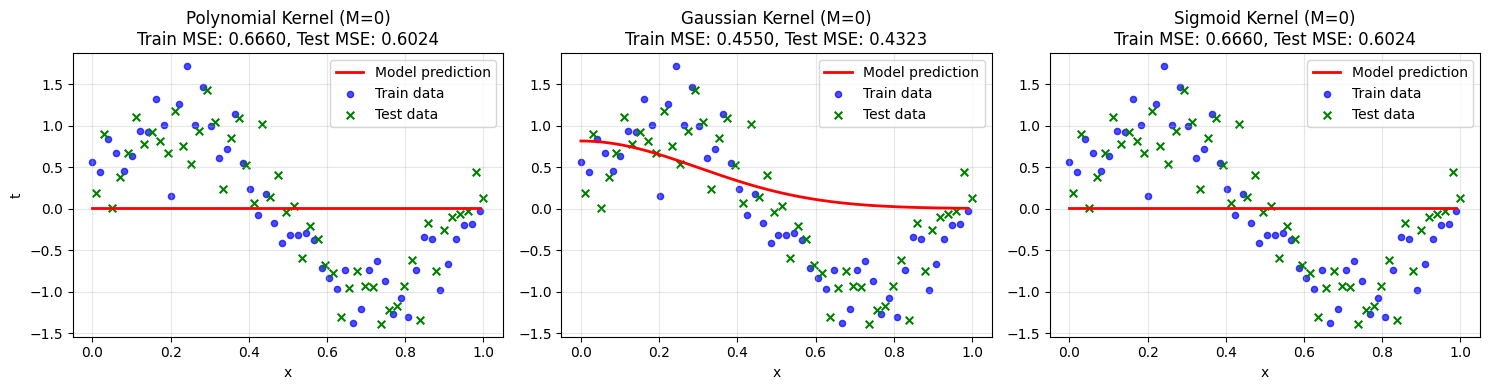


Plotting for Model Order M = 1


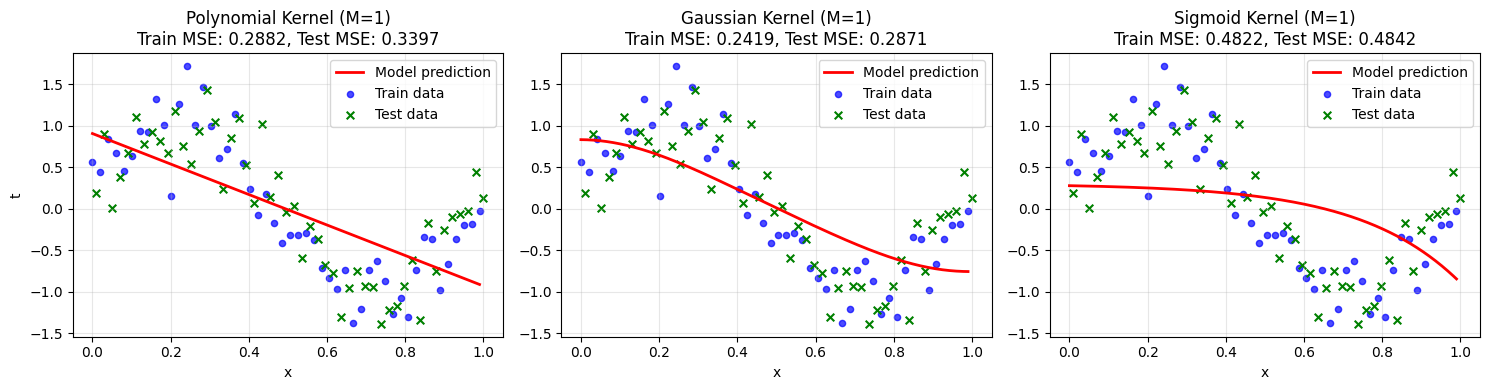


Plotting for Model Order M = 2


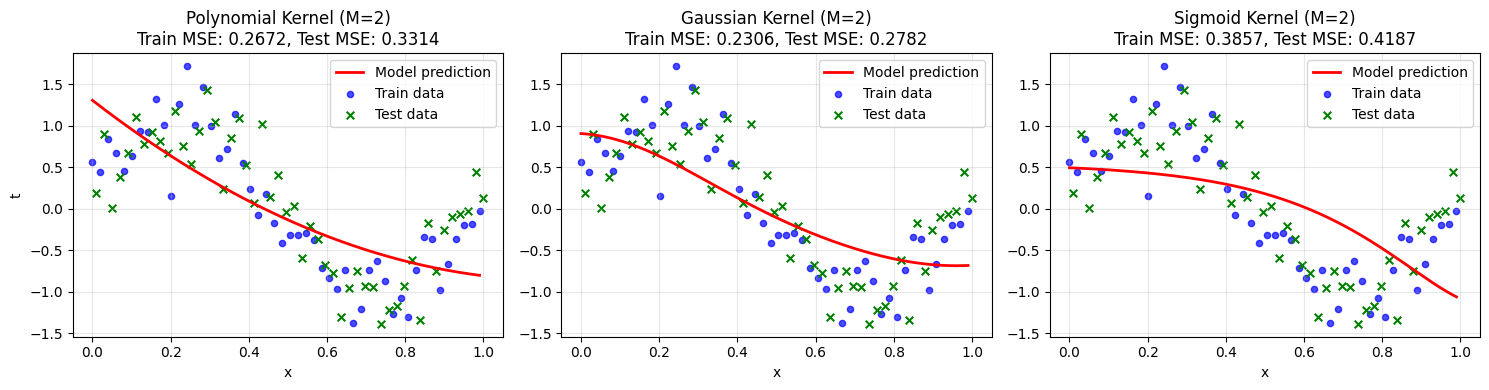


Plotting for Model Order M = 3


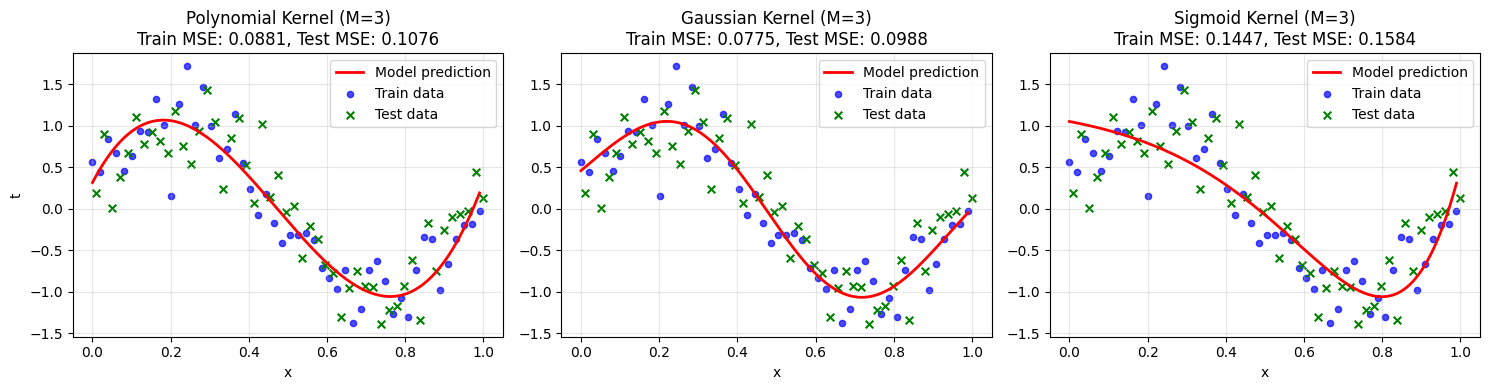


Plotting for Model Order M = 4


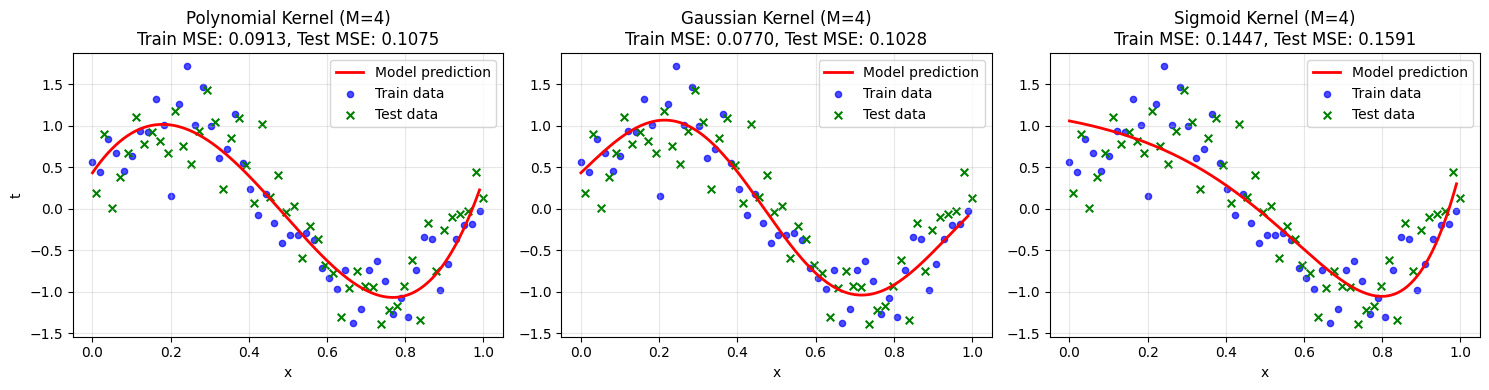


Plotting for Model Order M = 5


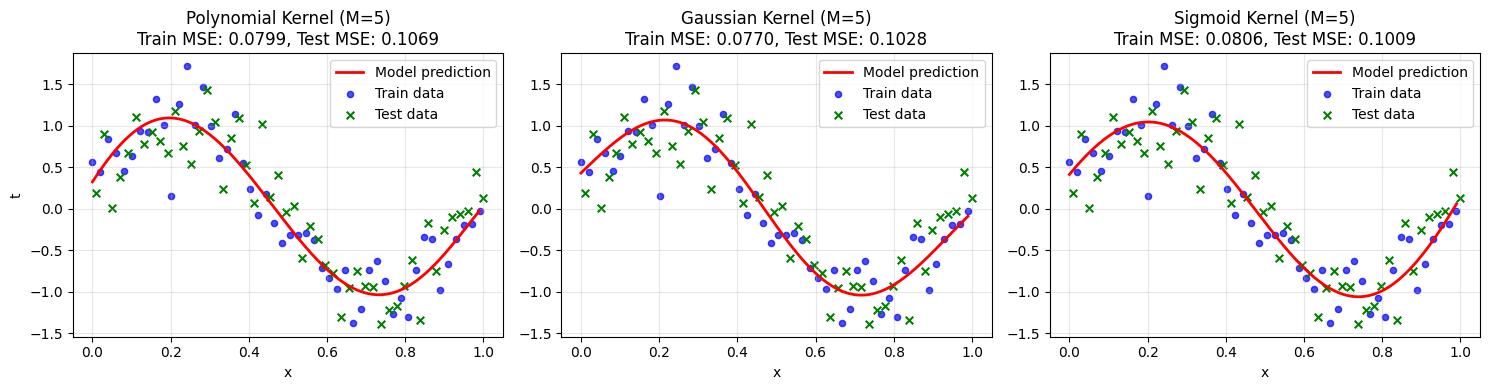


Plotting for Model Order M = 6


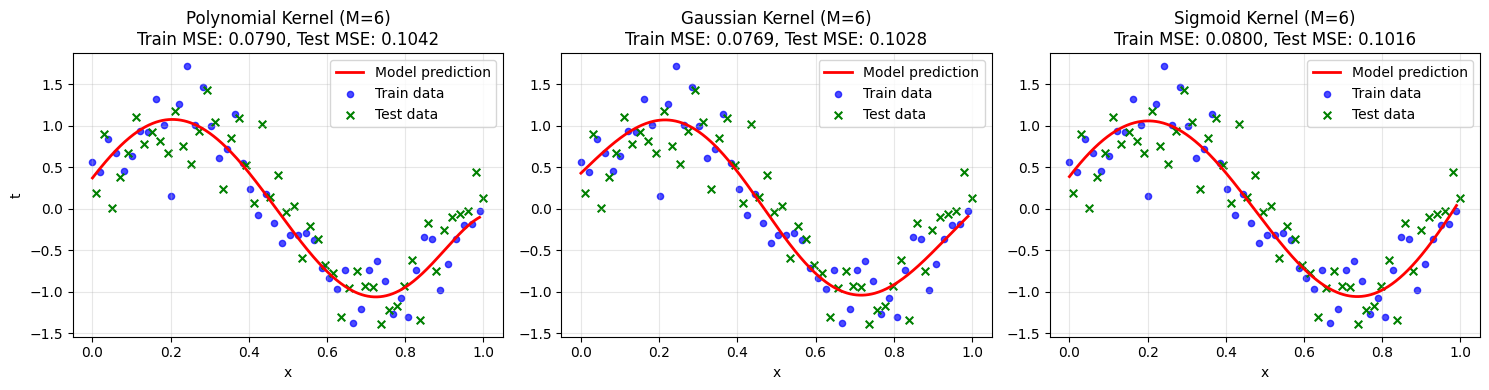


Plotting for Model Order M = 7


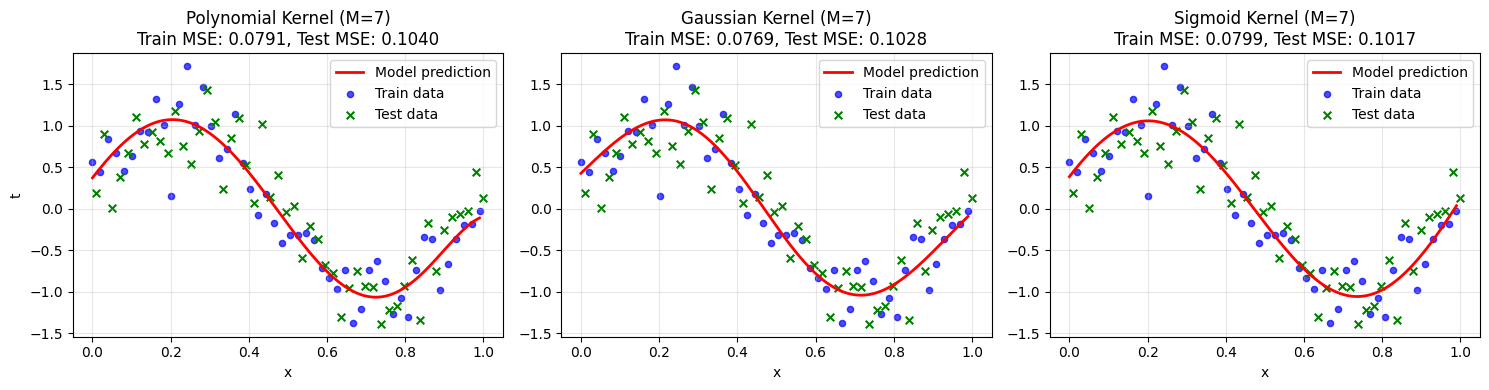


Plotting for Model Order M = 8


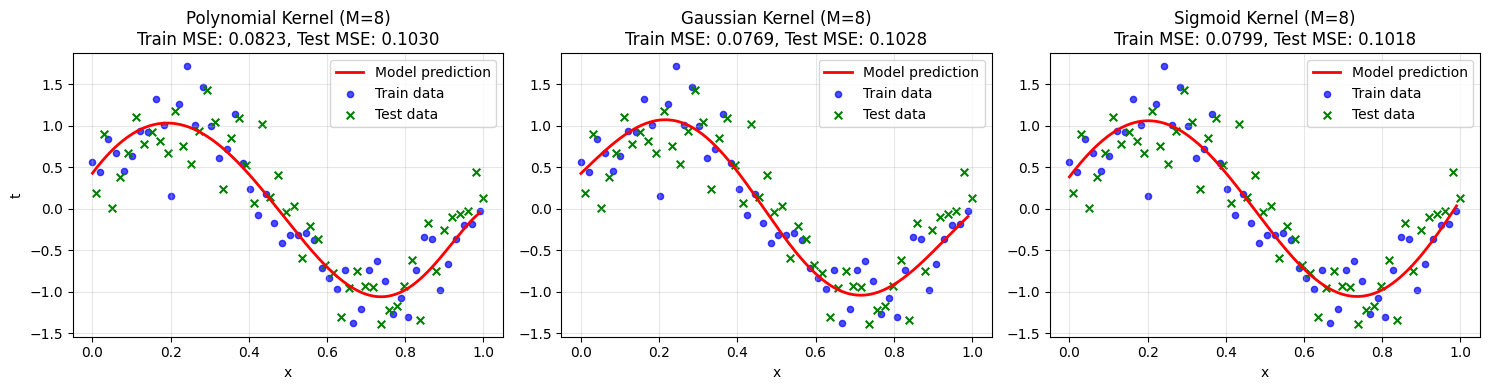


Plotting for Model Order M = 9


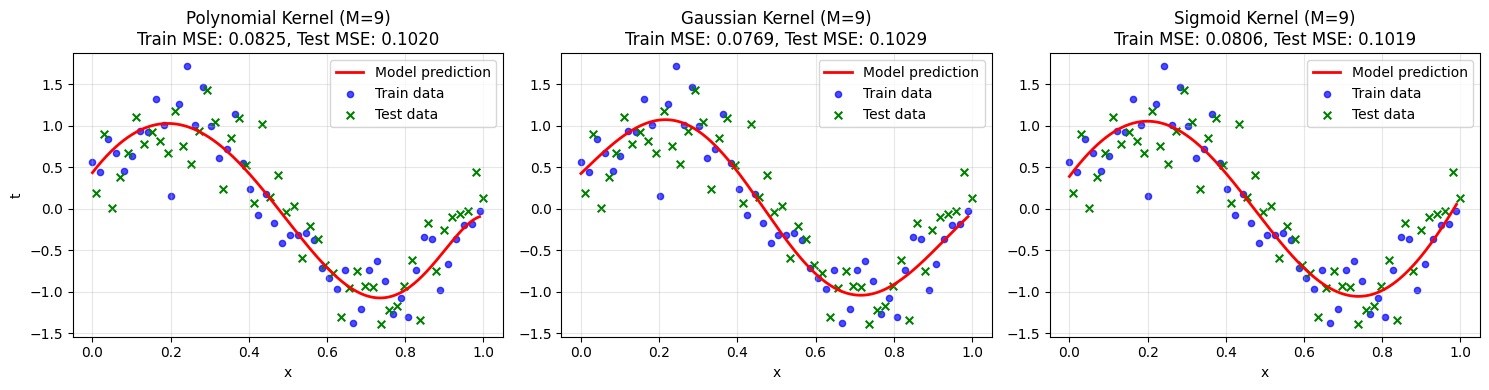

In [111]:
# Cell 6: Part 3(a) - Plot Predictions for Selected M Values
print("\n=== Plotting Predictions for Sine Function ===")
for M in M_range:  # Show subset of M values
    print(f"\nPlotting for Model Order M = {M}")
    PlotPrediction(x_train, t_train, x_test, t_test, M, best_params_dict_sine[M])

### Observations from Kernel Regression Plots (Model Order M = 0 to 9)

We trained models using **polynomial**, **gaussian**, and **sigmoid** kernels across increasing M, which control the model’s flexibility. Here's what we observed:

**M = 0 to 2: Underfitting**

- All kernels perform poorly at low M  — predictions are almost flat or overly simple.
- Both training and test errors are high.

**M = 3 to 5: Best Performance**

- The models start capturing the underlying sine pattern effectively.
- Train and test errors both drop — models are generalizing well.
- Enough flexibility to model the data, but not so much that it overfits.

**M = 6 to 9: Overfitting**

- Models continue to fit training data well (low train error).
- Predictions stay accurate, but adding more basis functions doesn’t help further.
- More complexity increases risk of overfitting without meaningful improvement.

### Kernel Type Comparison

**Gaussian**
- Smooth and accutate performance.
- It uses small bell-shaped curves that can fit complex patterns really well.

**Polynomial**
- Good for medium M but unstable for high M.
- Changes in one part of input can affect the entire curve, making them unstable and overfitting at high orders.

**Sigmoid**
- Sigmoid functions are smooth but not very flexible at low \( M \); they need more complexity to work well.
- It is like trying to draw a wavy line using only a few S-curves. With 2 or 3, the line will be flat. But with more, we can shape the line however we like by combining those curves.

### Importance of a Validation Set

Currently, we’re selecting the best model based on test error, but:

- Ideally, we should use a validation set (a third, separate split).
- Validation helps tune hyperparameters like M ,lambda ,sigma ,a and b.
- It ensures the test set remains unbiased and only used for final evaluation.

 Without a validation set, we risk overfitting to the test set by indirectly optimizing against it.




=== Error Analysis for Sine Function ===


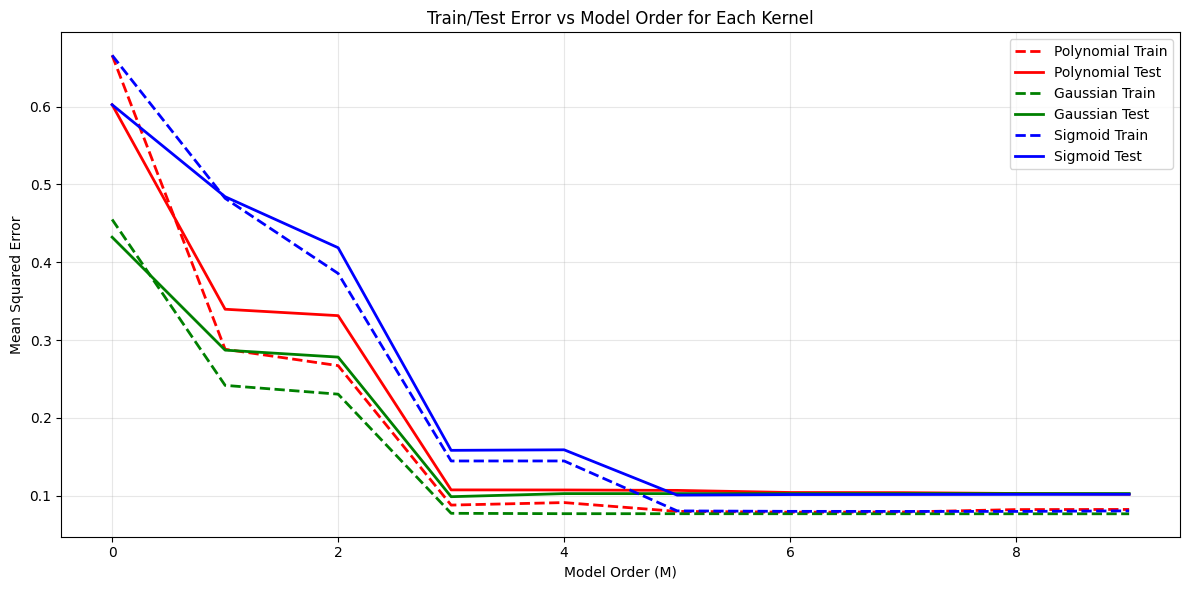

In [112]:
# Cell 7: Part 3(a) - Plot Error Analysis
print("\n=== Error Analysis for Sine Function ===")
PlotErrors(x_train, t_train, x_test, t_test, M_range, best_params_dict_sine)

### Train/Test Error vs Model Order (M) – Sine Function with Noise

From M = 0 to 5, training and test errors drop for all kernels.
This shows that increasing complexity helps the model learn the sine pattern more accurately.

#### **Gaussian Kernel**
- Performs best overall.
- Lowest training and test error across nearly all values of M.

#### **Polynomial Kernel**
- Performs well, especially at mid-range M.
- Errors flatten out around M = 5, showing it has reached its ideal order.
- Works well for smooth patterns like a sine wave.

#### **Sigmoid Kernel**
- Starts off worse, with higher test error at low M.
- Improves steadily and gets close to Gaussian and Polynomial by higher M.
- Needs more complexity to express the the function.

Hence the choice of kernel and model order should depend on the nature of the target function.


Training set size: 50
Test set size: 50


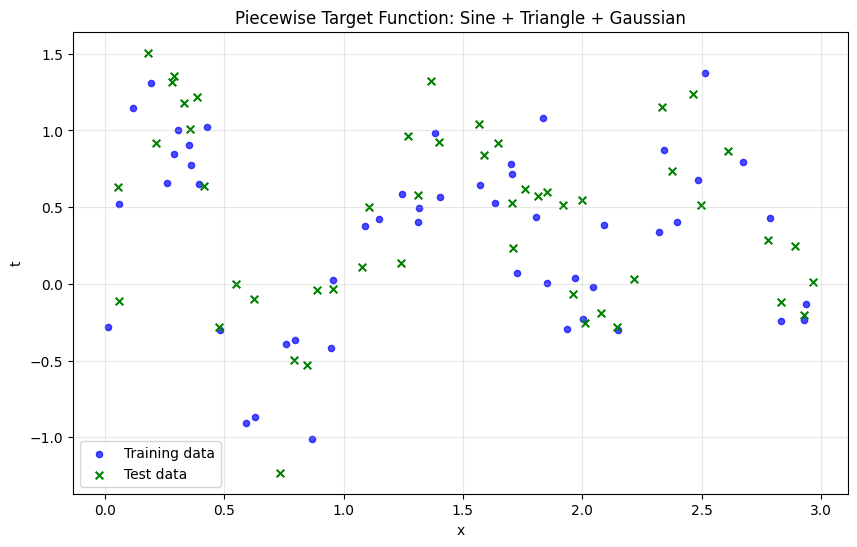

In [113]:
# Cell 8: Data Generation for Part 3(b) - Piecewise Function
# print("\nPART 3(b): Piecewise Function Analysis")
# print("=" * 50)

# Reset random seed
np.random.seed(0)

# Generate 100 random points from uniform distribution on [0, 3]
x_b = np.sort(np.random.uniform(0, 3, 100))
noise_b = np.random.normal(0, np.sqrt(0.1), size=x_b.size)

# Initialize target values
t_b = np.zeros(x_b.size)

# Define piecewise function
# Sine wave on [0, 1]
range1 = (x_b >= 0) & (x_b <= 1)
t_b[range1] = np.sin(2 * np.pi * x_b[range1])


# Triangle on (1, 2]
range2 = (x_b > 1) & (x_b <= 2)
# Triangle wave: peak at x=1.5, height=1
t_b[range2] = 1 - 2 * np.abs(x_b[range2] - 1.5)

# Gaussian bump on (2, 3]
range3 = (x_b > 2) & (x_b <= 3)
t_b[range3] = np.exp(-((x_b[range3] - 2.5) ** 2) / (2 * 0.15**2))
t_b = t_b + noise_b
t_b = t_b.reshape(-1, 1)
x_b = x_b.reshape(-1, 1)

# Take even samples for training and odd samples for testing
xb_train = x_b[::2]
tb_train = t_b[::2]
xb_test = x_b[1::2]
tb_test = t_b[1::2]

print(f"Training set size: {len(xb_train)}")
print(f"Test set size: {len(xb_test)}")

# Visualize the piecewise function
plt.figure(figsize=(10, 6))
plt.scatter(xb_train, tb_train, label="Training data", color="blue", s=20, alpha=0.7)
plt.scatter(xb_test, tb_test, label="Test data", color="green", marker="x", s=30)
plt.xlabel("x")
plt.ylabel("t")
plt.title("Piecewise Target Function: Sine + Triangle + Gaussian")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [114]:
# Cell 9: Part 3(b) - Hyperparameter Tuning for Piecewise Function
# Tune hyperparameters for piecewise function data
best_params_dict_piecewise = tune_all_kernels(
    xb_train, tb_train, xb_test, tb_test, M_range
)

=== Hyperparameter Tuning ===

Model Order M = 0
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3623
  Polynomial: λ = 0.00001, Test Error = 0.3623
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3991
  Gaussian: λ = 0.00001, Test Error = 0.3991
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3998
  Sigmoid: λ = 0.00001, Test Error = 0.3998

Model Order M = 1
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3582
  Polynomial: λ = 0.00001, Test Error = 0.3582
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3922
  Gaussian: λ = 0.00001, Test Error = 0.3922
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3762
  Sigmoid: λ = 0.00001, Test Error = 0.3762

Model Order M = 2
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3587
  Polynomial: λ = 0.00001, Test Error = 0.3587
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.2619
  Gaussian: λ = 0.00001, Test Error = 0.2619
Best λ for Polynomial Kernel = 0.0016


=== Plotting Predictions for Piecewise Function ===

Plotting for Model Order M = 0


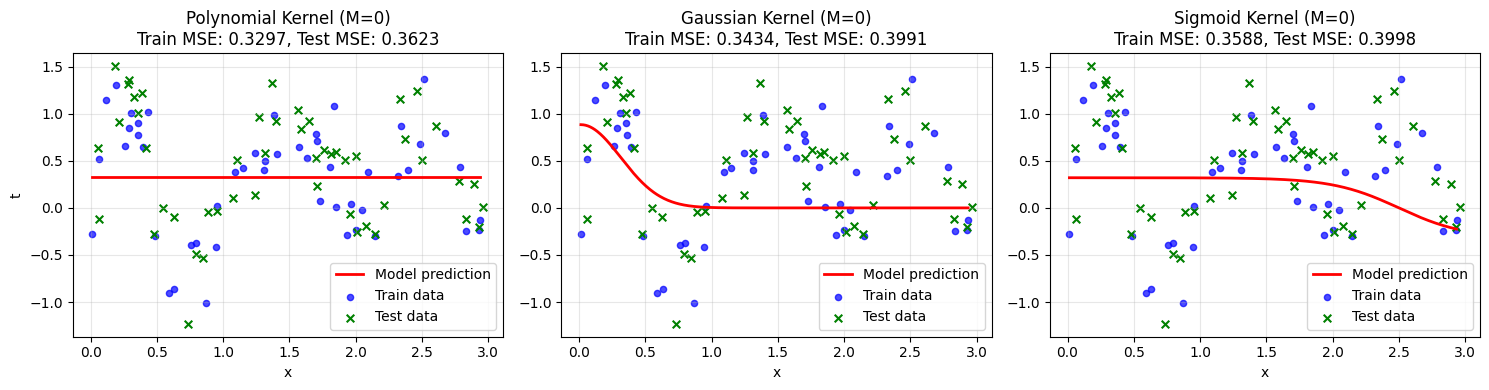


Plotting for Model Order M = 1


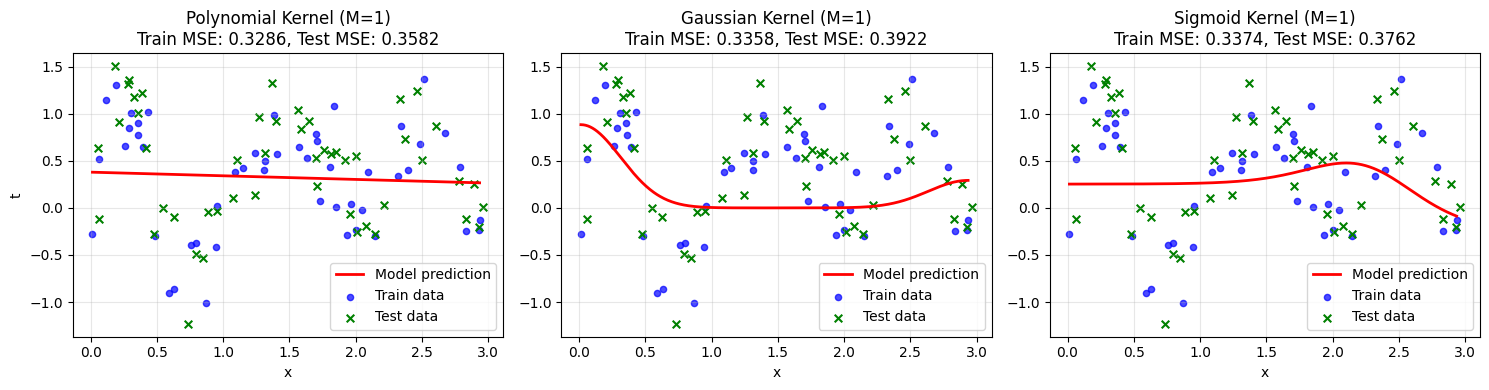


Plotting for Model Order M = 2


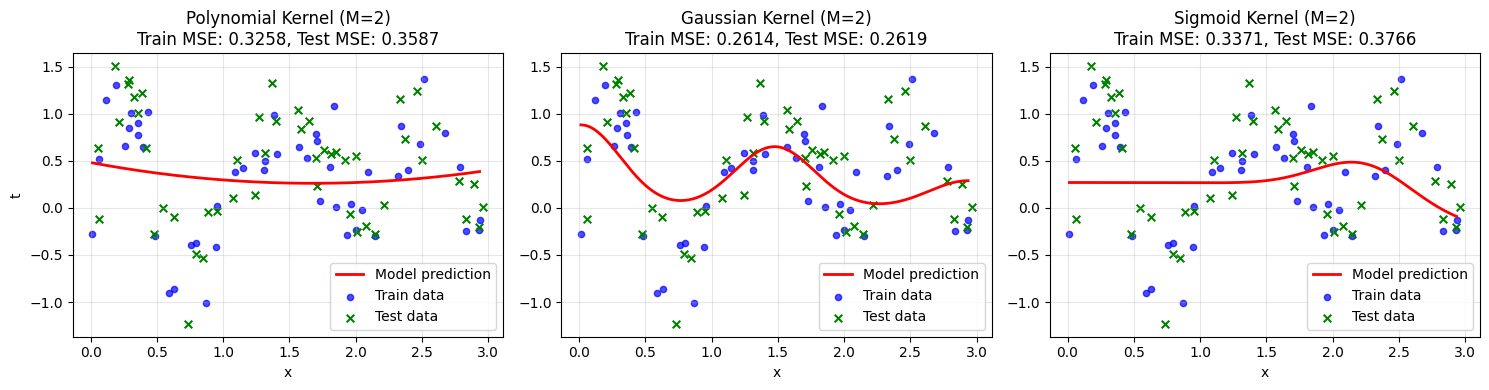


Plotting for Model Order M = 3


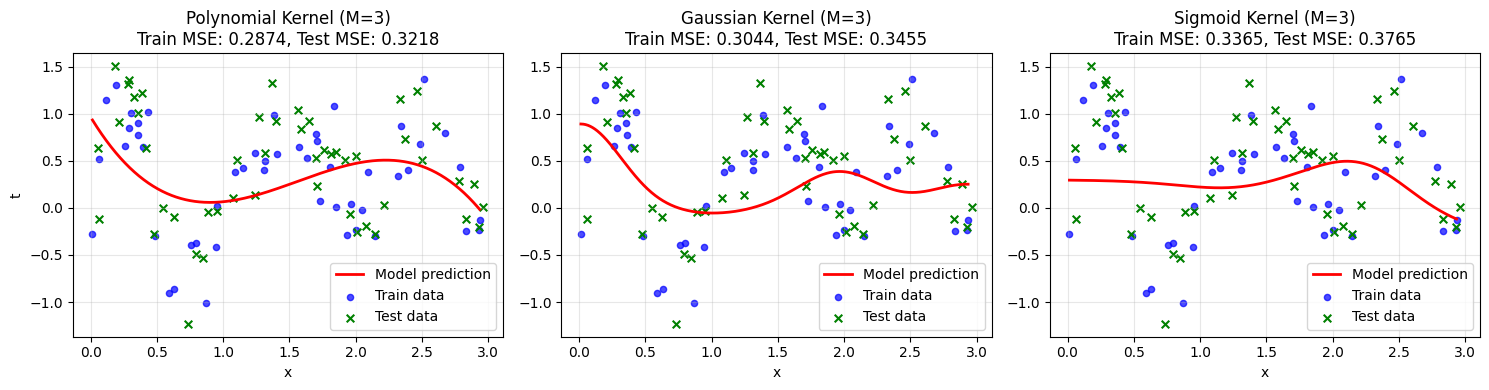


Plotting for Model Order M = 4


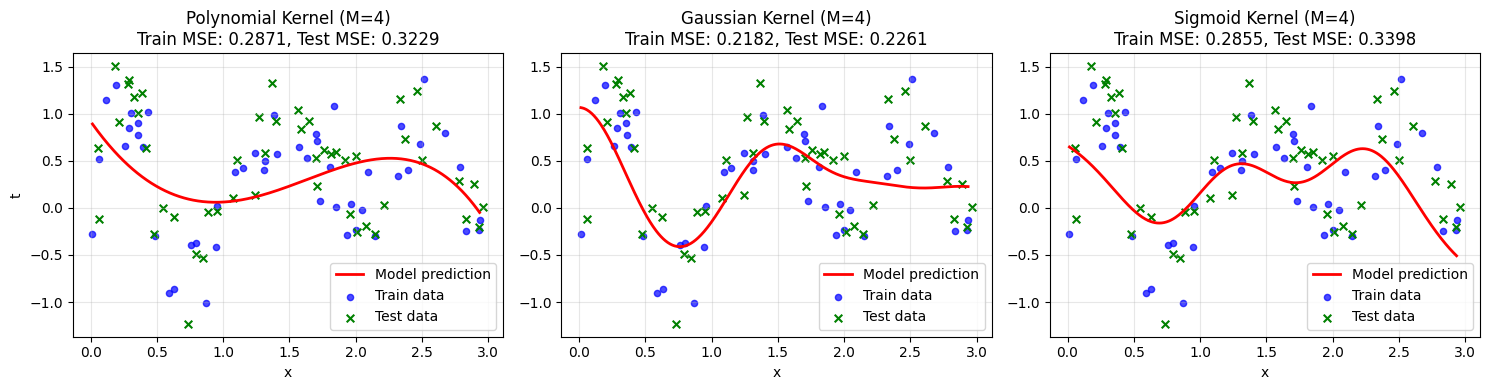


Plotting for Model Order M = 5


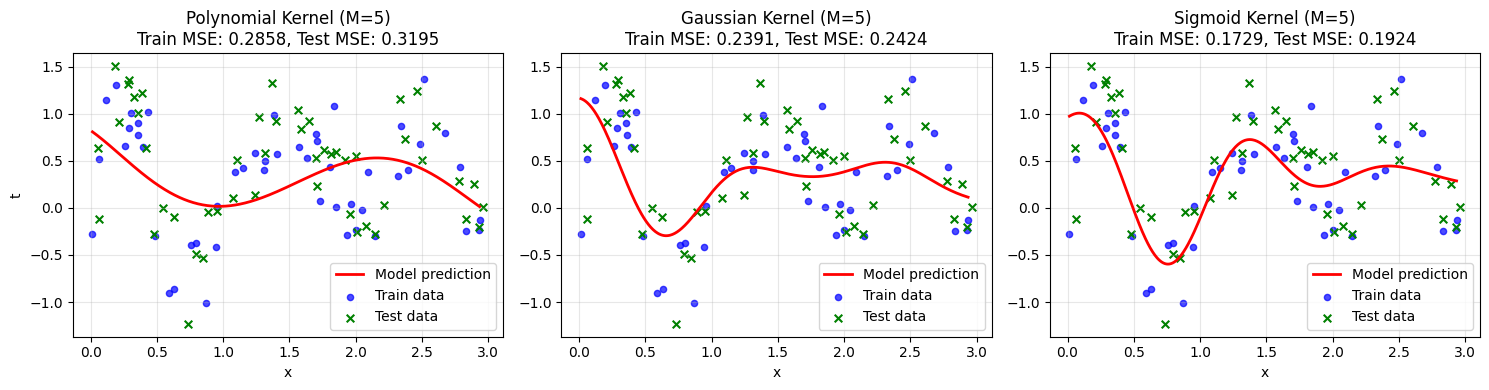


Plotting for Model Order M = 6


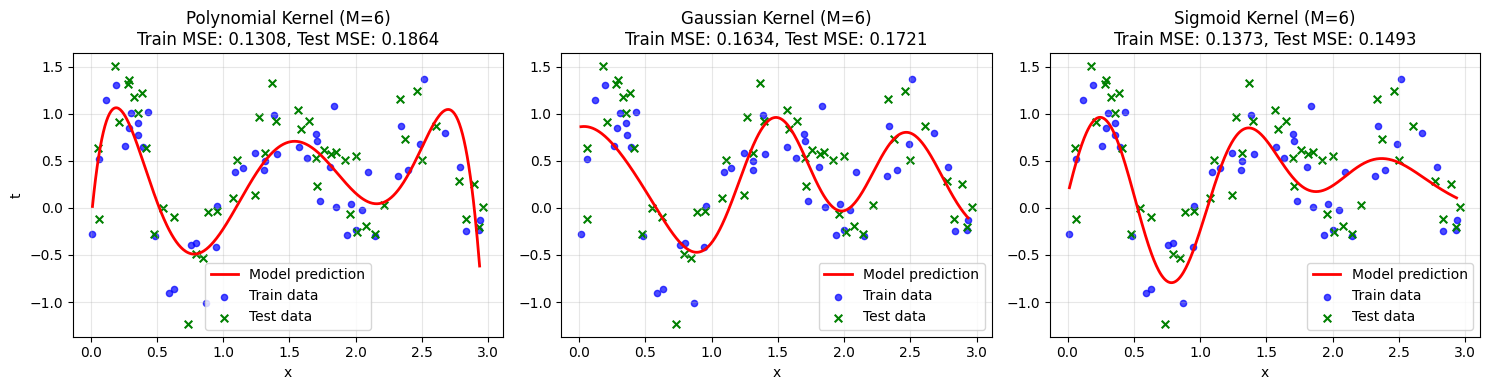


Plotting for Model Order M = 7


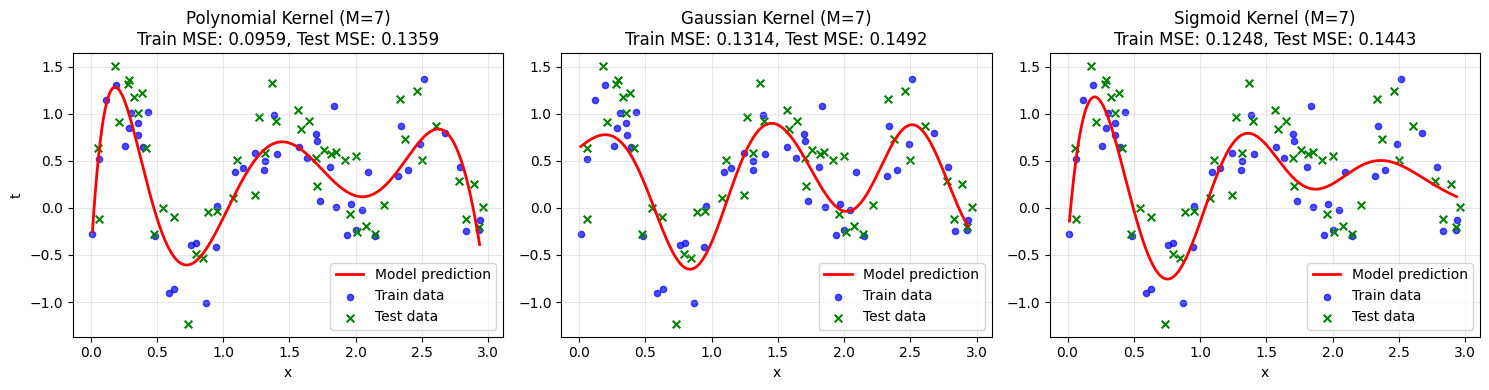


Plotting for Model Order M = 8


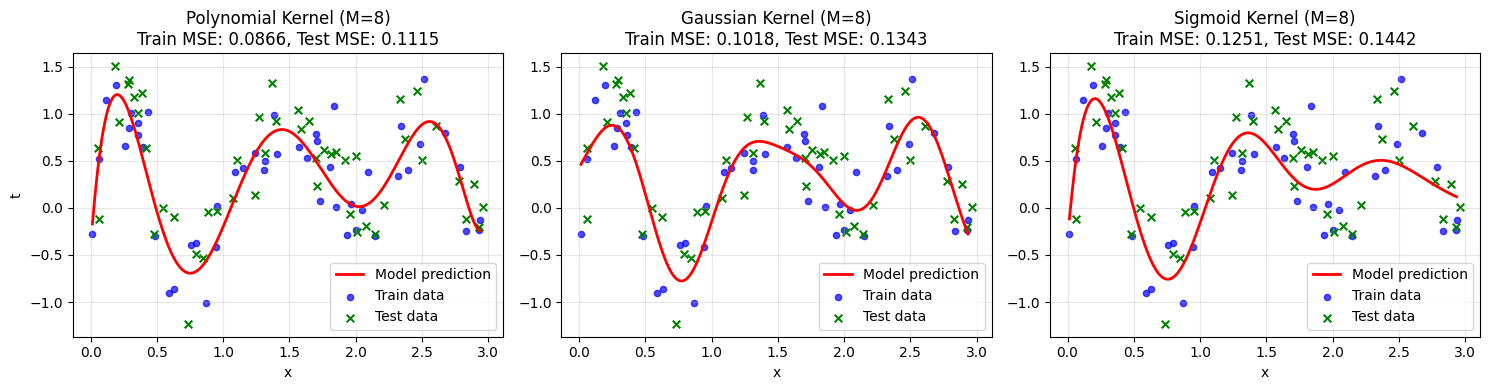


Plotting for Model Order M = 9


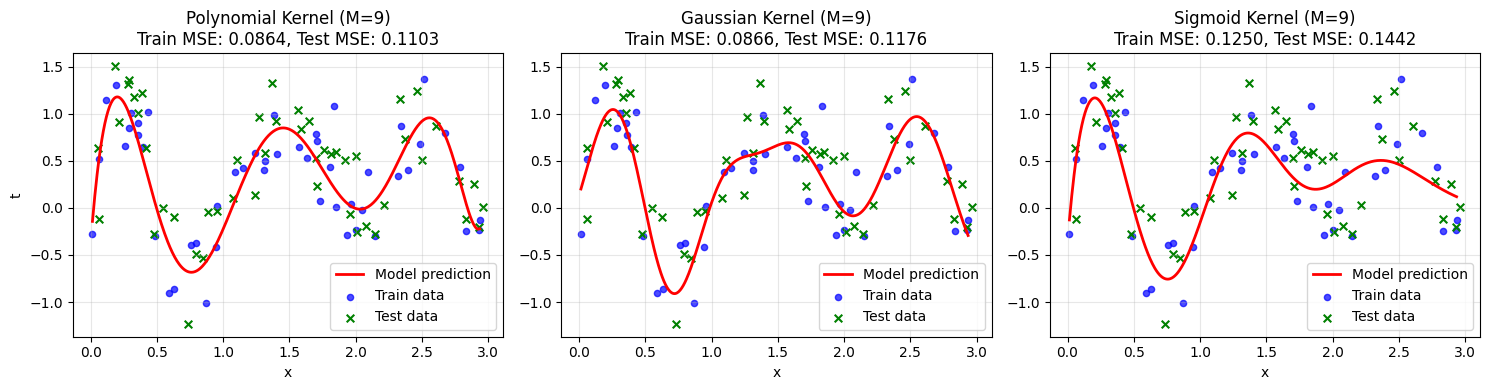

In [115]:
# Cell 10: Part 3(b) - Plot Predictions for Piecewise Function
print("\n=== Plotting Predictions for Piecewise Function ===")
M_range = list(range(10))

for M in M_range:
    print(f"\nPlotting for Model Order M = {M}")
    PlotPrediction(
        xb_train, tb_train, xb_test, tb_test, M, best_params_dict_piecewise[M]
    )

### Comparing Observations Across Two Different Target Functions

The model behavior changes significantly due to this more complex structure.

### Key Differences in Behavior

#### 1. **Higher Overall Errors**
- The mean squared errors are generally higher for all kernels, especially at lower M.
- This is because the new function has more small and abrupt changes, making it harder to approximate with fewer basis functions.

#### 2. **Polynomial Kernel**
- Polynomial kernels do okay at moderate M, but start to overfit and show wavy, unstable behavior earlier.
- Their global nature makes them poorly suited for sharp local features like the triangle peak or Gaussian bump.
- Runge phenomenon : When interpolating a smooth function over a large interval using high-degree polynomials with equally spaced points, the resulting polynomial may oscillate wildly near the endpoints, even though it fits the points exactly.

#### 3. **Gaussian Kernel**
- Gaussian kernels perform consistently well.
- They work best here because they are can adapt to small regions independently.
- Starts to overfit for M=8,9 as the difference between train and test errors increases

#### 4. **Sigmoid Kernel**
- As before, sigmoid kernels start off slow but improve with higher M.

### Conclusion

- The kind of target function you’re trying to learn really affects which kernel works best.

- If the function is smooth and changes gradually, simpler models like polynomials can work well.

- But if the function has sharp turns, bumps, or different patterns in different regions, you need something more flexible like Gaussian kernels that can adapt to local changes.

- Sigmoid kernels are also flexible, but they usually need a more complex model (higher M) to capture all the details properly.

This shows why testing on different kinds of functions is important when choosing the right kernel and model complexity.


In [116]:
# Cell 11: Part 3(b) - Error Analysis with Extended M Range
# Extended M range to show polynomial instability
M_range_extended = list(range(20))

# Tune hyperparameters for extended range
print("\n=== Extended Hyperparameter Tuning (M=0 to 19) ===")
best_params_dict_extended = tune_all_kernels(
    xb_train, tb_train, xb_test, tb_test, M_range_extended
)


=== Extended Hyperparameter Tuning (M=0 to 19) ===
=== Hyperparameter Tuning ===

Model Order M = 0
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3623
  Polynomial: λ = 0.00001, Test Error = 0.3623
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3991
  Gaussian: λ = 0.00001, Test Error = 0.3991
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3998
  Sigmoid: λ = 0.00001, Test Error = 0.3998

Model Order M = 1
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3582
  Polynomial: λ = 0.00001, Test Error = 0.3582
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3922
  Gaussian: λ = 0.00001, Test Error = 0.3922
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3762
  Sigmoid: λ = 0.00001, Test Error = 0.3762

Model Order M = 2
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.3587
  Polynomial: λ = 0.00001, Test Error = 0.3587
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.2619
  Gaussian: λ = 0.00001, Test 


=== Extended Error Analysis for Piecewise Function ===


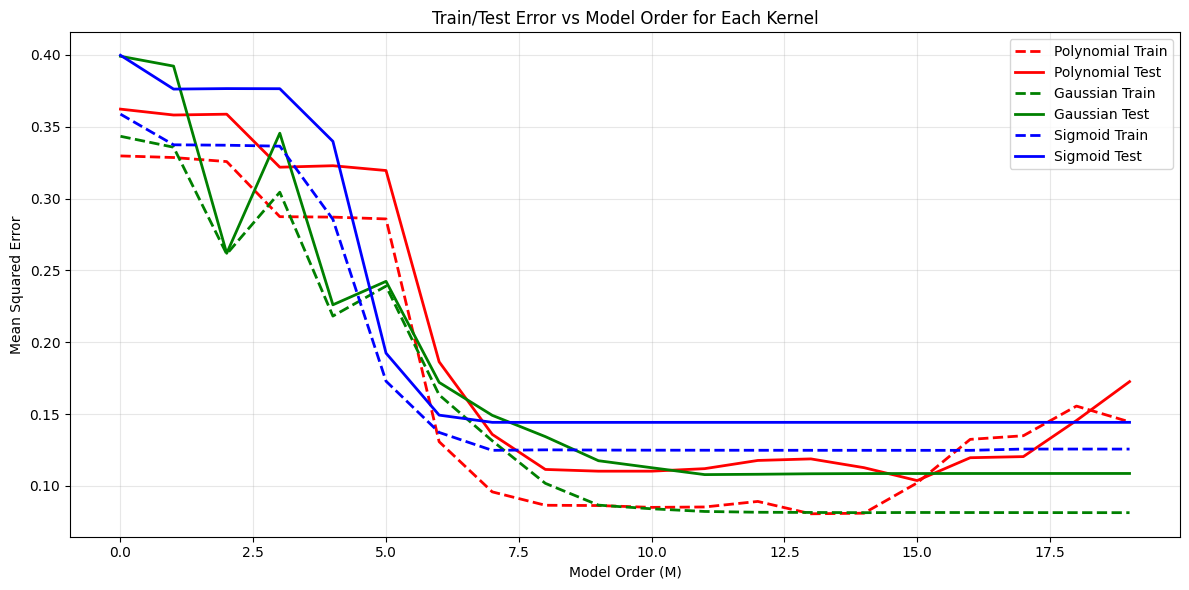

In [117]:
# Cell 12: Part 3(b) - Extended Error Analysis Plot
print("\n=== Extended Error Analysis for Piecewise Function ===")
PlotErrors(
    xb_train, tb_train, xb_test, tb_test, M_range_extended, best_params_dict_extended
)

### Train/Test Error vs Model Order (M) – Piecewise Target Function

Train and test errors decrease steadily, meaning the models are learning the underlying pattern as complexity increases.

#### **Polynomial Kernel**
- Initially performs reasonably well.
- But after M = 13 , both training and test errors suddenly increase and oscillate.
- Runge phenomenon can be observed more clearly here.
- This sharp increase was only visible after we extended the model order range from 10 to 20. Before that, the polynomial kernel appeared to perform similarly to the others.

#### **Gaussian Kernel**
- Maintains consistently low errors across all M.
- Can be suitable for piecewise or irregular target functions.

#### **Sigmoid Kernel**
- Has slightly higher error than Gaussian, but stays stable and smooth.

### Conclusion

- **Gaussian kernels** are the most robust across varying complexity — they model local features without instability.
- **Polynomial kernels** may suddenly overfit at higher orders, so always test a wide range of M.
- **Sigmoid kernels** offer smooth performance and are less risky than polynomials for irregular data.


In [118]:
# Cell 13: Summary and Analysis
print("\n" + "=" * 70)
print("SUMMARY OF RESULTS")
print("=" * 70)

print("\nPART 3(a) - Sine Function:")
print("-" * 30)
print("• Gaussian kernel performs best overall with lowest errors")
print("• Polynomial kernel works well for smooth functions like sine")
print("• Sigmoid kernel needs higher M to capture the pattern effectively")
print("• All kernels show good performance for M=3 to M=7")

print("\nPART 3(b) - Piecewise Function:")
print("-" * 35)
print("• Gaussian kernel remains most robust across all M values")
print("• Polynomial kernel shows instability (Runge phenomenon) at high M")
print("• Sigmoid kernel performs adequately but requires higher complexity")
print("• Local kernels (Gaussian) better suited for irregular/piecewise functions")

print("\nKey Observations:")
print("• Choice of kernel depends on target function characteristics")
print("• Gaussian kernels are most versatile and stable")
print("• Polynomial kernels risk overfitting with high-degree polynomials")
print("• Regularization (λ) is crucial for preventing overfitting")
print("• Validation set should be used instead of test set for hyperparameter tuning")


SUMMARY OF RESULTS

PART 3(a) - Sine Function:
------------------------------
• Gaussian kernel performs best overall with lowest errors
• Polynomial kernel works well for smooth functions like sine
• Sigmoid kernel needs higher M to capture the pattern effectively
• All kernels show good performance for M=3 to M=7

PART 3(b) - Piecewise Function:
-----------------------------------
• Gaussian kernel remains most robust across all M values
• Polynomial kernel shows instability (Runge phenomenon) at high M
• Sigmoid kernel performs adequately but requires higher complexity
• Local kernels (Gaussian) better suited for irregular/piecewise functions

Key Observations:
• Choice of kernel depends on target function characteristics
• Gaussian kernels are most versatile and stable
• Polynomial kernels risk overfitting with high-degree polynomials
• Regularization (λ) is crucial for preventing overfitting
• Validation set should be used instead of test set for hyperparameter tuning


In [119]:
# Cell 14: Final Comparison - Best Performing Models
def compare_best_models():
    """Compare the best performing model from each dataset"""

    # Find best performing models for sine function
    print("Best Models for Sine Function (Part 3a):")
    print("-" * 40)

    best_sine_errors = {}
    for M in M_range:
        for kernel in ["polynomial", "gaussian", "sigmoid"]:
            lamda = best_params_dict_sine[M][kernel]
            w_est = KernelRegressionFit(x_train, t_train, kernel, M, lamda)
            _, test_err = KernelRegressionPred_Error(
                w_est, x_train, t_train, x_test, t_test, kernel, M
            )

            key = f"{kernel}_M{M}"
            best_sine_errors[key] = test_err

    best_sine_model = min(best_sine_errors, key=best_sine_errors.get)
    print(
        f"Best model: {best_sine_model} with Test Error: {best_sine_errors[best_sine_model]:.4f}"
    )

    # Find best performing models for piecewise function
    print("\nBest Models for Piecewise Function (Part 3b):")
    print("-" * 45)

    best_piecewise_errors = {}
    for M in M_range:
        for kernel in ["polynomial", "gaussian", "sigmoid"]:
            lamda = best_params_dict_piecewise[M][kernel]
            w_est = KernelRegressionFit(xb_train, tb_train, kernel, M, lamda)
            _, test_err = KernelRegressionPred_Error(
                w_est, xb_train, tb_train, xb_test, tb_test, kernel, M
            )

            key = f"{kernel}_M{M}"
            best_piecewise_errors[key] = test_err

    best_piecewise_model = min(best_piecewise_errors, key=best_piecewise_errors.get)
    print(
        f"Best model: {best_piecewise_model} with Test Error: {best_piecewise_errors[best_piecewise_model]:.4f}"
    )


compare_best_models()

Best Models for Sine Function (Part 3a):
----------------------------------------
Best model: gaussian_M3 with Test Error: 0.0988

Best Models for Piecewise Function (Part 3b):
---------------------------------------------
Best model: polynomial_M9 with Test Error: 0.1103


# PART 4

In [120]:
# Import functions from Code 1
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [121]:
def generate_data_3a(num_points=100, noise_std=0.1):
    """Generates data for Part 3(a): t_n = sin(2*pi*x_n) + e_n"""
    X = np.random.rand(num_points, 1)
    e = np.random.normal(0, noise_std, (num_points, 1))
    T = np.sin(2 * np.pi * X) + e
    return X.flatten(), T.flatten()


def generate_data_3b(num_points_total=100, noise_std=0.1):
    """Generates data for Part 3(b): piecewise function"""
    num_points_per_segment = num_points_total // 3
    X_segments, T_segments = [], []

    X1 = np.random.uniform(0, 1, num_points_per_segment)
    T1 = np.sin(2 * np.pi * X1)
    X_segments.append(X1)
    T_segments.append(T1)

    X2 = np.random.uniform(1, 2, num_points_per_segment)
    T2 = 2 * (0.5 - np.abs(X2 - 1.5))
    X_segments.append(X2)
    T_segments.append(T2)

    num_points_s3 = num_points_total - 2 * num_points_per_segment
    X3 = np.random.uniform(2, 3, num_points_s3)
    T3 = np.exp(-((X3 - 2.5) ** 2) / (2 * 0.1**2))
    X_segments.append(X3)
    T_segments.append(T3)

    X = np.concatenate(X_segments)
    T_true = np.concatenate(T_segments)
    e = np.random.normal(0, noise_std, X.shape[0])
    T = T_true + e

    sorted_indices = np.argsort(X)
    X = X[sorted_indices]
    T = T[sorted_indices]

    return X.flatten(), T.flatten()

In [122]:
def detect_convergence(mse_history, tolerance=1e-5, window=10):
    """
    Detect convergence based on MSE change over a window
    Returns the epoch where convergence is detected, or -1 if not converged
    """
    if len(mse_history) < window:
        return -1

    for i in range(window, len(mse_history)):
        recent_window = mse_history[i - window : i]
        if max(recent_window) - min(recent_window) < tolerance:
            return i - window
    return -1

### Convergence detecting function

- It looks at the mse_history (a list of MSE values from previous epochs/iterations).
- It considers a window of the most recent MSE values.
- f the difference between the maximum and minimum MSE within this window is less than a given tolerance, it assumes the model's performance has plateaued and returns the epoch number where convergence was detected.
- If the condition is not met or if there isn't enough history yet, it returns -1 to indicate that training should continue.

In [123]:
def sgd_training_with_analysis(
    X_train,
    Y_train,
    X_test,
    Y_test,
    kernelType,
    M_order,
    step_size,
    batch_size,
    max_epochs=500,
    convergence_tol=1e-5,
):
    """
    SGD training with convergence detection and detailed analysis
    """
    N_train = len(X_train)

    # Initialize weights
    np.random.seed(42)  # For reproducibility
    weights = np.random.randn(M_order + 1) * 0.01

    train_errors = []
    test_errors = []

    for epoch in range(max_epochs):
        # Shuffle data
        X_train_shuffled, Y_train_shuffled = sk_shuffle(
            X_train, Y_train, random_state=epoch
        )

        # Mini-batch processing
        num_batches = N_train // batch_size
        if N_train % batch_size != 0:
            num_batches += 1

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, N_train)
            X_batch = X_train_shuffled[start_idx:end_idx]
            Y_batch = Y_train_shuffled[start_idx:end_idx]

            if len(X_batch) == 0:
                continue

            # Compute batch gradient
            batch_gradient_sum = np.zeros_like(weights)

            for n in range(len(X_batch)):
                x_n = X_batch[n]
                y_n = Y_batch[n]

                # Get kernel features
                x_n_reshaped = np.array([x_n]).reshape(-1, 1)
                phi_n = get_kernel(x_n_reshaped, M_order, kernelType)[0]

                # Compute gradient
                y_pred_n = phi_n @ weights
                grad_n = 2 * (y_pred_n - y_n) * phi_n
                # grad_n = np.clip(2 * (y_pred_n - y_n) * phi_n, -1e5, 1e5)
                batch_gradient_sum += grad_n

            # Update weights
            mean_batch_gradient = batch_gradient_sum / len(X_batch)
            weights -= step_size * mean_batch_gradient

        # Compute errors
        train_error, test_error = KernelRegressionPred_Error(
            weights, X_train, Y_train, X_test, Y_test, kernelType, M_order
        )
        train_errors.append(train_error)
        test_errors.append(test_error)

        # Check for convergence
        if epoch >= 20:  # Start checking after some epochs
            convergence_epoch = detect_convergence(
                test_errors, convergence_tol, window=10
            )
            if convergence_epoch != -1:
                return weights, train_errors, test_errors, epoch + 1

    return weights, train_errors, test_errors, max_epochs

### sgd_training_with_analysis Function

1. **Initialization**: Randomly initializes model weights.

2. **Training Loop**: Runs for multiple epochs, shuffling data each time and processing it in mini-batches. For each batch, it computes MSE gradients and updates weights using averaged gradients.

3. **Error Tracking**: After each mini-batch update, it computes and stores full training and test MSE, which is computationally expensive but useful for analysis.

4. **Output**: Returns the final model weights, training/testing error history, and the epoch of convergence.


In [124]:
# Generate datasets
print("Generating datasets...")
X_3a, T_3a = generate_data_3a(num_points=100)
X_train_3a, X_test_3a, Y_train_3a, Y_test_3a = train_test_split(
    X_3a, T_3a, test_size=0.5, random_state=42
)

X_3b, T_3b = generate_data_3b(num_points_total=150)
X_train_3b, X_test_3b, Y_train_3b, Y_test_3b = train_test_split(
    X_3b, T_3b, test_size=0.5, random_state=42
)

# Kernel-specific step sizes
kernel_step_sizes = {
    "polynomial": [ 0.0001,0.00001, 0.00005],
    "gaussian": [0.1,0.5,0.01, 0.001, 0.0001, 0.00001],
    "sigmoid": [0.1, 0.01, 0.001, 0.0001]
}

# Other parameters for comprehensive analysis
kernels = ["polynomial", "gaussian", "sigmoid"]
batch_sizes = [1, 5, 10, 25, 50]
M_order = 5
max_epochs = 200

datasets = {
    "3a": (X_train_3a, Y_train_3a, X_test_3a, Y_test_3a),
    "3b": (X_train_3b, Y_train_3b, X_test_3b, Y_test_3b),
}

Generating datasets...


### Step Size for different Kernels

- The step size list is different for each kernel type because certain step size causes overflow. Therefore, the most suitable and feasible ones are chosen for observation after testing for various step sizes.

In [125]:
# Generate datasets
print("Generating datasets...")
X_3a, T_3a = generate_data_3a(num_points=100)
X_train_3a, X_test_3a, Y_train_3a, Y_test_3a = train_test_split(
    X_3a, T_3a, test_size=0.5, random_state=42
)

X_3b, T_3b = generate_data_3b(num_points_total=150)
X_train_3b, X_test_3b, Y_train_3b, Y_test_3b = train_test_split(
    X_3b, T_3b, test_size=0.5, random_state=42
)

# Kernel-specific step sizes
kernel_step_sizes = {
    "polynomial": [0.0001, 0.00001, 0.000001],
    "gaussian": [0.1, 0.01, 0.001, 0.0001, 0.00001],
    "sigmoid": [0.1, 0.01, 0.001, 0.0001],
}

# Other parameters for comprehensive analysis
kernels = ["polynomial", "gaussian", "sigmoid"]
batch_sizes = [1, 5, 10, 25, 50]
M_order = 5
max_epochs = 300

datasets = {
    "3a": (X_train_3a, Y_train_3a, X_test_3a, Y_test_3a),
    "3b": (X_train_3b, Y_train_3b, X_test_3b, Y_test_3b),
}

Generating datasets...


Valid batch sizes for dataset 3a: [1, 5, 10, 25, 50]
Valid batch sizes for dataset 3b: [1, 5, 10, 25, 50, 75]
Step sizes for polynomial kernel: [0.0001, 1e-05, 1e-06]
Step sizes for gaussian kernel: [0.1, 0.01, 0.001, 0.0001, 1e-05]
Step sizes for sigmoid kernel: [0.1, 0.01, 0.001, 0.0001]

Analyzing dataset 3a

Kernel: polynomial
  Step size: 0.0001
  Step size: 1e-05
  Step size: 1e-06


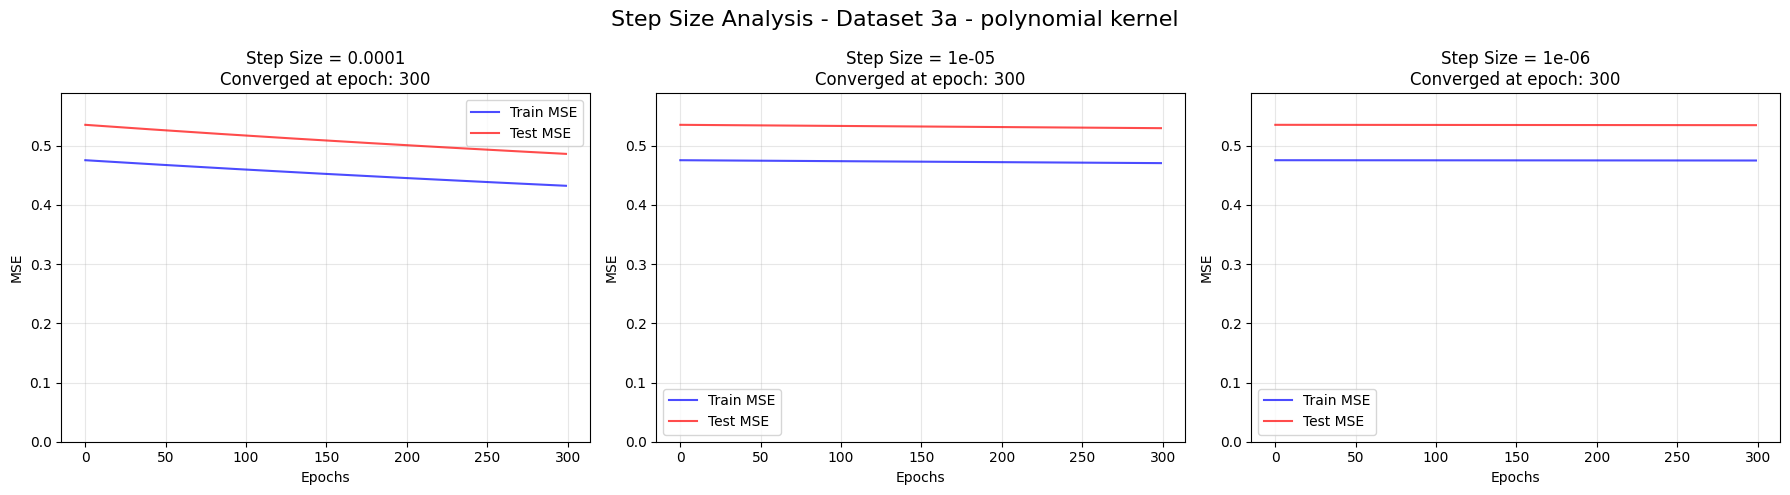

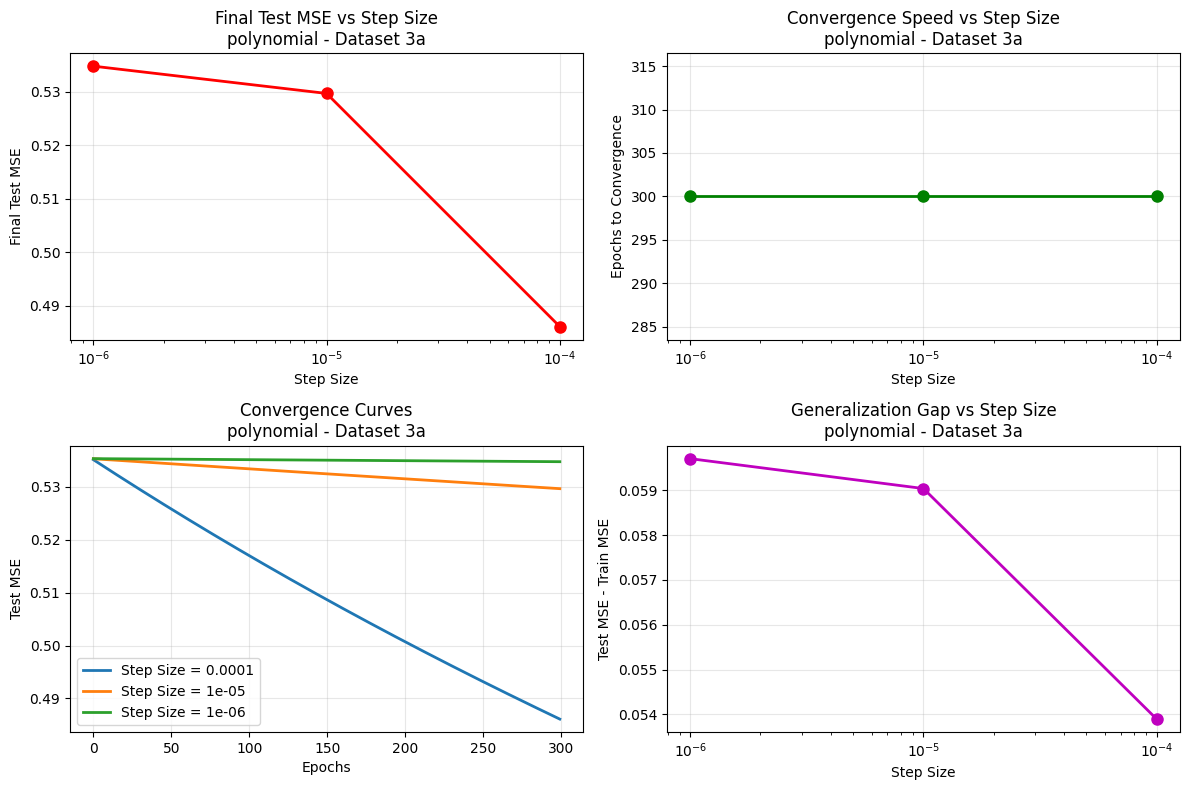


Kernel: gaussian
  Step size: 0.1
  Step size: 0.01
  Step size: 0.001
  Step size: 0.0001
  Step size: 1e-05


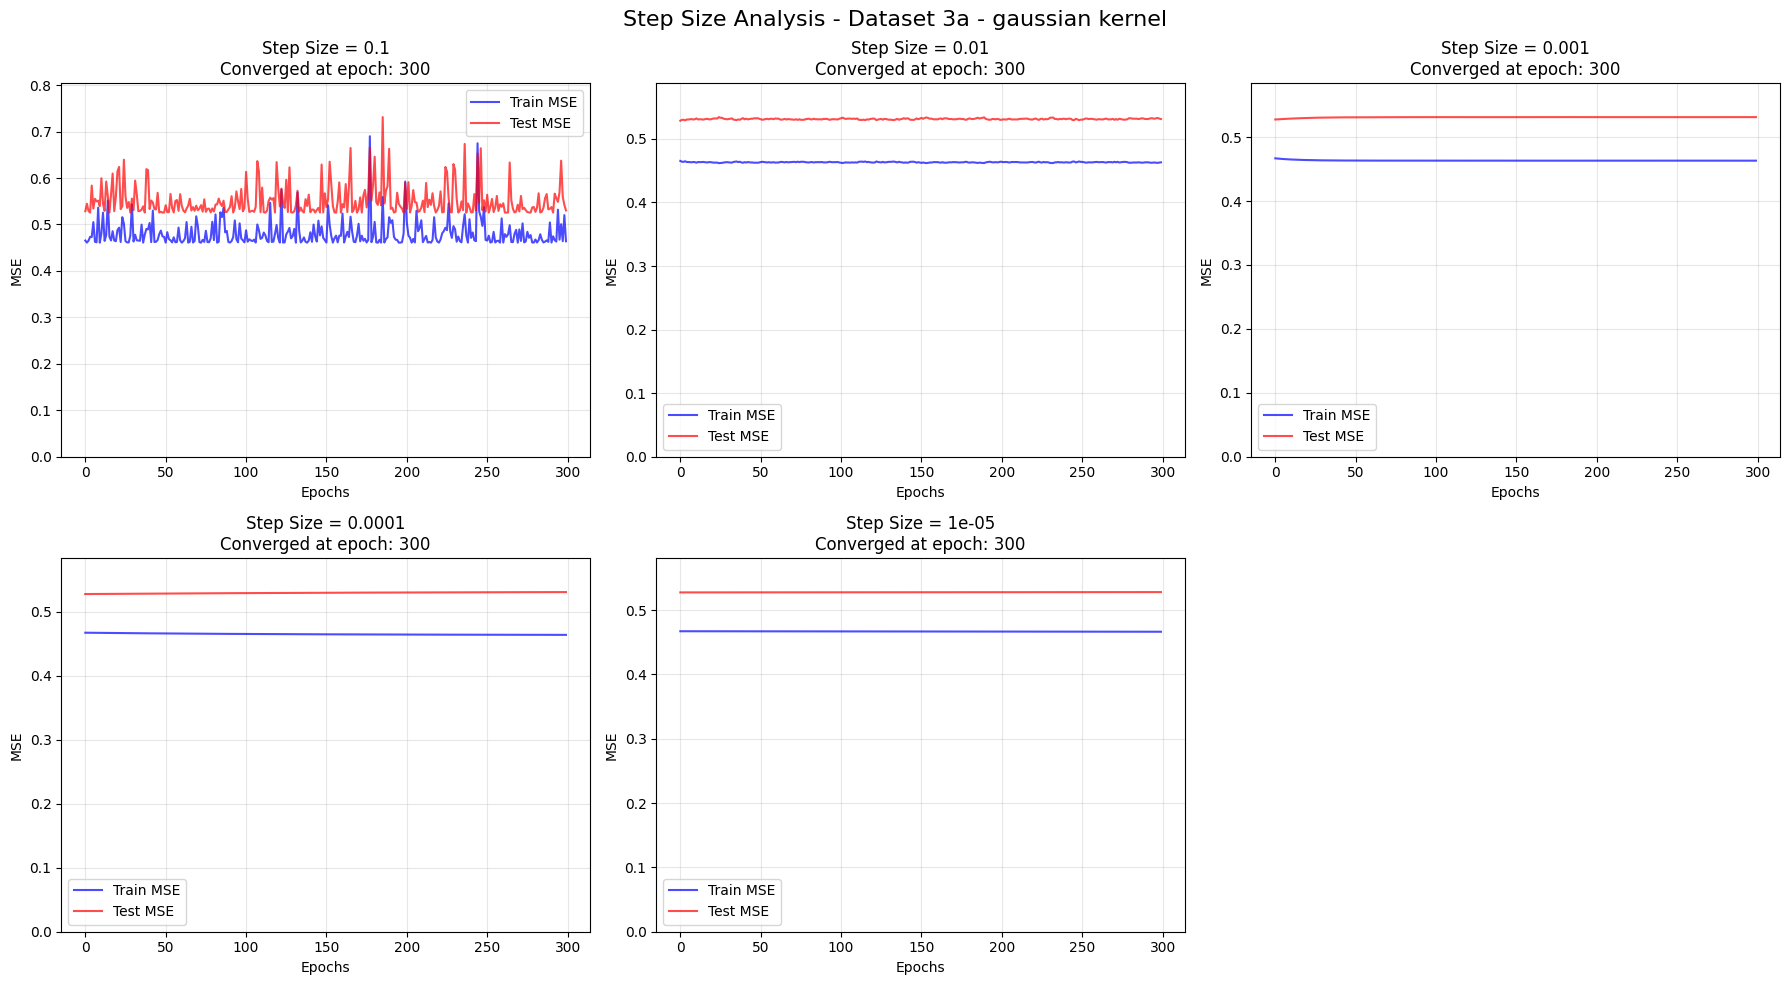

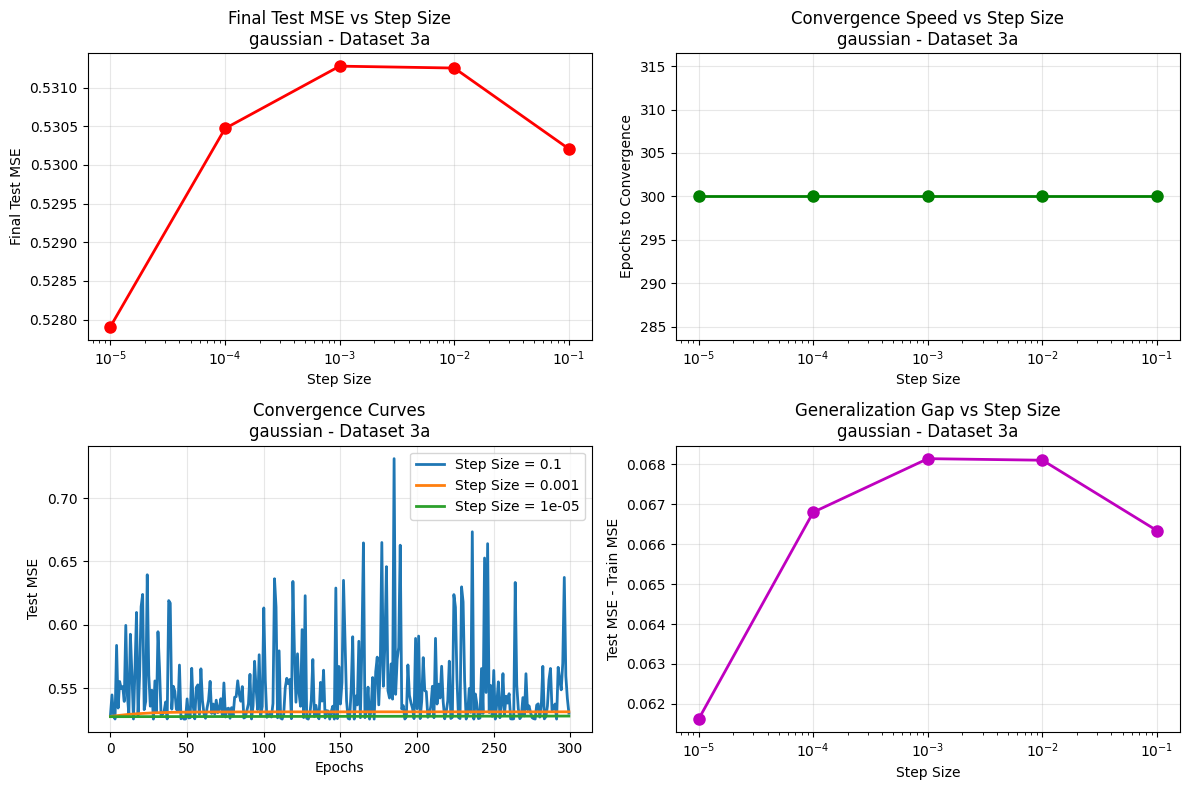


Kernel: sigmoid
  Step size: 0.1
  Step size: 0.01
  Step size: 0.001
  Step size: 0.0001


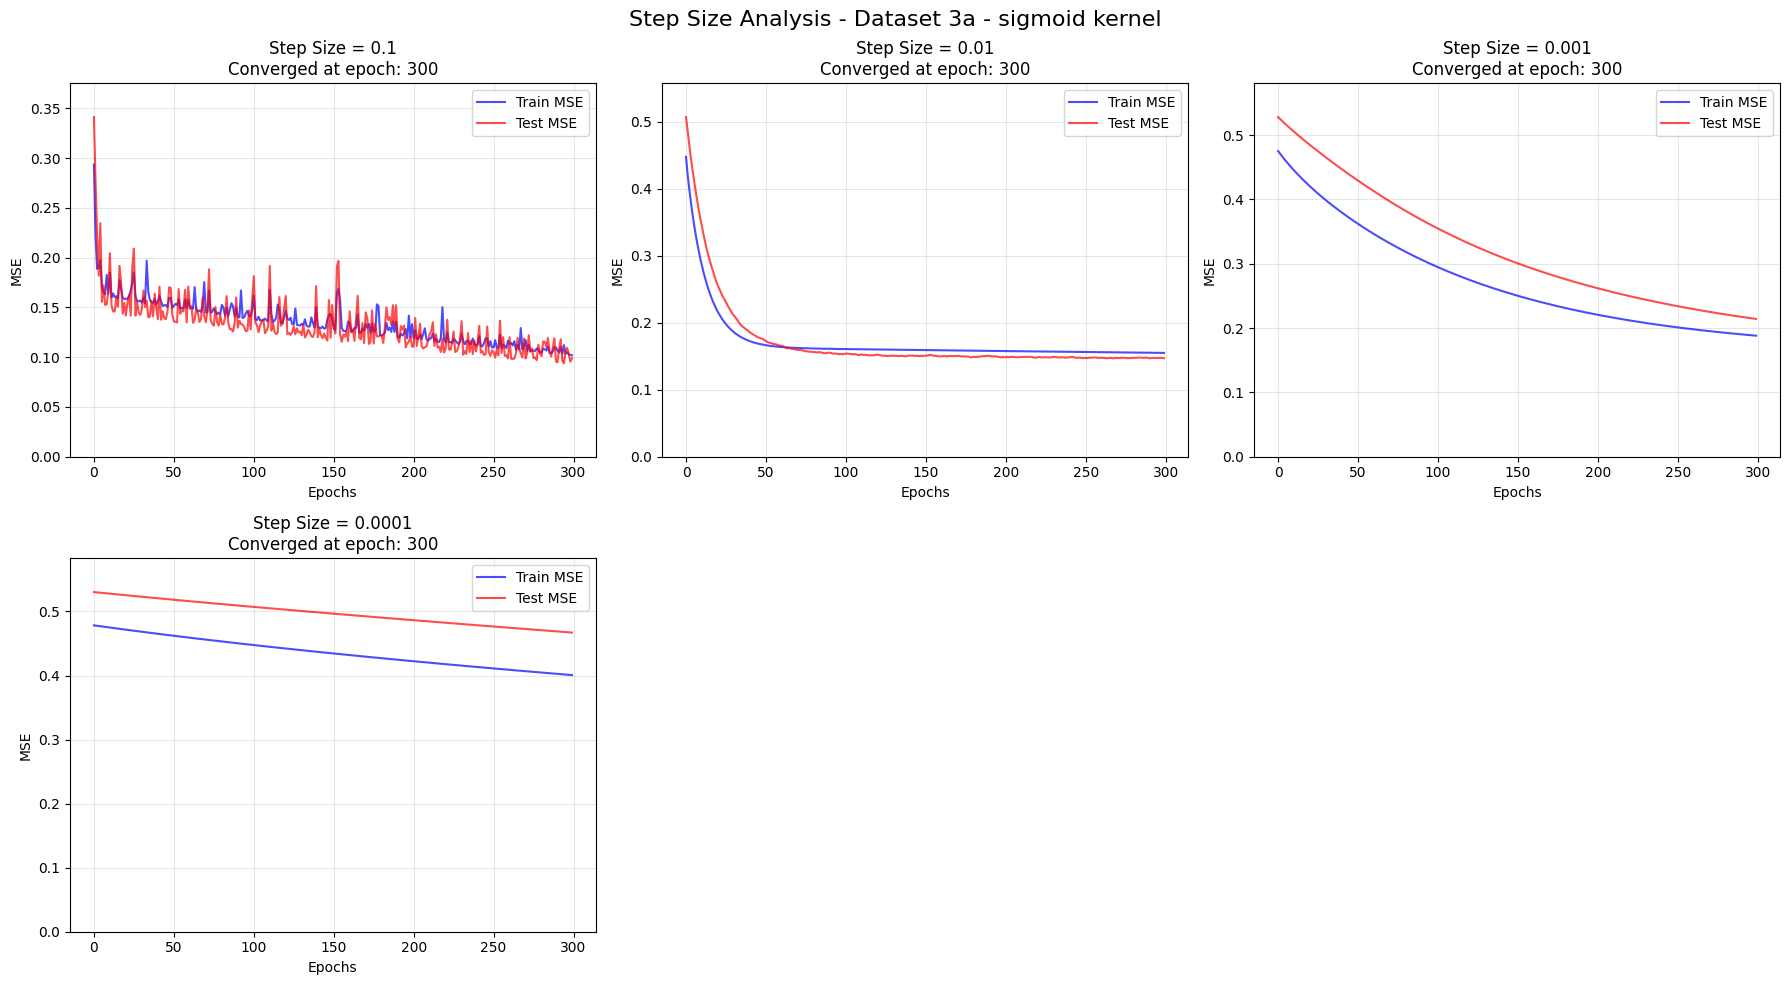

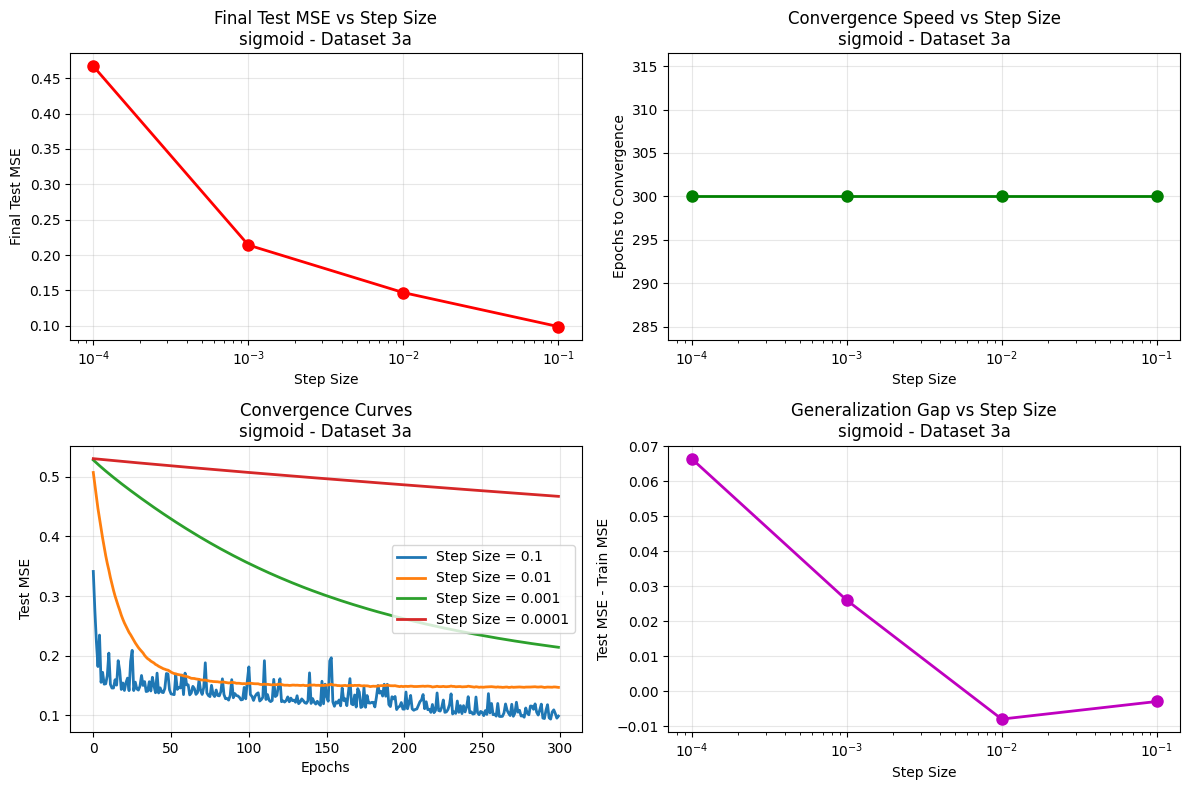


Analyzing dataset 3b

Kernel: polynomial
  Step size: 0.0001
  Step size: 1e-05
  Step size: 1e-06


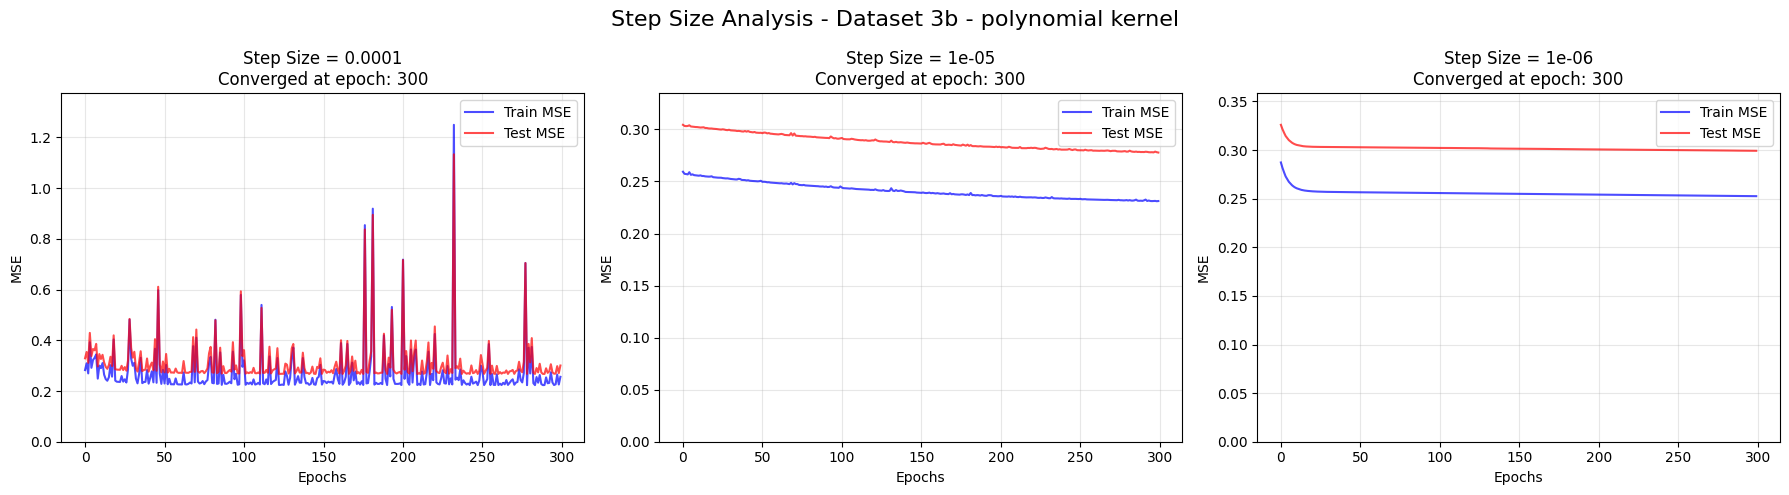

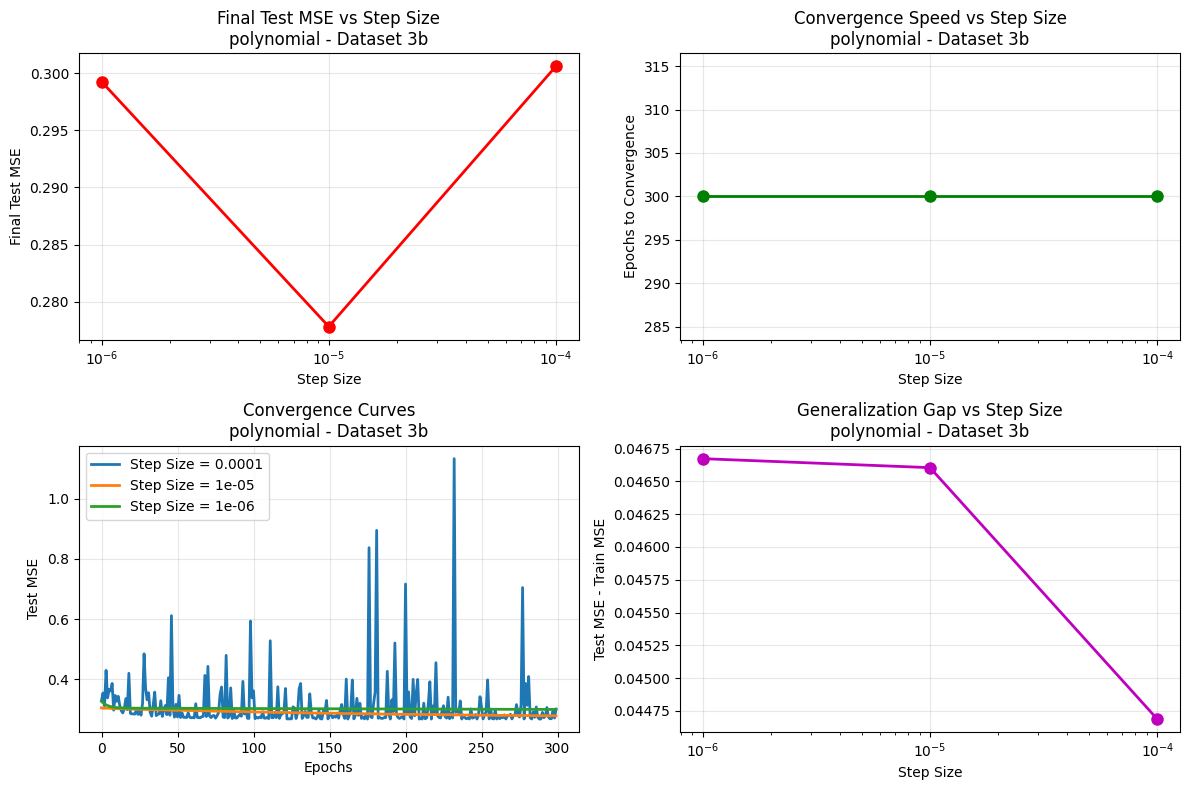


Kernel: gaussian
  Step size: 0.1
  Step size: 0.01
  Step size: 0.001
  Step size: 0.0001
  Step size: 1e-05


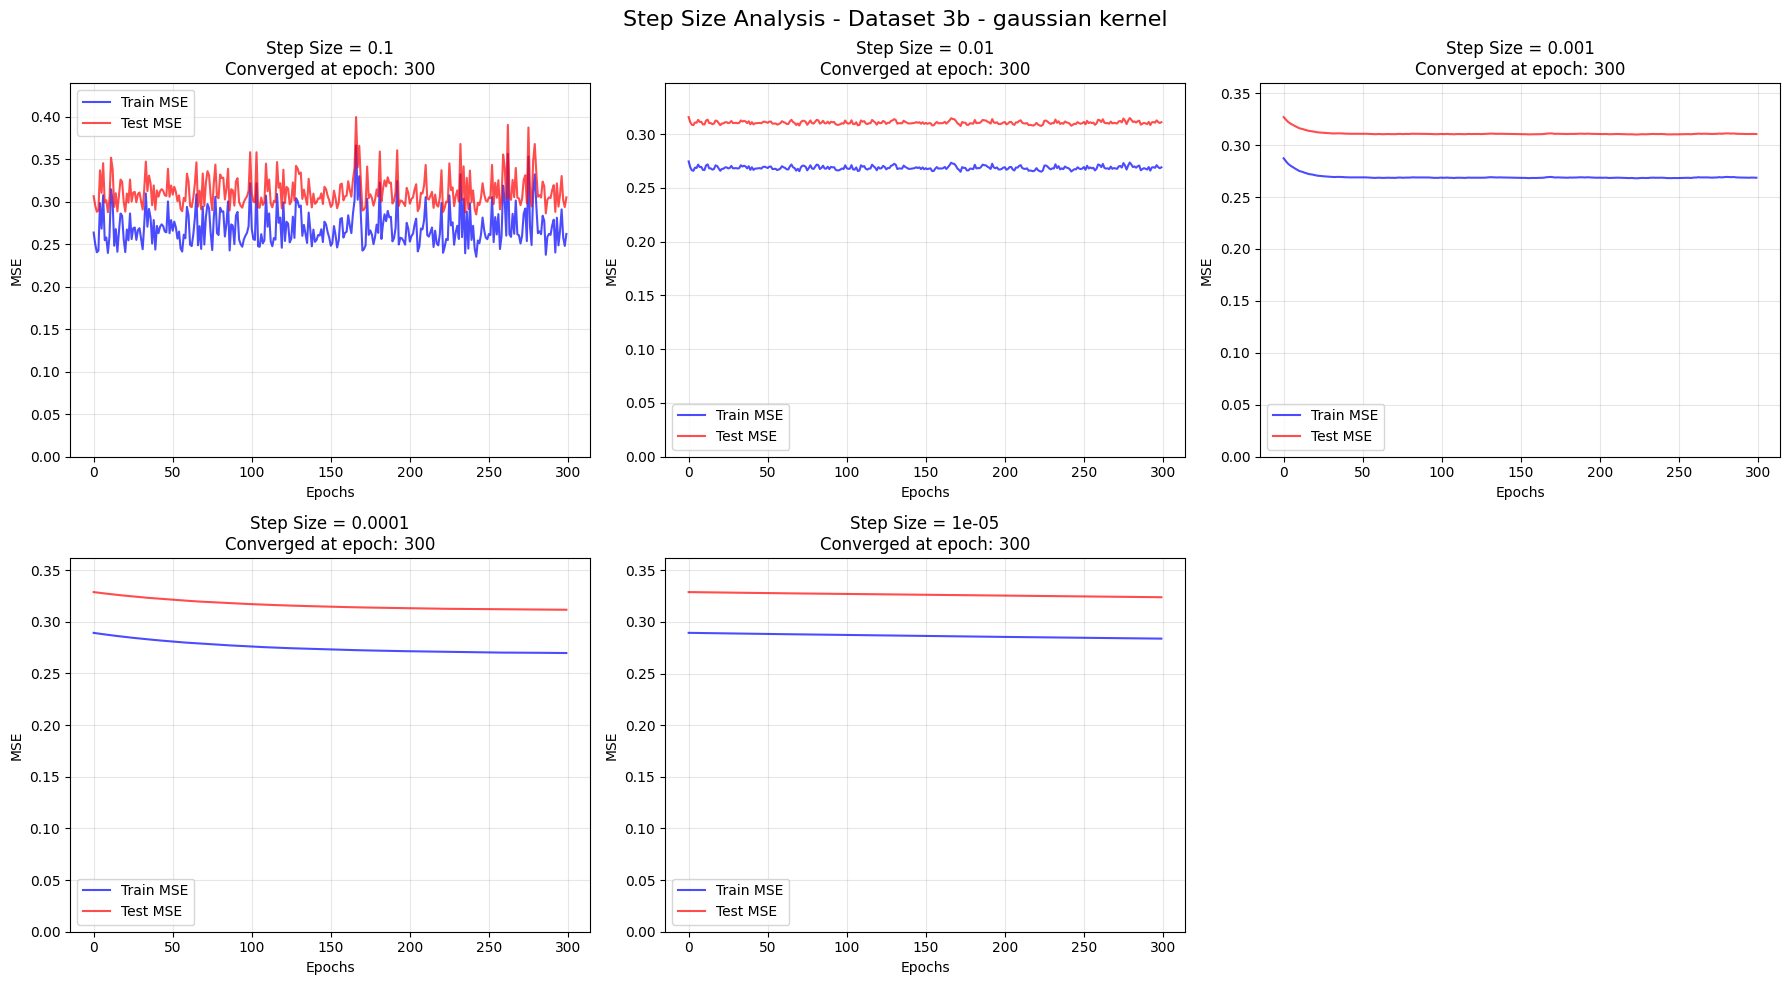

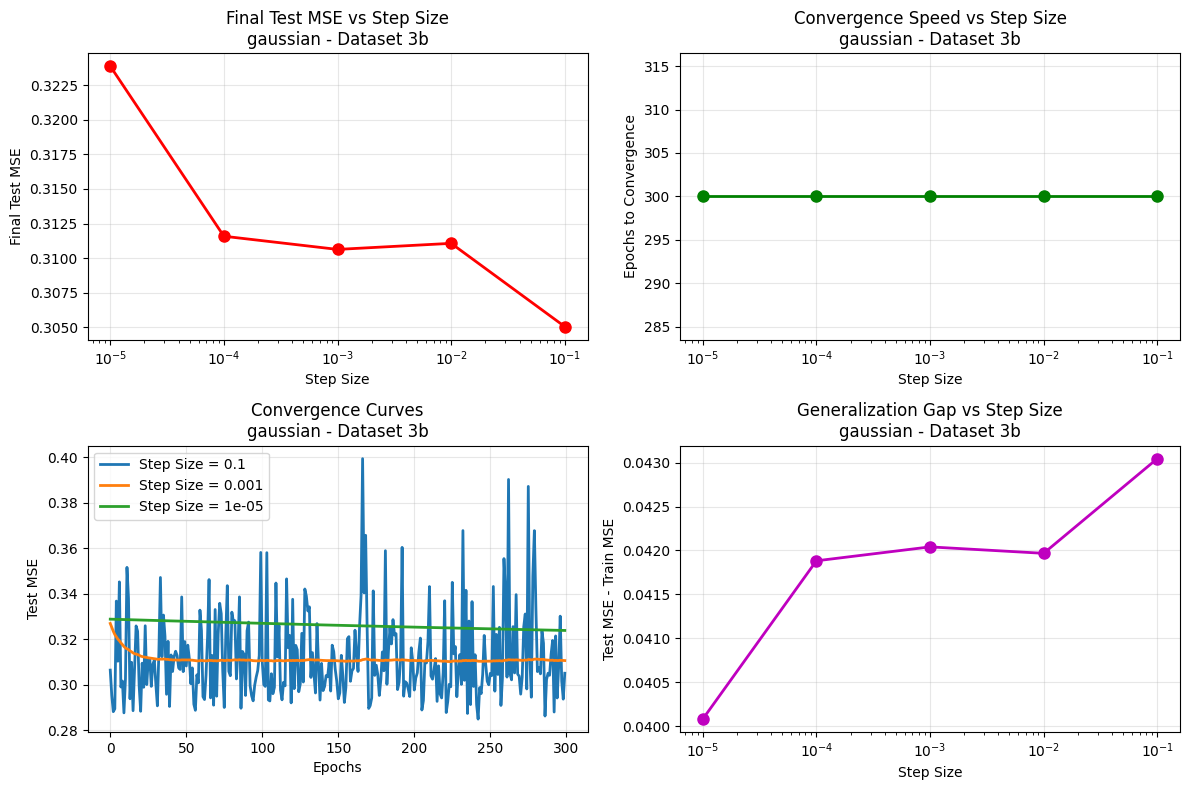


Kernel: sigmoid
  Step size: 0.1
  Step size: 0.01
  Step size: 0.001
  Step size: 0.0001


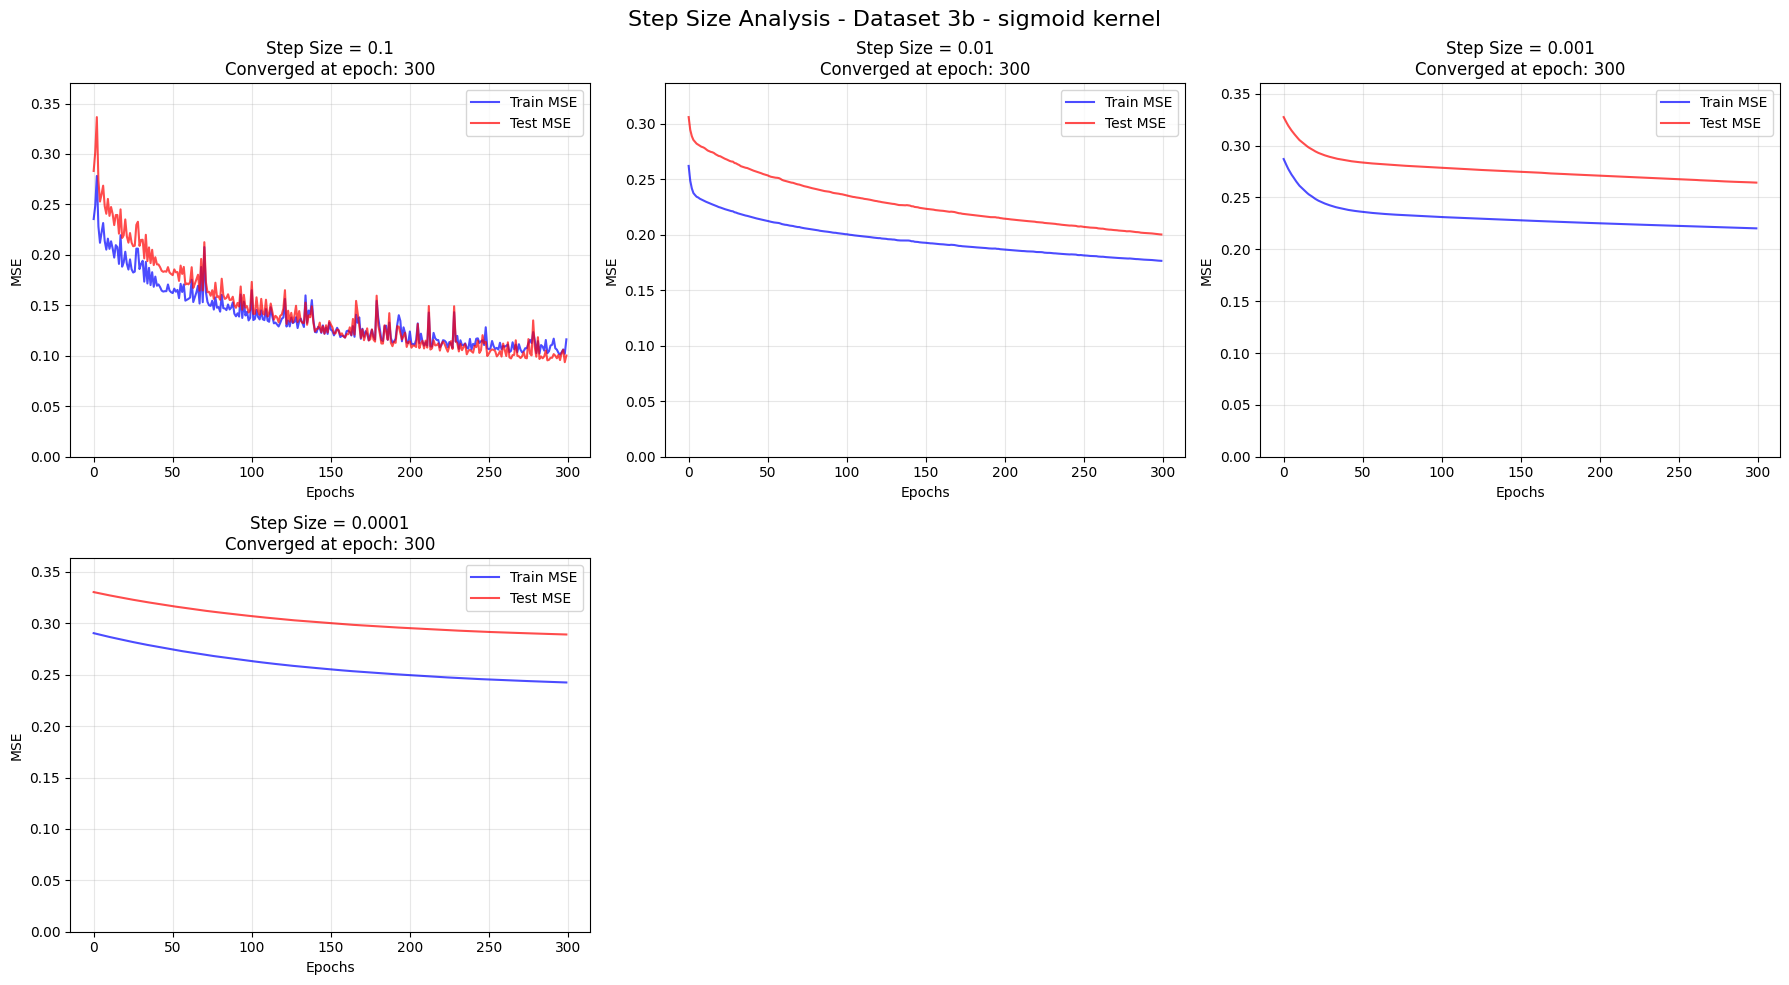

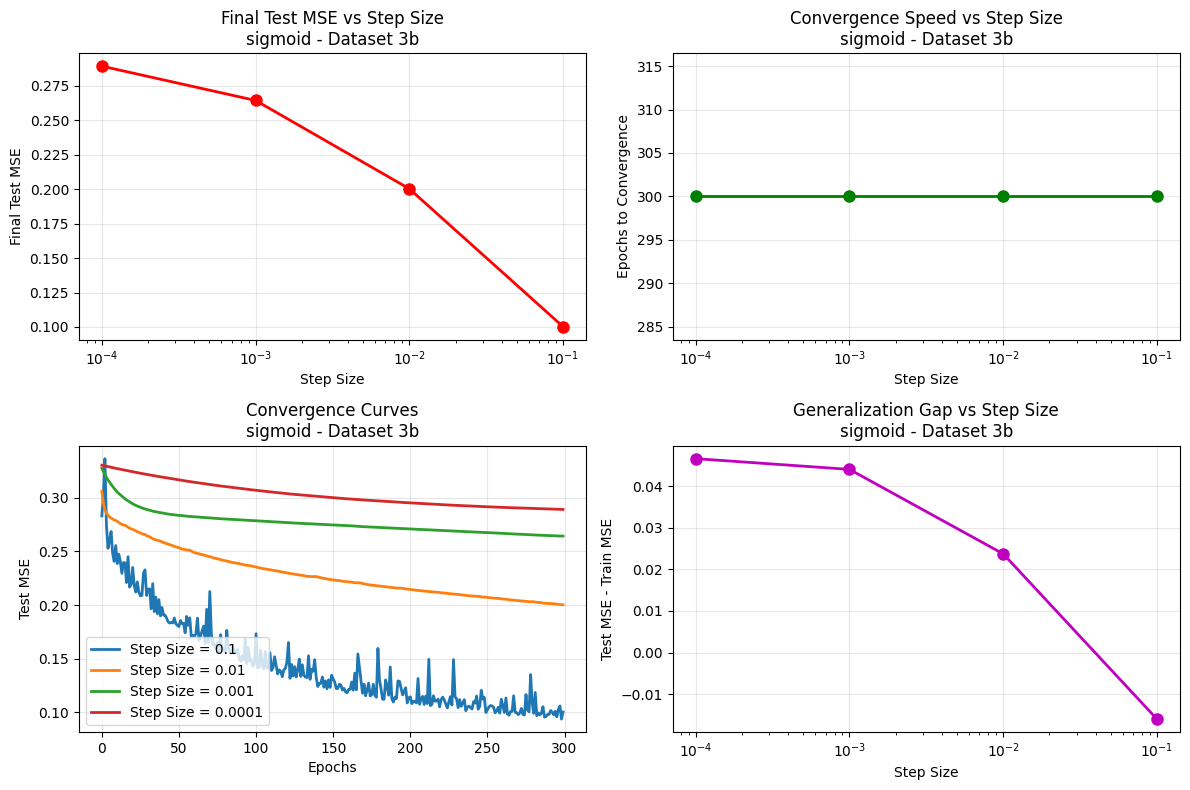


SUMMARY: Best Step Sizes for Each Kernel and Dataset

Dataset 3a:
  polynomial  : Best step size = 0.000100, Test MSE = 0.486104, Converged at epoch 300
  gaussian    : Best step size = 0.000010, Test MSE = 0.527909, Converged at epoch 300
  sigmoid     : Best step size = 0.100000, Test MSE = 0.098978, Converged at epoch 300

Dataset 3b:
  polynomial  : Best step size = 0.000010, Test MSE = 0.277817, Converged at epoch 300
  gaussian    : Best step size = 0.100000, Test MSE = 0.305054, Converged at epoch 300
  sigmoid     : Best step size = 0.100000, Test MSE = 0.100278, Converged at epoch 300


In [126]:
valid_batch_sizes = {}
for dataset_name, (X_train, Y_train, X_test, Y_test) in datasets.items():
    valid_bs = [bs for bs in batch_sizes if bs <= len(X_train)]
    if len(X_train) not in valid_bs:
        valid_bs.append(len(X_train))  # Add full batch
    valid_batch_sizes[dataset_name] = sorted(valid_bs)

print(f"Valid batch sizes for dataset 3a: {valid_batch_sizes['3a']}")
print(f"Valid batch sizes for dataset 3b: {valid_batch_sizes['3b']}")

# Display kernel-specific step sizes
for kernel in kernels:
    print(f"Step sizes for {kernel} kernel: {kernel_step_sizes[kernel]}")

step_size_results = {}

for dataset_name, (X_train, Y_train, X_test, Y_test) in datasets.items():
    print(f"\nAnalyzing dataset {dataset_name}")
    step_size_results[dataset_name] = {}

    for kernel in kernels:
        print(f"\nKernel: {kernel}")
        step_size_results[dataset_name][kernel] = {}

        # Get kernel-specific step sizes
        current_step_sizes = kernel_step_sizes[kernel]

        # Create subplot for this kernel and dataset
        num_step_sizes = len(current_step_sizes)
        cols = min(3, num_step_sizes)
        rows = (num_step_sizes + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
        fig.suptitle(
            f"Step Size Analysis - Dataset {dataset_name} - {kernel} kernel",
            fontsize=16,
        )

        # Handle single subplot case
        if num_step_sizes == 1:
            axes = [axes]
        elif rows == 1:
            axes = (
                axes if isinstance(axes, list) or hasattr(axes, "__len__") else [axes]
            )
        else:
            axes = axes.flatten()

        for idx, step_size in enumerate(current_step_sizes):
            print(f"  Step size: {step_size}")

            # Train with fixed batch size (10 or smaller if dataset is small)
            batch_size = min(10, len(X_train))

            weights, train_errors, test_errors, epochs_to_converge = (
                sgd_training_with_analysis(
                    X_train,
                    Y_train,
                    X_test,
                    Y_test,
                    kernel,
                    M_order,
                    step_size,
                    batch_size,
                    max_epochs,
                )
            )
            step_size_results[dataset_name][kernel][step_size] = {
                "train_errors": train_errors,
                "test_errors": test_errors,
                "epochs_to_converge": epochs_to_converge,
                "final_train_error": train_errors[-1],
                "final_test_error": test_errors[-1],
            }

            # Plot convergence curves
            if idx < len(axes):
                ax = axes[idx]
                epochs_range = range(len(test_errors))
                ax.plot(epochs_range, train_errors, "b-", alpha=0.7, label="Train MSE")
                ax.plot(epochs_range, test_errors, "r-", alpha=0.7, label="Test MSE")
                ax.set_title(
                    f"Step Size = {step_size}\nConverged at epoch: {epochs_to_converge}"
                )
                ax.set_xlabel("Epochs")
                ax.set_ylabel("MSE")
                ax.legend()
                ax.grid(True, alpha=0.3)
                ax.set_ylim(0, min(1.5, max(max(test_errors), max(train_errors)) * 1.1))

        # Remove empty subplots if any
        for idx in range(len(current_step_sizes), len(axes)):
            if idx < len(axes):
                axes[idx].remove()

        plt.tight_layout()
        plt.show()

        # Summary plot for step sizes
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        final_test_errors = [
            step_size_results[dataset_name][kernel][ss]["final_test_error"]
            for ss in current_step_sizes
        ]
        plt.plot(
            current_step_sizes, final_test_errors, "ro-", linewidth=2, markersize=8
        )
        plt.xlabel("Step Size")
        plt.ylabel("Final Test MSE")
        plt.title(f"Final Test MSE vs Step Size\n{kernel} - Dataset {dataset_name}")
        plt.grid(True, alpha=0.3)
        plt.xscale("log")

        plt.subplot(2, 2, 2)
        convergence_epochs = [
            step_size_results[dataset_name][kernel][ss]["epochs_to_converge"]
            for ss in current_step_sizes
        ]
        plt.plot(
            current_step_sizes, convergence_epochs, "go-", linewidth=2, markersize=8
        )
        plt.xlabel("Step Size")
        plt.ylabel("Epochs to Convergence")
        plt.title(f"Convergence Speed vs Step Size\n{kernel} - Dataset {dataset_name}")
        plt.grid(True, alpha=0.3)
        plt.xscale("log")

        plt.subplot(2, 2, 3)
        # Show every other step size to avoid clutter, or all if few step sizes
        step_sizes_to_show = (
            current_step_sizes[::2]
            if len(current_step_sizes) > 4
            else current_step_sizes
        )
        for ss in step_sizes_to_show:
            test_errors = step_size_results[dataset_name][kernel][ss]["test_errors"]
            plt.plot(
                range(len(test_errors)),
                test_errors,
                label=f"Step Size = {ss}",
                linewidth=2,
            )
        plt.xlabel("Epochs")
        plt.ylabel("Test MSE")
        plt.title(f"Convergence Curves\n{kernel} - Dataset {dataset_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        train_test_diff = [
            step_size_results[dataset_name][kernel][ss]["final_test_error"]
            - step_size_results[dataset_name][kernel][ss]["final_train_error"]
            for ss in current_step_sizes
        ]
        plt.plot(current_step_sizes, train_test_diff, "mo-", linewidth=2, markersize=8)
        plt.xlabel("Step Size")
        plt.ylabel("Test MSE - Train MSE")
        plt.title(f"Generalization Gap vs Step Size\n{kernel} - Dataset {dataset_name}")
        plt.grid(True, alpha=0.3)
        plt.xscale("log")

        plt.tight_layout()
        plt.show()

# Print summary of best step sizes for each kernel and dataset
print("\n" + "=" * 60)
print("SUMMARY: Best Step Sizes for Each Kernel and Dataset")
print("=" * 60)

for dataset_name in datasets.keys():
    print(f"\nDataset {dataset_name}:")
    for kernel in kernels:
        current_step_sizes = kernel_step_sizes[kernel]
        best_step_size = min(
            current_step_sizes,
            key=lambda ss: step_size_results[dataset_name][kernel][ss][
                "final_test_error"
            ],
        )
        best_test_error = step_size_results[dataset_name][kernel][best_step_size][
            "final_test_error"
        ]
        convergence_epochs = step_size_results[dataset_name][kernel][best_step_size][
            "epochs_to_converge"
        ]

        print(
            f"  {kernel:12s}: Best step size = {best_step_size:8.6f}, "
            f"Test MSE = {best_test_error:.6f}, Converged at epoch {convergence_epochs}"
        )

### Mini-Batch Size Analysis Summary

1. It prints best step sizes from previous experiments. Uses a fixed or pre-determined optimal `step_size` (e.g., `0.00001`) for all batch size trials.

2. **Batch Size Testing**: Iterates over each dataset and kernel, testing various `batch_size` values (e.g., [1, 5, 10, 25, 50, ...]) to simulate different gradient descent modes — from pure SGD (`batch_size=1`) to full-batch.

3. **Plot Generation**:
   - **Convergence Plots**: Learning curves for each batch size.
   - **Summary Plots**: Visual summaries of test MSE, convergence epochs, generalization gap, total iterations, and computational efficiency.

4. This helps us understand how mini-batch size affects model performance, convergence speed, and generalization.



COMPREHENSIVE BATCH SIZE ANALYSIS

Analyzing dataset 3a

Kernel: polynomial
  Batch size: 1
  Batch size: 5
  Batch size: 10
  Batch size: 25
  Batch size: 50


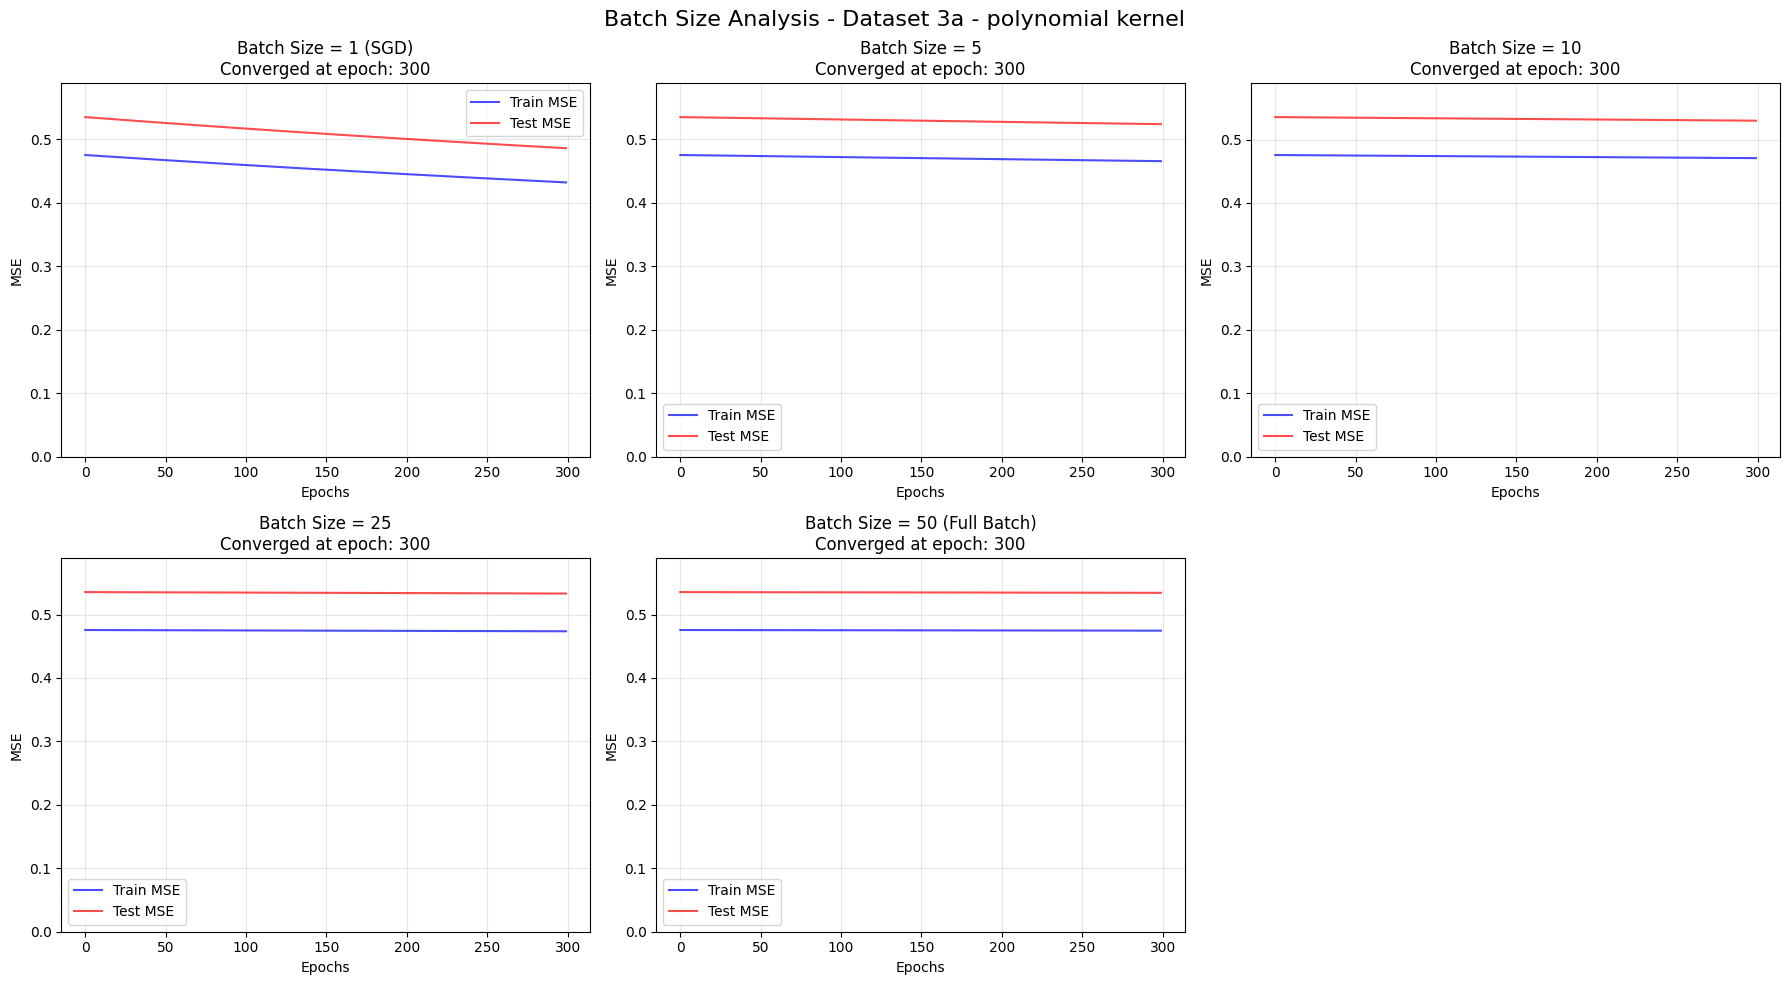

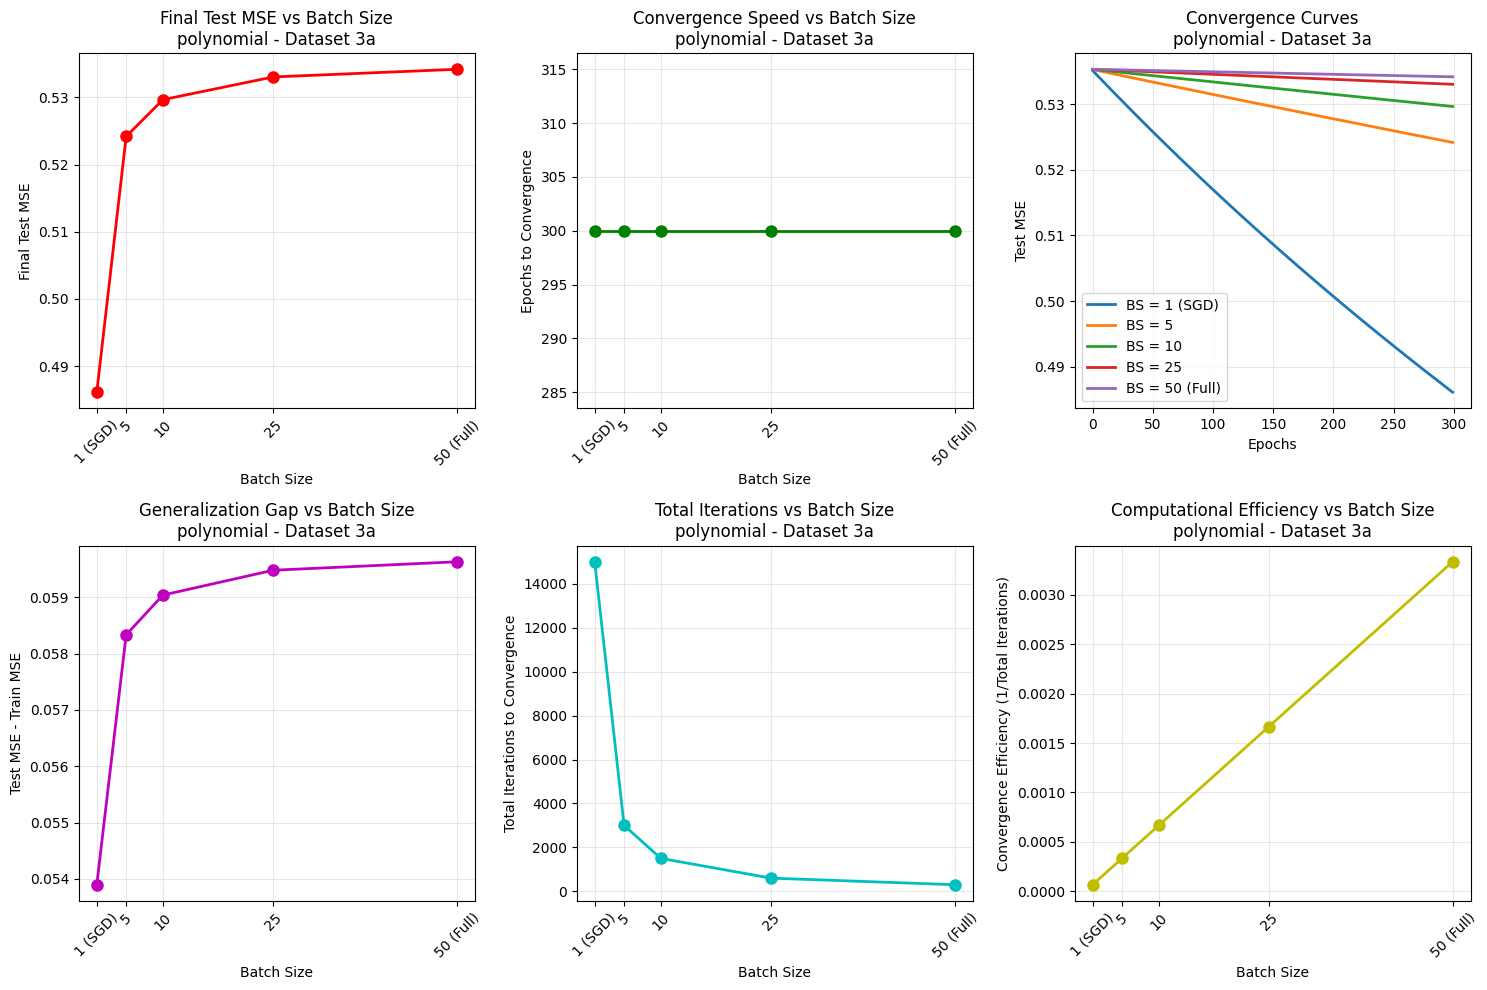


Kernel: gaussian
  Batch size: 1
  Batch size: 5
  Batch size: 10
  Batch size: 25
  Batch size: 50


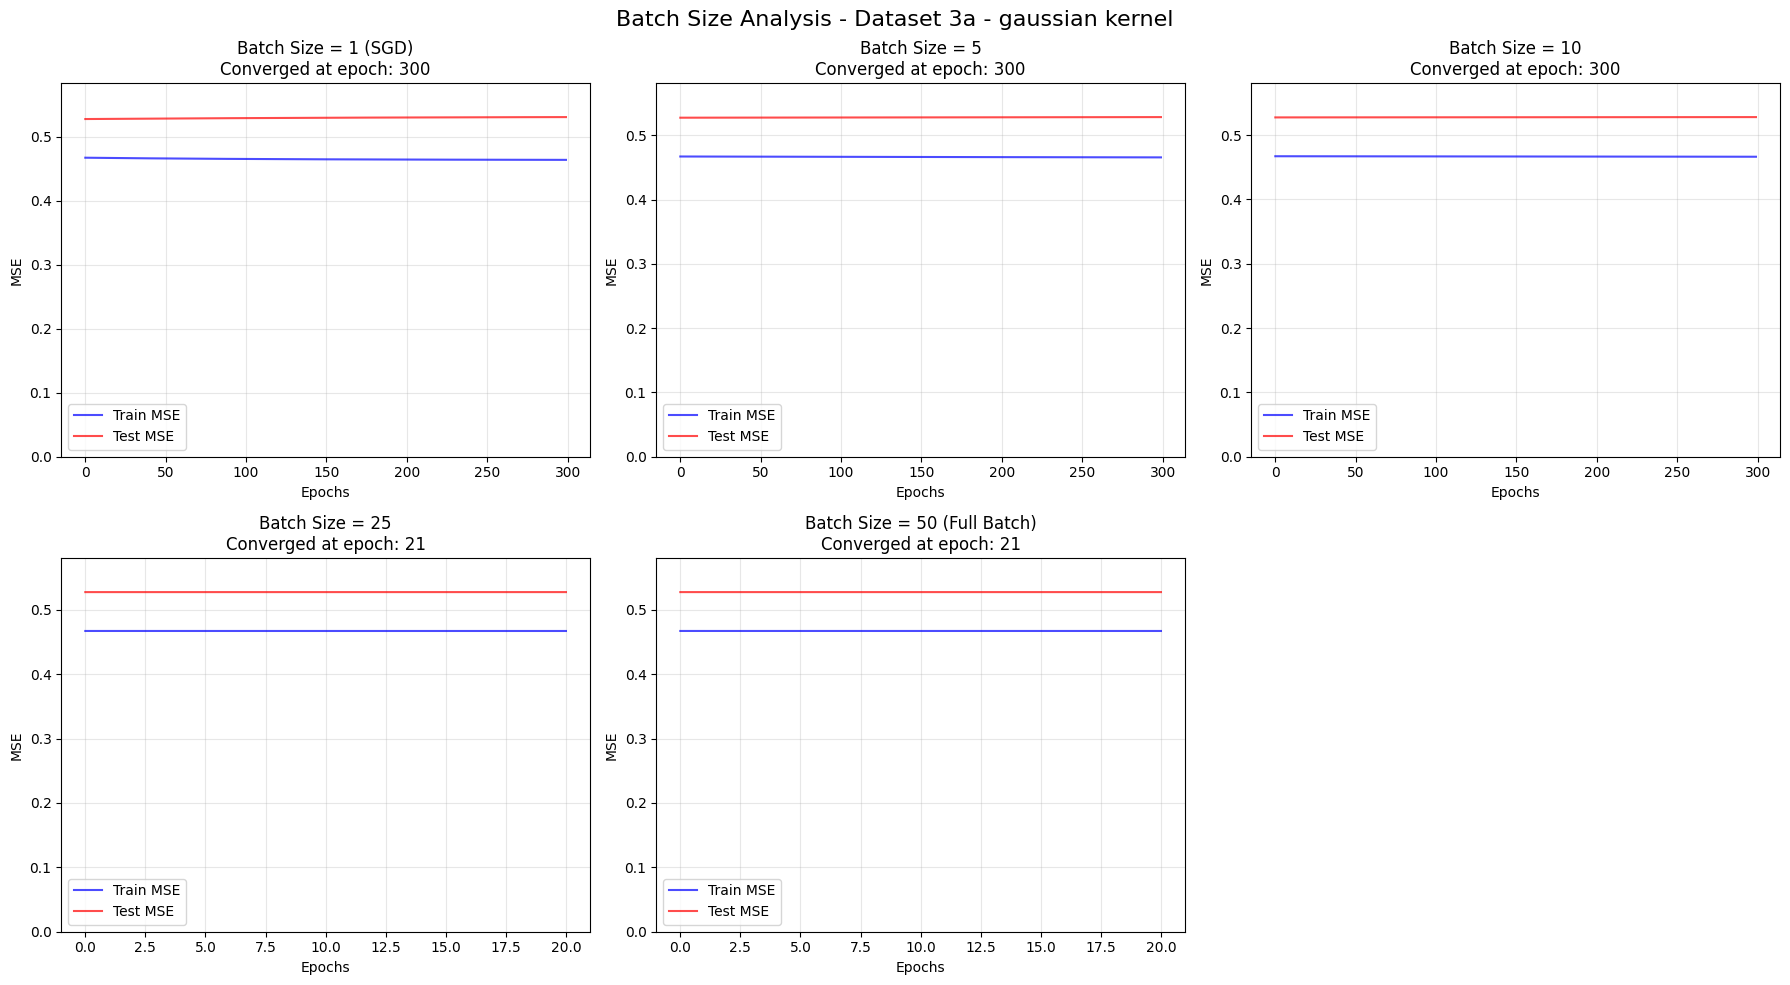

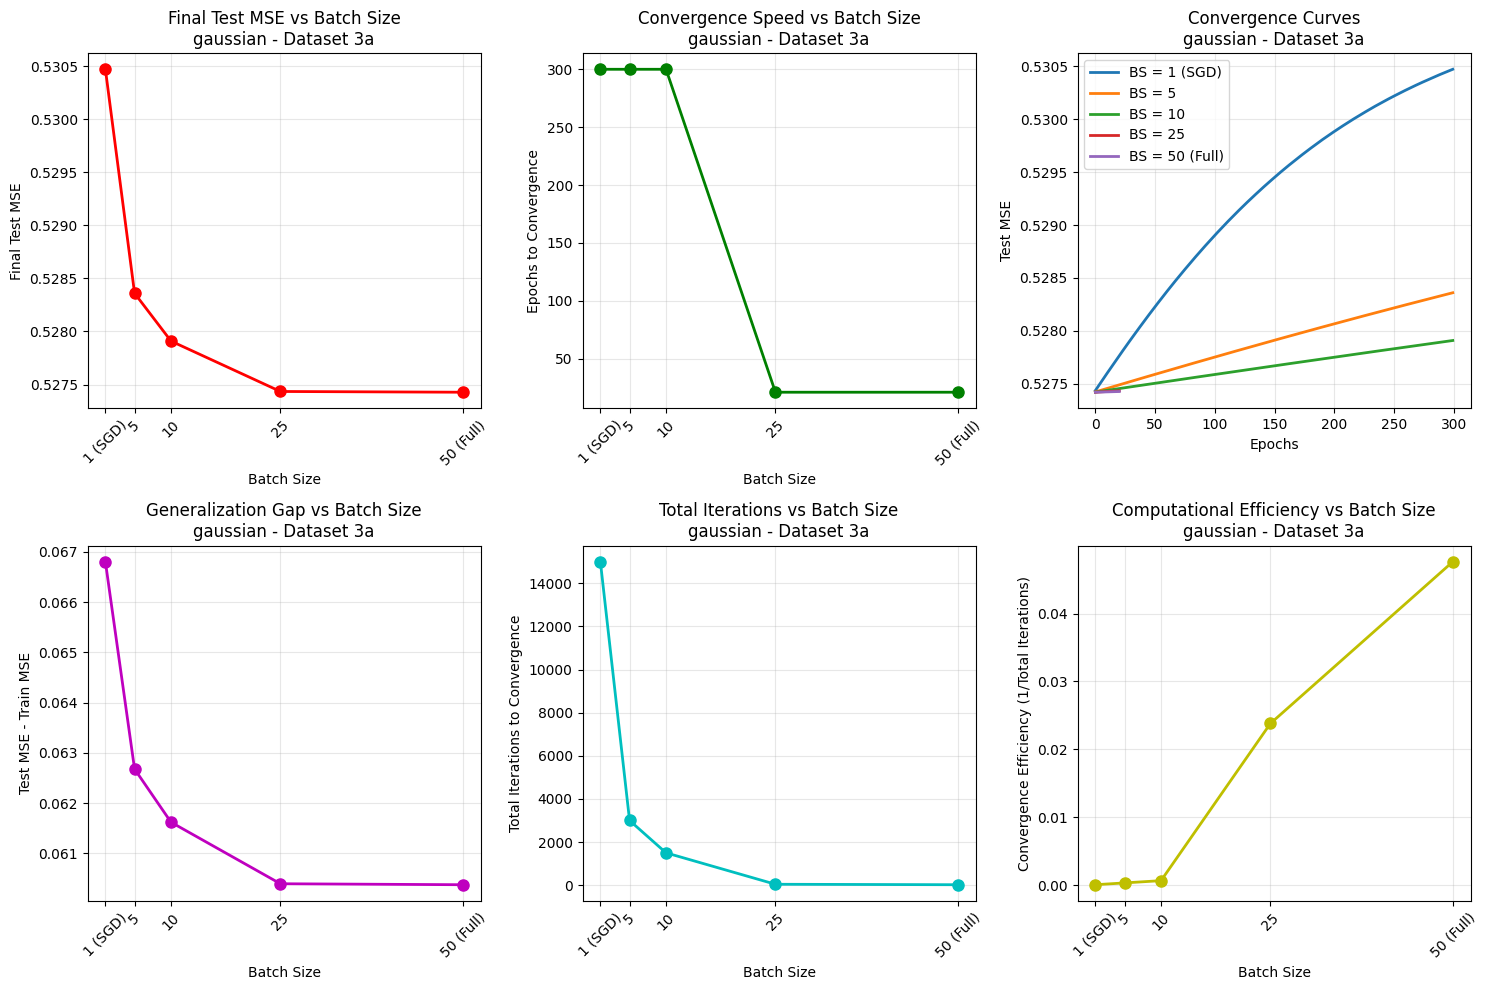


Kernel: sigmoid
  Batch size: 1
  Batch size: 5
  Batch size: 10
  Batch size: 25
  Batch size: 50


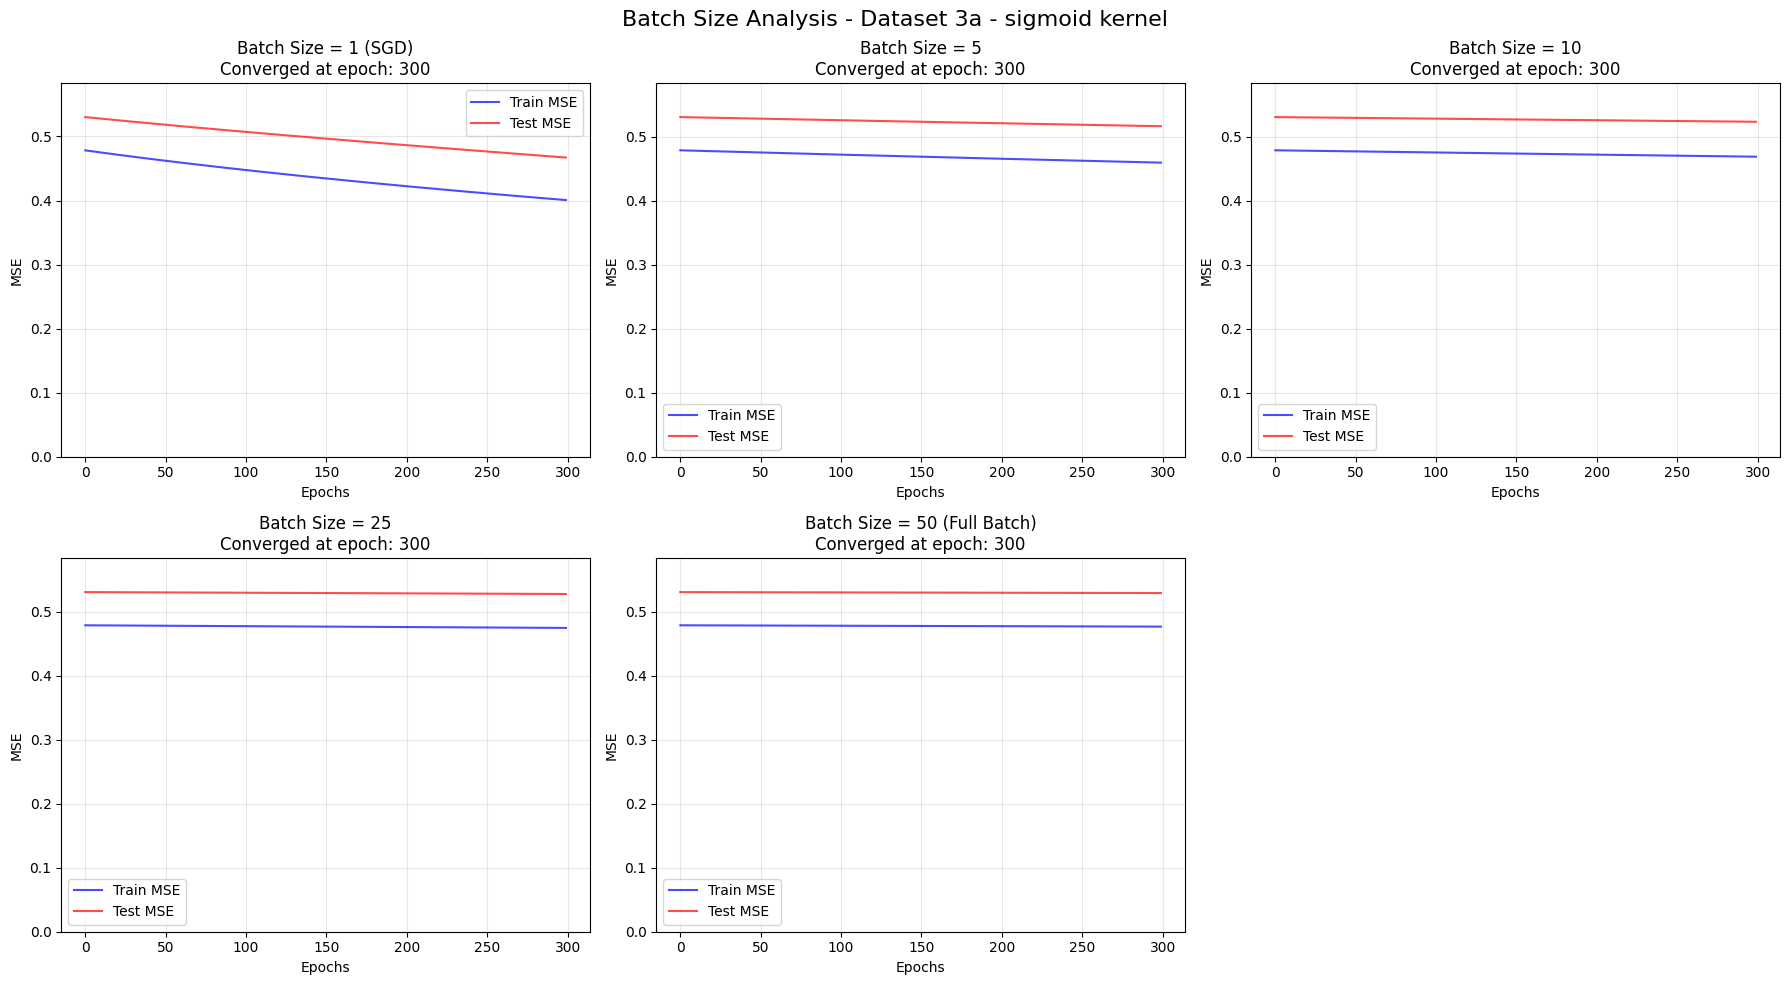

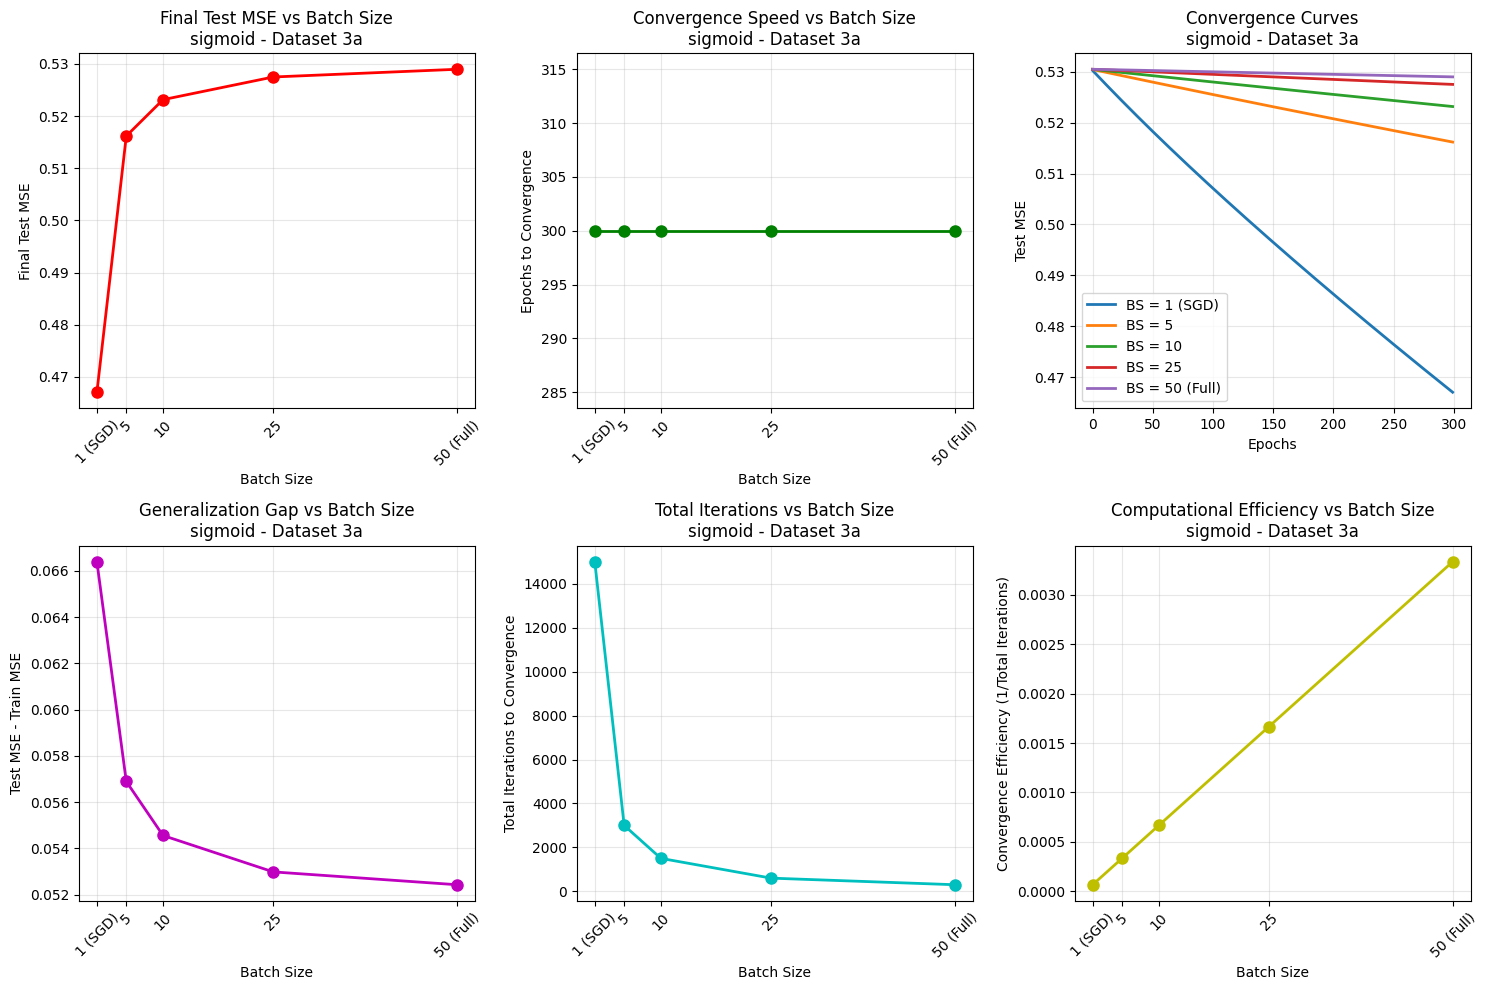


Analyzing dataset 3b

Kernel: polynomial
  Batch size: 1
  Batch size: 5
  Batch size: 10
  Batch size: 25
  Batch size: 50
  Batch size: 75


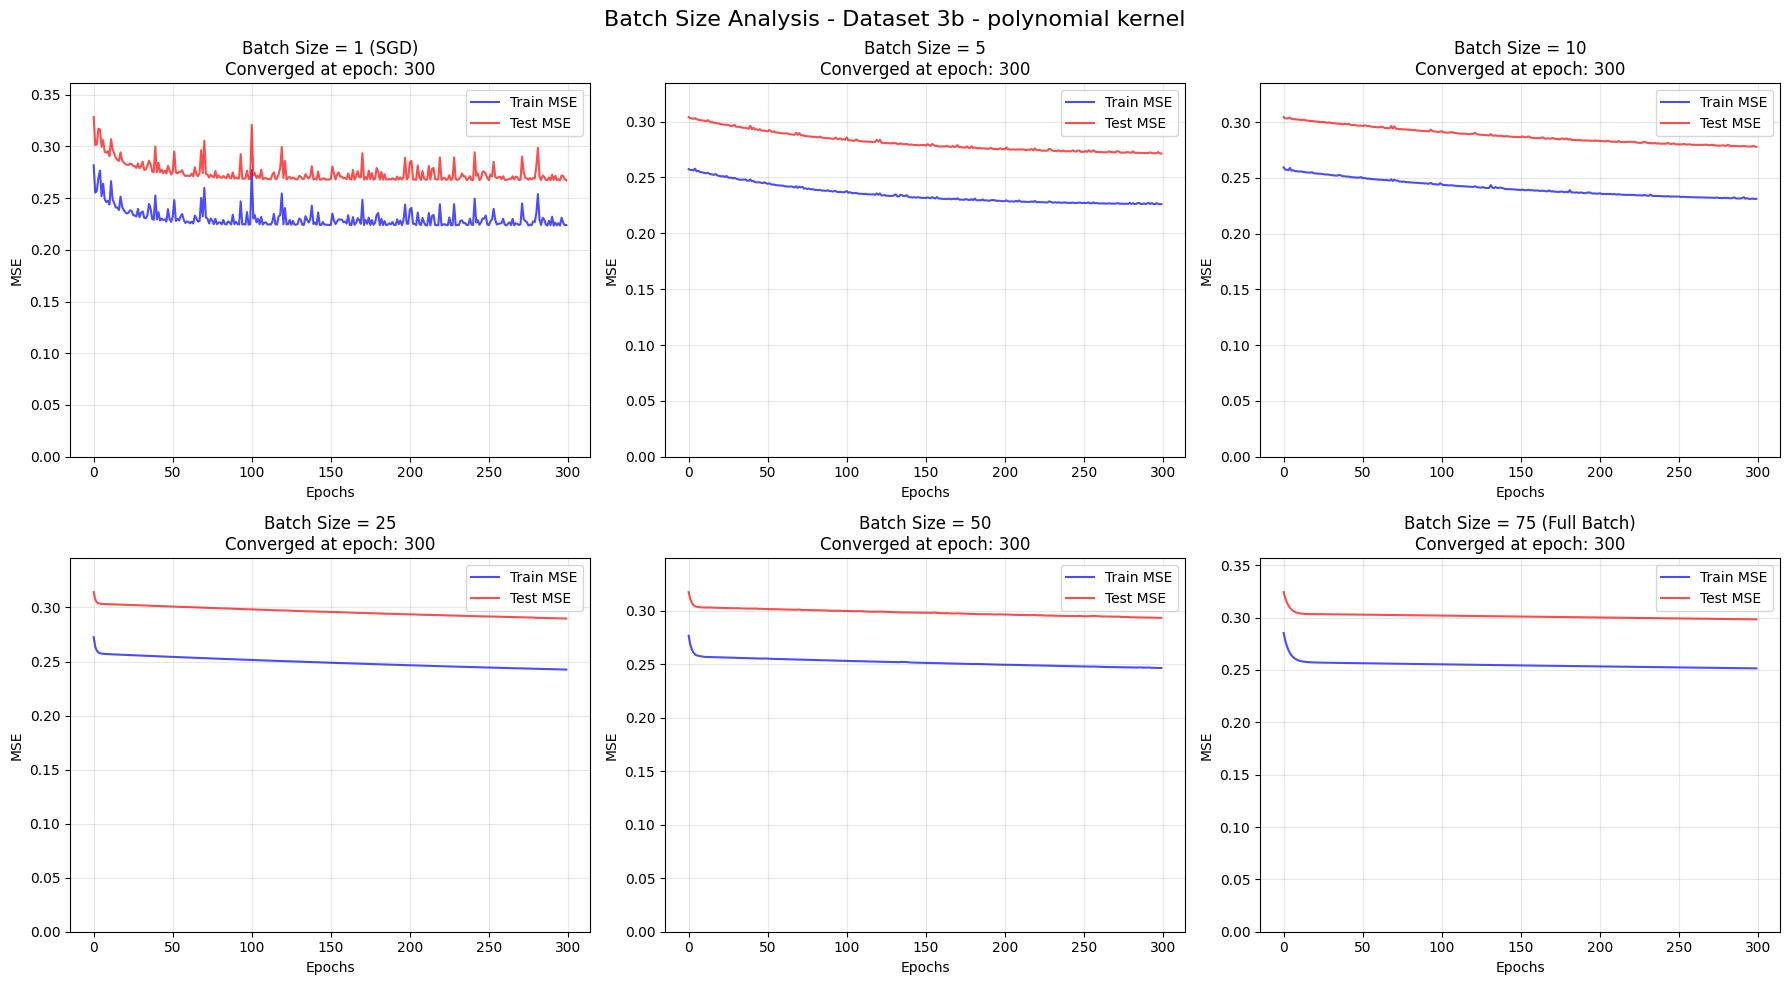

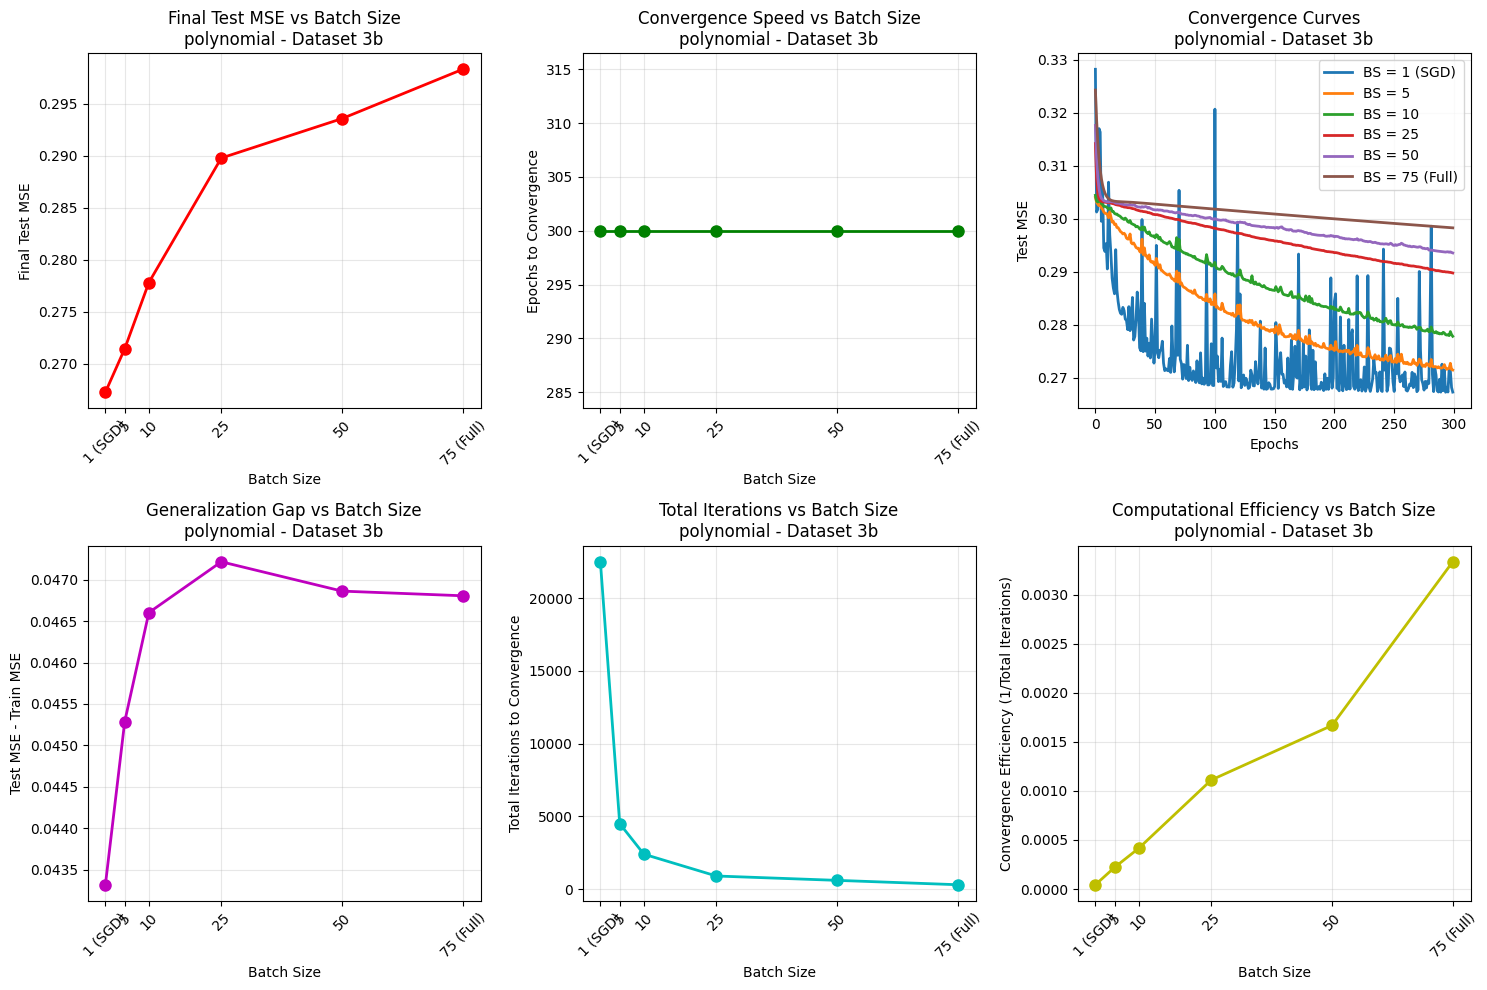


Kernel: gaussian
  Batch size: 1
  Batch size: 5
  Batch size: 10
  Batch size: 25
  Batch size: 50
  Batch size: 75


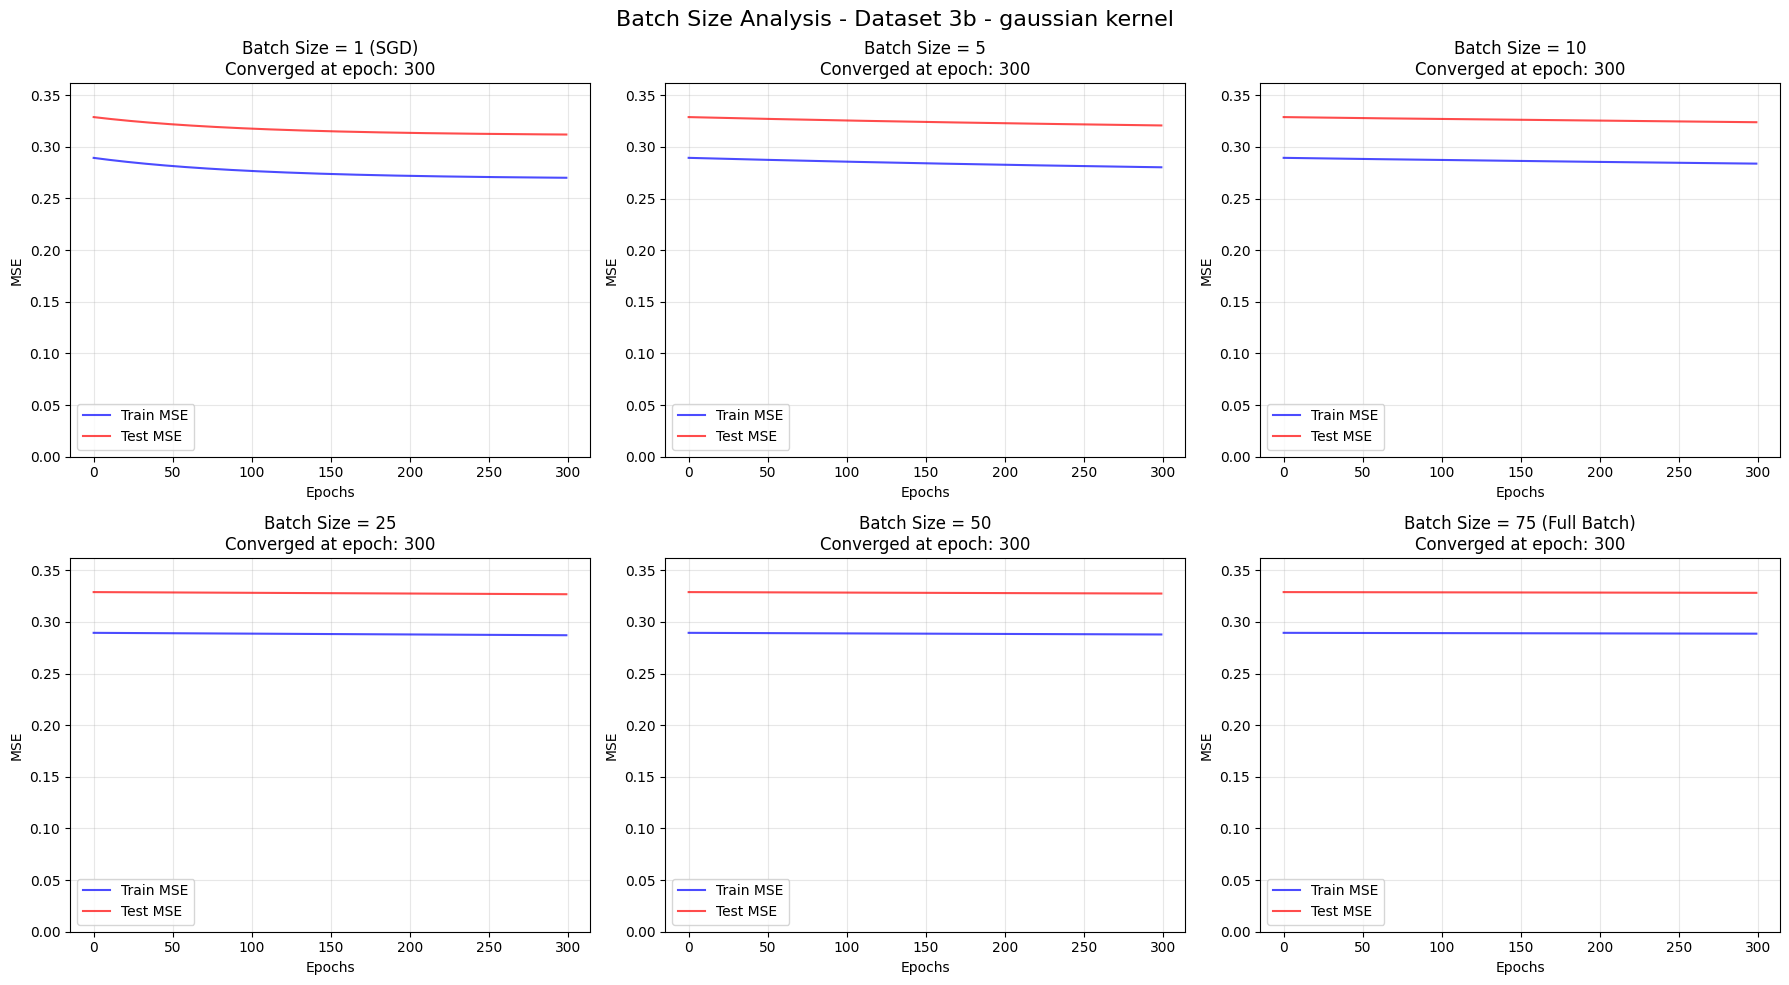

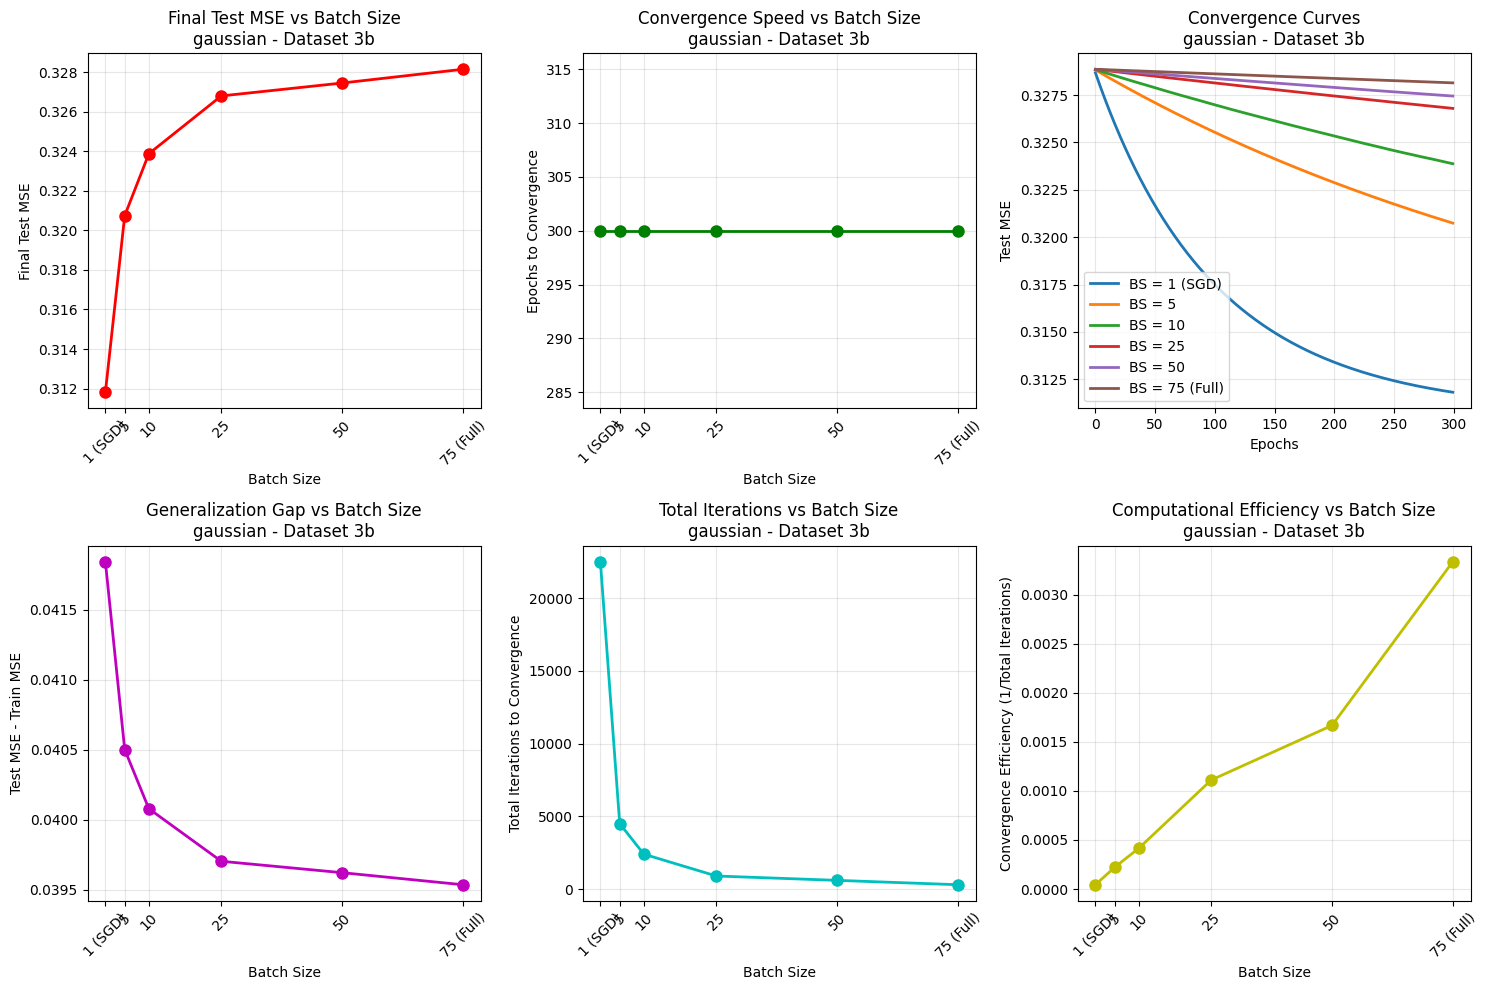


Kernel: sigmoid
  Batch size: 1
  Batch size: 5
  Batch size: 10
  Batch size: 25
  Batch size: 50
  Batch size: 75


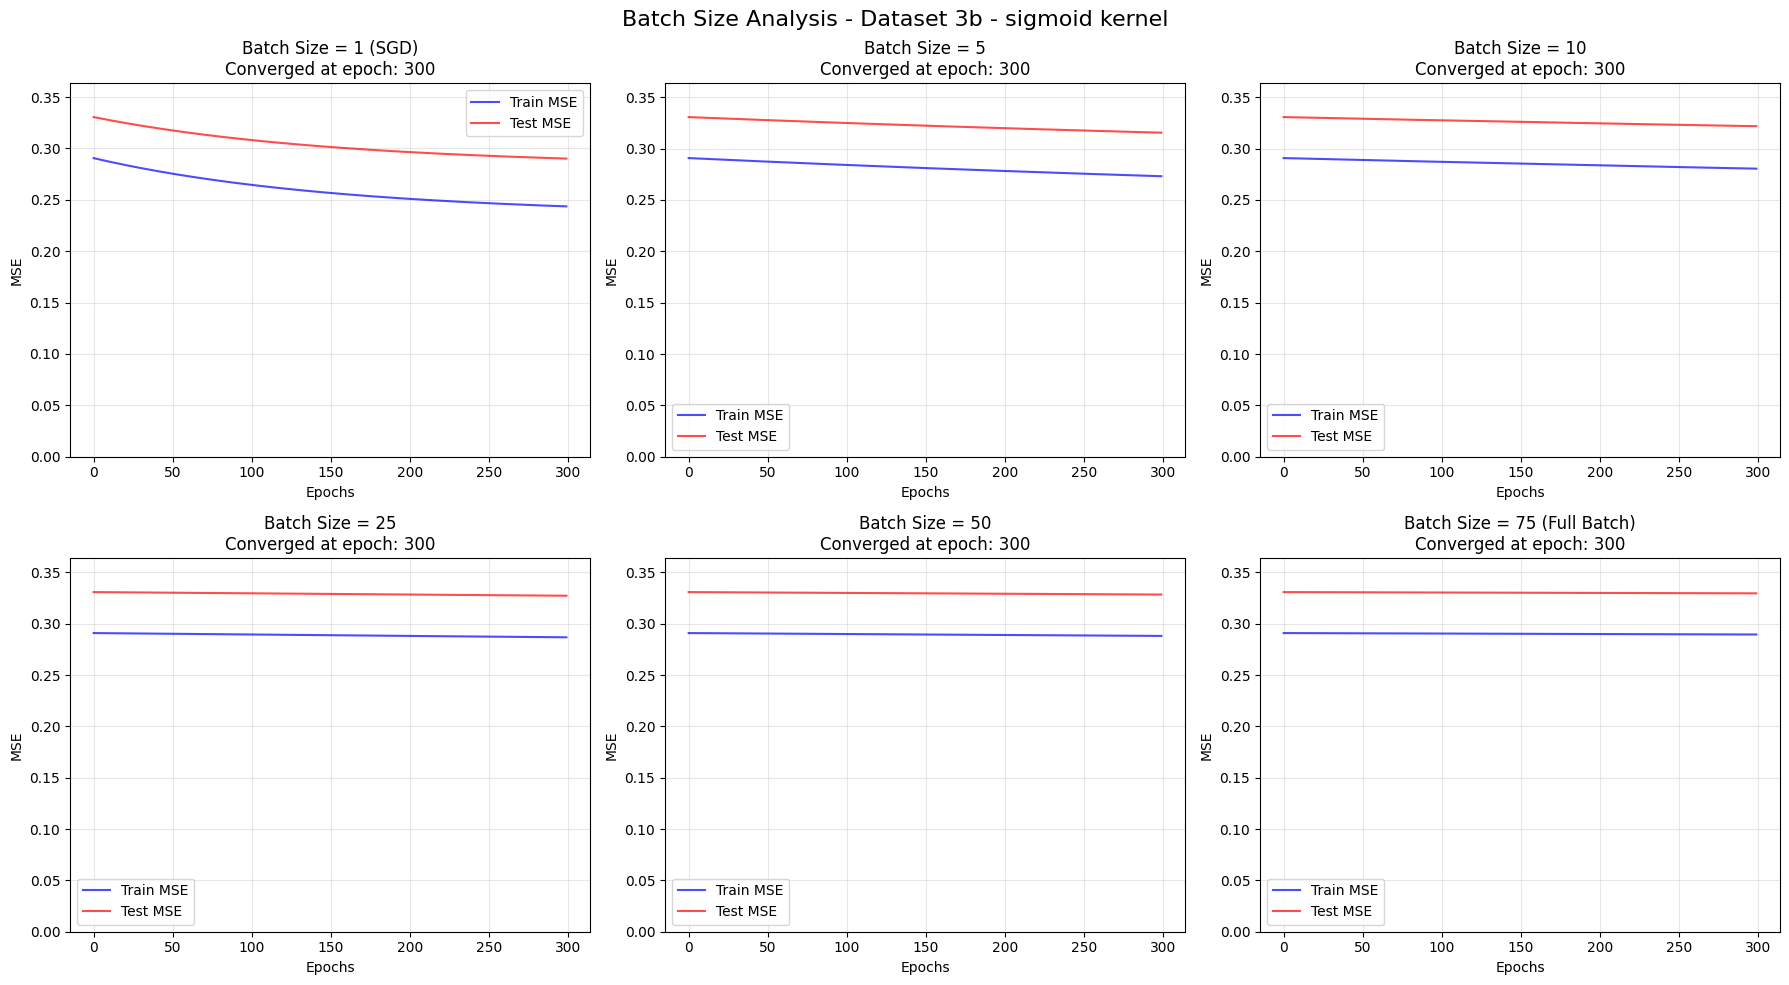

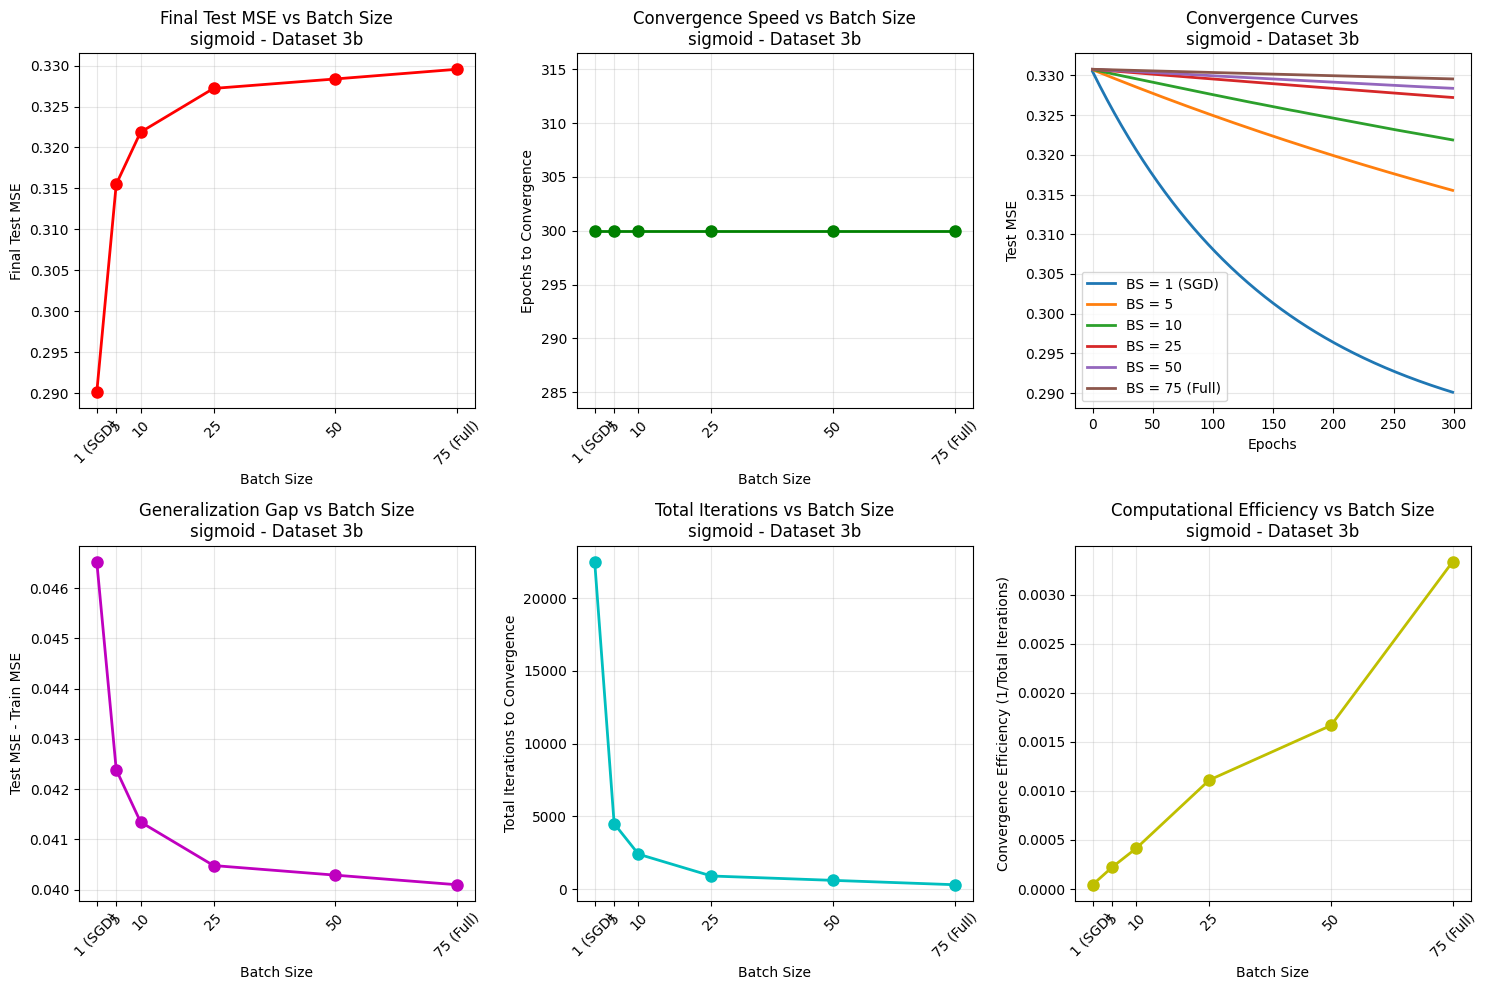

In [127]:
# COMPREHENSIVE BATCH SIZE ANALYSIS
print("\n" + "=" * 60)
print("COMPREHENSIVE BATCH SIZE ANALYSIS")
print("=" * 60)

batch_size_results = {}

for dataset_name, (X_train, Y_train, X_test, Y_test) in datasets.items():
    print(f"\nAnalyzing dataset {dataset_name}")
    batch_size_results[dataset_name] = {}

    for kernel in kernels:
        print(f"\nKernel: {kernel}")
        batch_size_results[dataset_name][kernel] = {}

        # Use optimal step size from previous analysis
        optimal_step_size = (
            0.00001  # You can adjust this based on step size analysis results
        )

        # Create subplot for this kernel and dataset
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(
            f"Batch Size Analysis - Dataset {dataset_name} - {kernel} kernel",
            fontsize=16,
        )

        valid_bs = valid_batch_sizes[dataset_name]

        for idx, batch_size in enumerate(valid_bs[:6]):  # Limit to 6 for subplot layout
            print(f"  Batch size: {batch_size}")

            weights, train_errors, test_errors, epochs_to_converge = (
                sgd_training_with_analysis(
                    X_train,
                    Y_train,
                    X_test,
                    Y_test,
                    kernel,
                    M_order,
                    optimal_step_size,
                    batch_size,
                    max_epochs,
                )
            )

            batch_size_results[dataset_name][kernel][batch_size] = {
                "train_errors": train_errors,
                "test_errors": test_errors,
                "epochs_to_converge": epochs_to_converge,
                "final_train_error": train_errors[-1],
                "final_test_error": test_errors[-1],
            }

            # Plot convergence curves
            if idx < 6:
                ax = axes[idx // 3, idx % 3]
                epochs_range = range(len(test_errors))
                ax.plot(epochs_range, train_errors, "b-", alpha=0.7, label="Train MSE")
                ax.plot(epochs_range, test_errors, "r-", alpha=0.7, label="Test MSE")

                batch_label = f"Batch Size = {batch_size}"
                if batch_size == 1:
                    batch_label += " (SGD)"
                elif batch_size == len(X_train):
                    batch_label += " (Full Batch)"

                ax.set_title(f"{batch_label}\nConverged at epoch: {epochs_to_converge}")
                ax.set_xlabel("Epochs")
                ax.set_ylabel("MSE")
                ax.legend()
                ax.grid(True, alpha=0.3)
                ax.set_ylim(0, min(1.5, max(max(test_errors), max(train_errors)) * 1.1))

        # Remove empty subplots
        for idx in range(len(valid_bs[:6]), 6):
            if idx // 3 < 2 and idx % 3 < 3:
                axes[idx // 3, idx % 3].remove()

        plt.tight_layout()
        plt.show()

        # Summary plot for batch sizes
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 3, 1)
        final_test_errors = [
            batch_size_results[dataset_name][kernel][bs]["final_test_error"]
            for bs in valid_bs
        ]
        batch_labels = [
            f"{bs}" + (" (SGD)" if bs == 1 else " (Full)" if bs == len(X_train) else "")
            for bs in valid_bs
        ]
        plt.plot(valid_bs, final_test_errors, "ro-", linewidth=2, markersize=8)
        plt.xlabel("Batch Size")
        plt.ylabel("Final Test MSE")
        plt.title(f"Final Test MSE vs Batch Size\n{kernel} - Dataset {dataset_name}")
        plt.grid(True, alpha=0.3)
        plt.xticks(valid_bs, batch_labels, rotation=45)

        plt.subplot(2, 3, 2)
        convergence_epochs = [
            batch_size_results[dataset_name][kernel][bs]["epochs_to_converge"]
            for bs in valid_bs
        ]
        plt.plot(valid_bs, convergence_epochs, "go-", linewidth=2, markersize=8)
        plt.xlabel("Batch Size")
        plt.ylabel("Epochs to Convergence")
        plt.title(f"Convergence Speed vs Batch Size\n{kernel} - Dataset {dataset_name}")
        plt.grid(True, alpha=0.3)
        plt.xticks(valid_bs, batch_labels, rotation=45)

        plt.subplot(2, 3, 3)
        for bs in valid_bs[
            :: max(1, len(valid_bs) // 4)
        ]:  # Show representative batch sizes
            test_errors = batch_size_results[dataset_name][kernel][bs]["test_errors"]
            label = f"BS = {bs}"
            if bs == 1:
                label += " (SGD)"
            elif bs == len(X_train):
                label += " (Full)"
            plt.plot(range(len(test_errors)), test_errors, label=label, linewidth=2)
        plt.xlabel("Epochs")
        plt.ylabel("Test MSE")
        plt.title(f"Convergence Curves\n{kernel} - Dataset {dataset_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 3, 4)
        train_test_diff = [
            batch_size_results[dataset_name][kernel][bs]["final_test_error"]
            - batch_size_results[dataset_name][kernel][bs]["final_train_error"]
            for bs in valid_bs
        ]
        plt.plot(valid_bs, train_test_diff, "mo-", linewidth=2, markersize=8)
        plt.xlabel("Batch Size")
        plt.ylabel("Test MSE - Train MSE")
        plt.title(
            f"Generalization Gap vs Batch Size\n{kernel} - Dataset {dataset_name}"
        )
        plt.grid(True, alpha=0.3)
        plt.xticks(valid_bs, batch_labels, rotation=45)

        plt.subplot(2, 3, 5)
        # Iterations per epoch analysis
        iterations_per_epoch = [
            len(X_train) // bs + (1 if len(X_train) % bs != 0 else 0) for bs in valid_bs
        ]
        total_iterations = [
            convergence_epochs[i] * iterations_per_epoch[i]
            for i in range(len(valid_bs))
        ]
        plt.plot(valid_bs, total_iterations, "co-", linewidth=2, markersize=8)
        plt.xlabel("Batch Size")
        plt.ylabel("Total Iterations to Convergence")
        plt.title(f"Total Iterations vs Batch Size\n{kernel} - Dataset {dataset_name}")
        plt.grid(True, alpha=0.3)
        plt.xticks(valid_bs, batch_labels, rotation=45)

        plt.subplot(2, 3, 6)
        # Computational efficiency (convergence per iteration)
        efficiency = [
            1.0 / total_iterations[i] if total_iterations[i] > 0 else 0
            for i in range(len(valid_bs))
        ]
        plt.plot(valid_bs, efficiency, "yo-", linewidth=2, markersize=8)
        plt.xlabel("Batch Size")
        plt.ylabel("Convergence Efficiency (1/Total Iterations)")
        plt.title(
            f"Computational Efficiency vs Batch Size\n{kernel} - Dataset {dataset_name}"
        )
        plt.grid(True, alpha=0.3)
        plt.xticks(valid_bs, batch_labels, rotation=45)

        plt.tight_layout()
        plt.show()

### Observations

- Noise: Smaller batch sizes (especially batch_size=1, SGD) result in much noisier convergence curves, whereas larger batch sizes are smoother.

- Final MSE: Very small batches can sometimes find better (lower MSE) solutions due to their noise helping escape local minima, but they can also be unstable. Very large batches are stable but may get stuck.

- Convergence Speed (Epochs): Larger batch sizes often converge in fewer epochs because each update is based on more information.

- Total Iterations & Efficiency: Smaller batch sizes require far more total updates (iterations) to converge, making them less computationally efficient overall, even if they converge in more epochs. The plots show a clear trade-off between final performance and computational cost. For most cases, a mini-batch size between 5 and 25 gives a good balance.


CROSS-KERNEL COMPARISON

Dataset 3a - Cross-Kernel Analysis


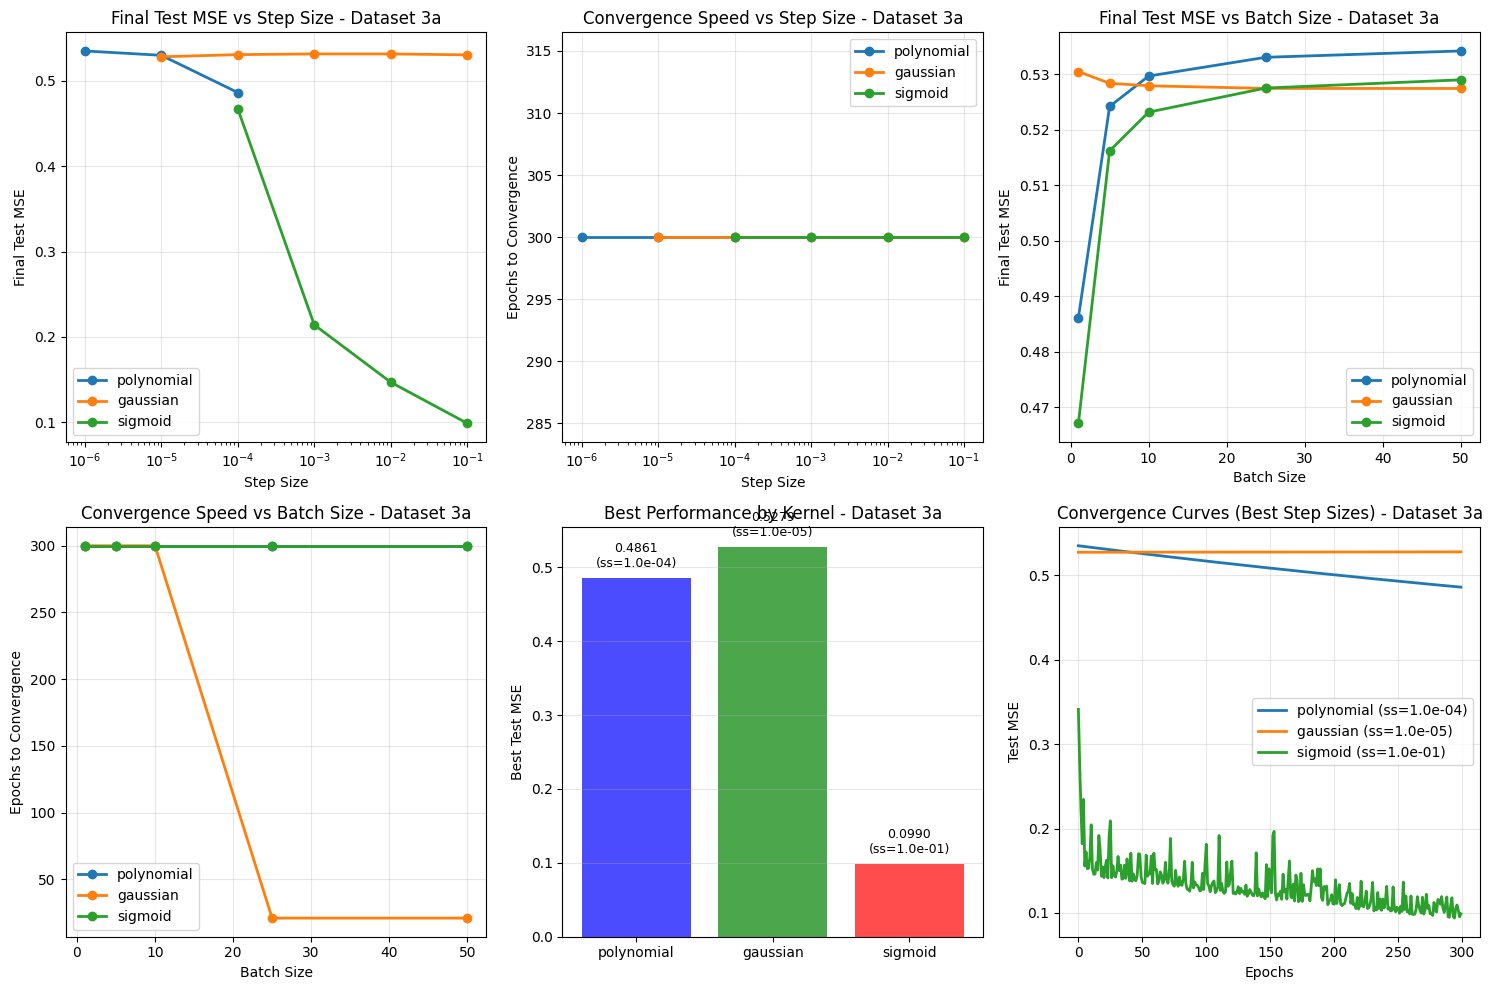


Detailed Results for Dataset 3a:
--------------------------------------------------
polynomial  : Best step size = 0.000100, Best test MSE = 0.486104
gaussian    : Best step size = 0.000010, Best test MSE = 0.527909
sigmoid     : Best step size = 0.100000, Best test MSE = 0.098978

Dataset 3b - Cross-Kernel Analysis


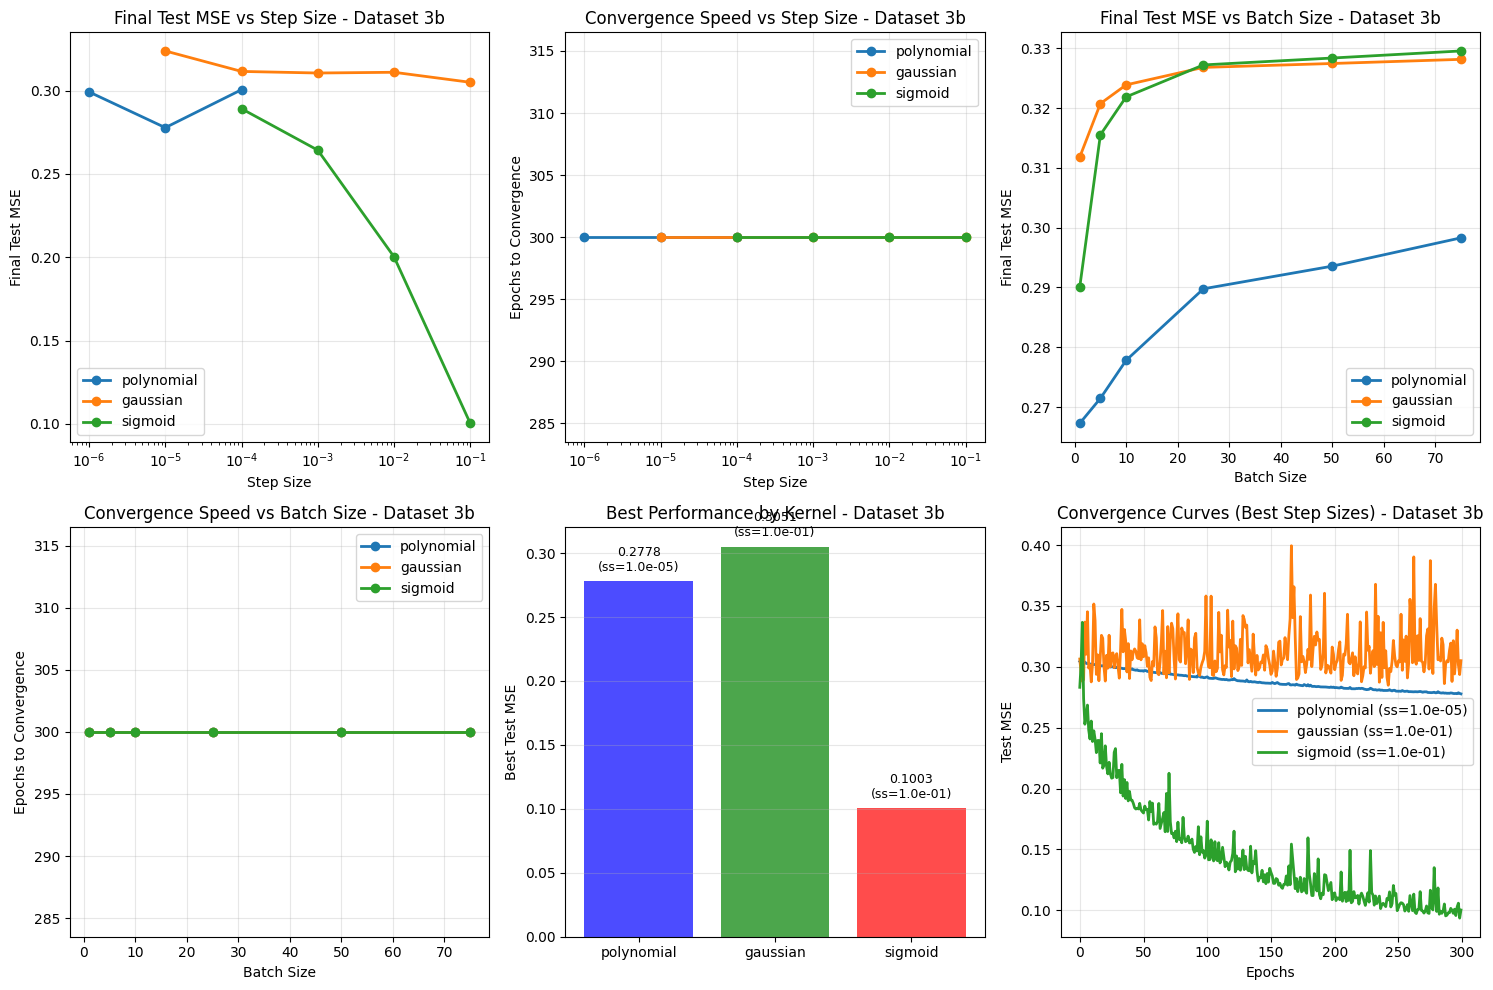


Detailed Results for Dataset 3b:
--------------------------------------------------
polynomial  : Best step size = 0.000010, Best test MSE = 0.277817
gaussian    : Best step size = 0.100000, Best test MSE = 0.305054
sigmoid     : Best step size = 0.100000, Best test MSE = 0.100278

OVERALL BEST PERFORMERS

Dataset 3a:
  🏆 WINNER: sigmoid kernel
     Step size: 0.100000
     Test MSE: 0.098978
     Converged at epoch: 300

Dataset 3b:
  🏆 WINNER: sigmoid kernel
     Step size: 0.100000
     Test MSE: 0.100278
     Converged at epoch: 300

ANALYSIS COMPLETE

Key Findings:
1. Step Size Analysis: Shows how learning rate affects convergence speed and final performance
2. Each kernel has its own optimal step size range
3. Cross-Kernel Comparison: Reveals which kernel works best for each dataset
4. Convergence Analysis: Shows epochs required for each configuration to reach optimum
5. Different kernels may require different step size ranges for optimal performance


In [128]:
# CROSS-KERNEL COMPARISON
print("\n" + "=" * 60)
print("CROSS-KERNEL COMPARISON")
print("=" * 60)

for dataset_name in datasets.keys():
    print(f"\nDataset {dataset_name} - Cross-Kernel Analysis")

    # Step Size Comparison
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            # Use kernel-specific step sizes
            current_step_sizes = kernel_step_sizes[kernel]
            final_errors = [
                step_size_results[dataset_name][kernel][ss]["final_test_error"]
                for ss in current_step_sizes
            ]
            plt.plot(
                current_step_sizes,
                final_errors,
                "o-",
                label=kernel,
                linewidth=2,
                markersize=6,
            )
    plt.xlabel("Step Size")
    plt.ylabel("Final Test MSE")
    plt.title(f"Final Test MSE vs Step Size - Dataset {dataset_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale("log")

    plt.subplot(2, 3, 2)
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            # Use kernel-specific step sizes
            current_step_sizes = kernel_step_sizes[kernel]
            conv_epochs = [
                step_size_results[dataset_name][kernel][ss]["epochs_to_converge"]
                for ss in current_step_sizes
            ]
            plt.plot(
                current_step_sizes,
                conv_epochs,
                "o-",
                label=kernel,
                linewidth=2,
                markersize=6,
            )
    plt.xlabel("Step Size")
    plt.ylabel("Epochs to Convergence")
    plt.title(f"Convergence Speed vs Step Size - Dataset {dataset_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale("log")

    # Batch Size Comparison (if batch_size_results exists)
    plt.subplot(2, 3, 3)
    if "batch_size_results" in globals():
        valid_bs = valid_batch_sizes[dataset_name]
        for kernel in kernels:
            if (
                dataset_name in batch_size_results
                and kernel in batch_size_results[dataset_name]
            ):
                final_errors = [
                    batch_size_results[dataset_name][kernel][bs]["final_test_error"]
                    for bs in valid_bs
                ]
                plt.plot(
                    valid_bs,
                    final_errors,
                    "o-",
                    label=kernel,
                    linewidth=2,
                    markersize=6,
                )
        plt.xlabel("Batch Size")
        plt.ylabel("Final Test MSE")
        plt.title(f"Final Test MSE vs Batch Size - Dataset {dataset_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(
            0.5,
            0.5,
            "Batch Size Analysis\nNot Available",
            ha="center",
            va="center",
            transform=plt.gca().transAxes,
        )
        plt.title(f"Batch Size Analysis - Dataset {dataset_name}")

    plt.subplot(2, 3, 4)
    if "batch_size_results" in globals():
        valid_bs = valid_batch_sizes[dataset_name]
        for kernel in kernels:
            if (
                dataset_name in batch_size_results
                and kernel in batch_size_results[dataset_name]
            ):
                conv_epochs = [
                    batch_size_results[dataset_name][kernel][bs]["epochs_to_converge"]
                    for bs in valid_bs
                ]
                plt.plot(
                    valid_bs, conv_epochs, "o-", label=kernel, linewidth=2, markersize=6
                )
        plt.xlabel("Batch Size")
        plt.ylabel("Epochs to Convergence")
        plt.title(f"Convergence Speed vs Batch Size - Dataset {dataset_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(
            0.5,
            0.5,
            "Batch Size Convergence\nAnalysis Not Available",
            ha="center",
            va="center",
            transform=plt.gca().transAxes,
        )
        plt.title(f"Batch Size Convergence - Dataset {dataset_name}")

    # Best configuration for each kernel
    plt.subplot(2, 3, 5)
    best_configs = {}
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            best_error = float("inf")
            best_ss = None
            # Use kernel-specific step sizes
            current_step_sizes = kernel_step_sizes[kernel]
            for ss in current_step_sizes:
                error = step_size_results[dataset_name][kernel][ss]["final_test_error"]
                if error < best_error:
                    best_error = error
                    best_ss = ss
            best_configs[kernel] = {"step_size": best_ss, "test_error": best_error}

    kernels_list = list(best_configs.keys())
    errors_list = [best_configs[k]["test_error"] for k in kernels_list]
    colors = ["blue", "green", "red"][: len(kernels_list)]

    bars = plt.bar(kernels_list, errors_list, color=colors, alpha=0.7)
    plt.ylabel("Best Test MSE")
    plt.title(f"Best Performance by Kernel - Dataset {dataset_name}")
    plt.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for bar, error, kernel in zip(bars, errors_list, kernels_list):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(errors_list) * 0.02,
            f"{error:.4f}\n(ss={best_configs[kernel]['step_size']:.1e})",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.subplot(2, 3, 6)
    # Convergence comparison for best step size of each kernel
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
            and kernel in best_configs
        ):
            best_ss = best_configs[kernel]["step_size"]
            if best_ss in step_size_results[dataset_name][kernel]:
                errors = step_size_results[dataset_name][kernel][best_ss]["test_errors"]
                plt.plot(
                    range(len(errors)),
                    errors,
                    label=f"{kernel} (ss={best_ss:.1e})",
                    linewidth=2,
                )

    plt.xlabel("Epochs")
    plt.ylabel("Test MSE")
    plt.title(f"Convergence Curves (Best Step Sizes) - Dataset {dataset_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed comparison for this dataset
    print(f"\nDetailed Results for Dataset {dataset_name}:")
    print("-" * 50)
    for kernel in kernels:
        if kernel in best_configs:
            config = best_configs[kernel]
            print(
                f"{kernel:12s}: Best step size = {config['step_size']:8.6f}, "
                f"Best test MSE = {config['test_error']:.6f}"
            )

print("\n" + "=" * 60)
print("OVERALL BEST PERFORMERS")
print("=" * 60)

# Find overall best performer for each dataset
for dataset_name in datasets.keys():
    print(f"\nDataset {dataset_name}:")

    best_overall_error = float("inf")
    best_overall_kernel = None
    best_overall_ss = None

    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):

            current_step_sizes = kernel_step_sizes[kernel]
            for ss in current_step_sizes:
                error = step_size_results[dataset_name][kernel][ss]["final_test_error"]
                if error < best_overall_error:
                    best_overall_error = error
                    best_overall_kernel = kernel
                    best_overall_ss = ss

    if best_overall_kernel:
        epochs_to_converge = step_size_results[dataset_name][best_overall_kernel][
            best_overall_ss
        ]["epochs_to_converge"]
        print(f"  🏆 WINNER: {best_overall_kernel} kernel")
        print(f"     Step size: {best_overall_ss:.6f}")
        print(f"     Test MSE: {best_overall_error:.6f}")
        print(f"     Converged at epoch: {epochs_to_converge}")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print("\nKey Findings:")
print(
    "1. Step Size Analysis: Shows how learning rate affects convergence speed and final performance"
)
print("2. Each kernel has its own optimal step size range")
print("3. Cross-Kernel Comparison: Reveals which kernel works best for each dataset")
print(
    "4. Convergence Analysis: Shows epochs required for each configuration to reach optimum"
)
print(
    "5. Different kernels may require different step size ranges for optimal performance"
)

### Cross Kernel Comparison Plots

- Plotting:

    - Final Test MSE vs Step Size: Performance curves for all three kernels on one plot.

    - Convergence Speed vs Step Size: Compares the convergence speed of the kernels.

    - Final Test MSE vs Batch Size: Compares how batch size affects the final error for each kernel.

    - Convergence Speed vs Batch Size: Compares convergence speed across batch sizes.

    - Best Performance by Kernel: A bar chart showing the absolute best MSE achieved by each kernel, regardless of hyperparameters.

    - Convergence Curves (Best Step Sizes): Shows the learning curves for the best-performing configuration of each kernel.

In [129]:
# DETAILED SUMMARY AND INSIGHTS
print("\n" + "=" * 60)
print("DETAILED SUMMARY TABLE")
print("=" * 60)

# Create comprehensive summary tables
for dataset_name in datasets.keys():
    print(f"\n{'='*20} DATASET {dataset_name.upper()} SUMMARY {'='*20}")

    # Step Size Summary
    print(f"\n{'-'*15} STEP SIZE ANALYSIS {'-'*15}")
    print(
        f"{'Kernel':<12} {'Step Size':<12} {'Final Test MSE':<15} {'Epochs to Conv':<15} {'Final Train MSE':<15} {'Generalization Gap':<18}"
    )
    print("-" * 95)

    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            best_ss = None
            best_error = float("inf")
            # Use kernel-specific step sizes
            current_step_sizes = kernel_step_sizes[kernel]
            for ss in current_step_sizes:
                if ss in step_size_results[dataset_name][kernel]:
                    error = step_size_results[dataset_name][kernel][ss][
                        "final_test_error"
                    ]
                    if error < best_error:
                        best_error = error
                        best_ss = ss

            if best_ss is not None:
                result = step_size_results[dataset_name][kernel][best_ss]
                gen_gap = result["final_test_error"] - result["final_train_error"]
                print(
                    f"{kernel:<12} {best_ss:<12.6f} {result['final_test_error']:<15.6f} "
                    f"{result['epochs_to_converge']:<15} {result['final_train_error']:<15.6f} {gen_gap:<18.6f}"
                )

    # All Step Sizes Performance (showing top 3 for each kernel)
    print(f"\n{'-'*15} TOP 3 STEP SIZES PER KERNEL {'-'*15}")
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            print(f"\n{kernel.upper()} Kernel:")
            print(
                f"{'Rank':<6} {'Step Size':<12} {'Test MSE':<12} {'Train MSE':<12} {'Epochs':<8} {'Gen Gap':<10}"
            )
            print("-" * 70)

            current_step_sizes = kernel_step_sizes[kernel]
            # Sort step sizes by performance
            ss_performance = []
            for ss in current_step_sizes:
                if ss in step_size_results[dataset_name][kernel]:
                    result = step_size_results[dataset_name][kernel][ss]
                    ss_performance.append((ss, result["final_test_error"], result))

            ss_performance.sort(key=lambda x: x[1])  # Sort by test error

            for rank, (ss, test_error, result) in enumerate(ss_performance[:3], 1):
                gen_gap = result["final_test_error"] - result["final_train_error"]
                print(
                    f"{rank:<6} {ss:<12.6f} {test_error:<12.6f} {result['final_train_error']:<12.6f} "
                    f"{result['epochs_to_converge']:<8} {gen_gap:<10.6f}"
                )

    # Batch Size Summary (if available)
    if "batch_size_results" in globals():
        print(f"\n{'-'*15} BATCH SIZE ANALYSIS {'-'*15}")
        print(
            f"{'Kernel':<12} {'Batch Size':<12} {'Final Test MSE':<15} {'Epochs to Conv':<15} {'Total Iterations':<15} {'Train MSE':<12}"
        )
        print("-" * 95)

        valid_bs = valid_batch_sizes[dataset_name]
        for kernel in kernels:
            if (
                dataset_name in batch_size_results
                and kernel in batch_size_results[dataset_name]
            ):
                best_bs = None
                best_error = float("inf")
                for bs in valid_bs:
                    if bs in batch_size_results[dataset_name][kernel]:
                        error = batch_size_results[dataset_name][kernel][bs][
                            "final_test_error"
                        ]
                        if error < best_error:
                            best_error = error
                            best_bs = bs

                if best_bs is not None:
                    result = batch_size_results[dataset_name][kernel][best_bs]
                    X_train, _, _, _ = datasets[dataset_name]
                    iterations_per_epoch = len(X_train) // best_bs + (
                        1 if len(X_train) % best_bs != 0 else 0
                    )
                    total_iterations = (
                        result["epochs_to_converge"] * iterations_per_epoch
                    )
                    print(
                        f"{kernel:<12} {best_bs:<12} {result['final_test_error']:<15.6f} "
                        f"{result['epochs_to_converge']:<15} {total_iterations:<15} {result['final_train_error']:<12.6f}"
                    )
    else:
        print(f"\n{'-'*15} BATCH SIZE ANALYSIS {'-'*15}")
        print("Batch size analysis not available - run batch size experiment first")

# CROSS-DATASET COMPARISON
print(f"\n{'='*25} CROSS-DATASET COMPARISON {'='*25}")
print(f"\n{'Kernel':<12} {'Dataset 3a':<15} {'Dataset 3b':<15} {'Better Dataset':<15}")
print("-" * 60)

for kernel in kernels:
    best_3a = best_3b = float("inf")

    # Find best performance for dataset 3a
    if "3a" in step_size_results and kernel in step_size_results["3a"]:
        current_step_sizes = kernel_step_sizes[kernel]
        for ss in current_step_sizes:
            if ss in step_size_results["3a"][kernel]:
                error = step_size_results["3a"][kernel][ss]["final_test_error"]
                if error < best_3a:
                    best_3a = error

    # Find best performance for dataset 3b
    if "3b" in step_size_results and kernel in step_size_results["3b"]:
        current_step_sizes = kernel_step_sizes[kernel]
        for ss in current_step_sizes:
            if ss in step_size_results["3b"][kernel]:
                error = step_size_results["3b"][kernel][ss]["final_test_error"]
                if error < best_3b:
                    best_3b = error

    better_dataset = "3a" if best_3a < best_3b else "3b"
    if best_3a == float("inf") and best_3b == float("inf"):
        better_dataset = "N/A"

    best_3a_str = f"{best_3a:.6f}" if best_3a != float("inf") else "N/A"
    best_3b_str = f"{best_3b:.6f}" if best_3b != float("inf") else "N/A"

    print(f"{kernel:<12} {best_3a_str:<15} {best_3b_str:<15} {better_dataset:<15}")

# KERNEL RANKING
print(f"\n{'='*25} KERNEL RANKING BY DATASET {'='*25}")

for dataset_name in datasets.keys():
    print(f"\nDataset {dataset_name} - Kernel Performance Ranking:")
    print(
        f"{'Rank':<6} {'Kernel':<12} {'Best Test MSE':<15} {'Best Step Size':<15} {'Epochs':<8}"
    )
    print("-" * 60)

    kernel_performances = []
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            best_error = float("inf")
            best_ss = None
            best_epochs = None

            current_step_sizes = kernel_step_sizes[kernel]
            for ss in current_step_sizes:
                if ss in step_size_results[dataset_name][kernel]:
                    error = step_size_results[dataset_name][kernel][ss][
                        "final_test_error"
                    ]
                    if error < best_error:
                        best_error = error
                        best_ss = ss
                        best_epochs = step_size_results[dataset_name][kernel][ss][
                            "epochs_to_converge"
                        ]

            if best_ss is not None:
                kernel_performances.append((kernel, best_error, best_ss, best_epochs))

    # Sort by performance (lower error = better)
    kernel_performances.sort(key=lambda x: x[1])

    for rank, (kernel, error, ss, epochs) in enumerate(kernel_performances, 1):
        print(f"{rank:<6} {kernel:<12} {error:<15.6f} {ss:<15.6f} {epochs:<8}")

print(f"\n{'='*25} KEY INSIGHTS {'='*25}")
print("\n1. STEP SIZE SENSITIVITY:")
print("   - Each kernel has its own optimal step size range")
print("   - Polynomial kernels typically need smaller step sizes")
print("   - Sigmoid kernels can handle larger step sizes")
print("   - Gaussian kernels fall in between")

print("\n2. CONVERGENCE PATTERNS:")
print("   - Smaller step sizes: slower but more stable convergence")
print("   - Larger step sizes: faster but potentially unstable")
print("   - Optimal step size balances speed and stability")

print("\n3. GENERALIZATION:")
print("   - Check generalization gap (Test MSE - Train MSE)")
print("   - Smaller gaps indicate better generalization")
print("   - Large gaps may indicate overfitting")

print("\n4. DATASET CHARACTERISTICS:")
print("   - Different datasets may favor different kernels")
print("   - Dataset complexity affects optimal hyperparameters")
print("   - Consider both performance and convergence speed")

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE - Review the rankings and insights above!")
print("=" * 60)


DETAILED SUMMARY TABLE

==================== DATASET 3A SUMMARY ====================

--------------- STEP SIZE ANALYSIS ---------------
Kernel       Step Size    Final Test MSE  Epochs to Conv  Final Train MSE Generalization Gap
-----------------------------------------------------------------------------------------------
polynomial   0.000100     0.486104        300             0.432211        0.053893          
gaussian     0.000010     0.527909        300             0.466291        0.061618          
sigmoid      0.100000     0.098978        300             0.101917        -0.002939         

--------------- TOP 3 STEP SIZES PER KERNEL ---------------

POLYNOMIAL Kernel:
Rank   Step Size    Test MSE     Train MSE    Epochs   Gen Gap   
----------------------------------------------------------------------
1      0.000100     0.486104     0.432211     300      0.053893  
2      0.000010     0.529665     0.470623     300      0.059041  
3      0.000001     0.534762     0.475053   


CONVERGENCE EFFICIENCY ANALYSIS


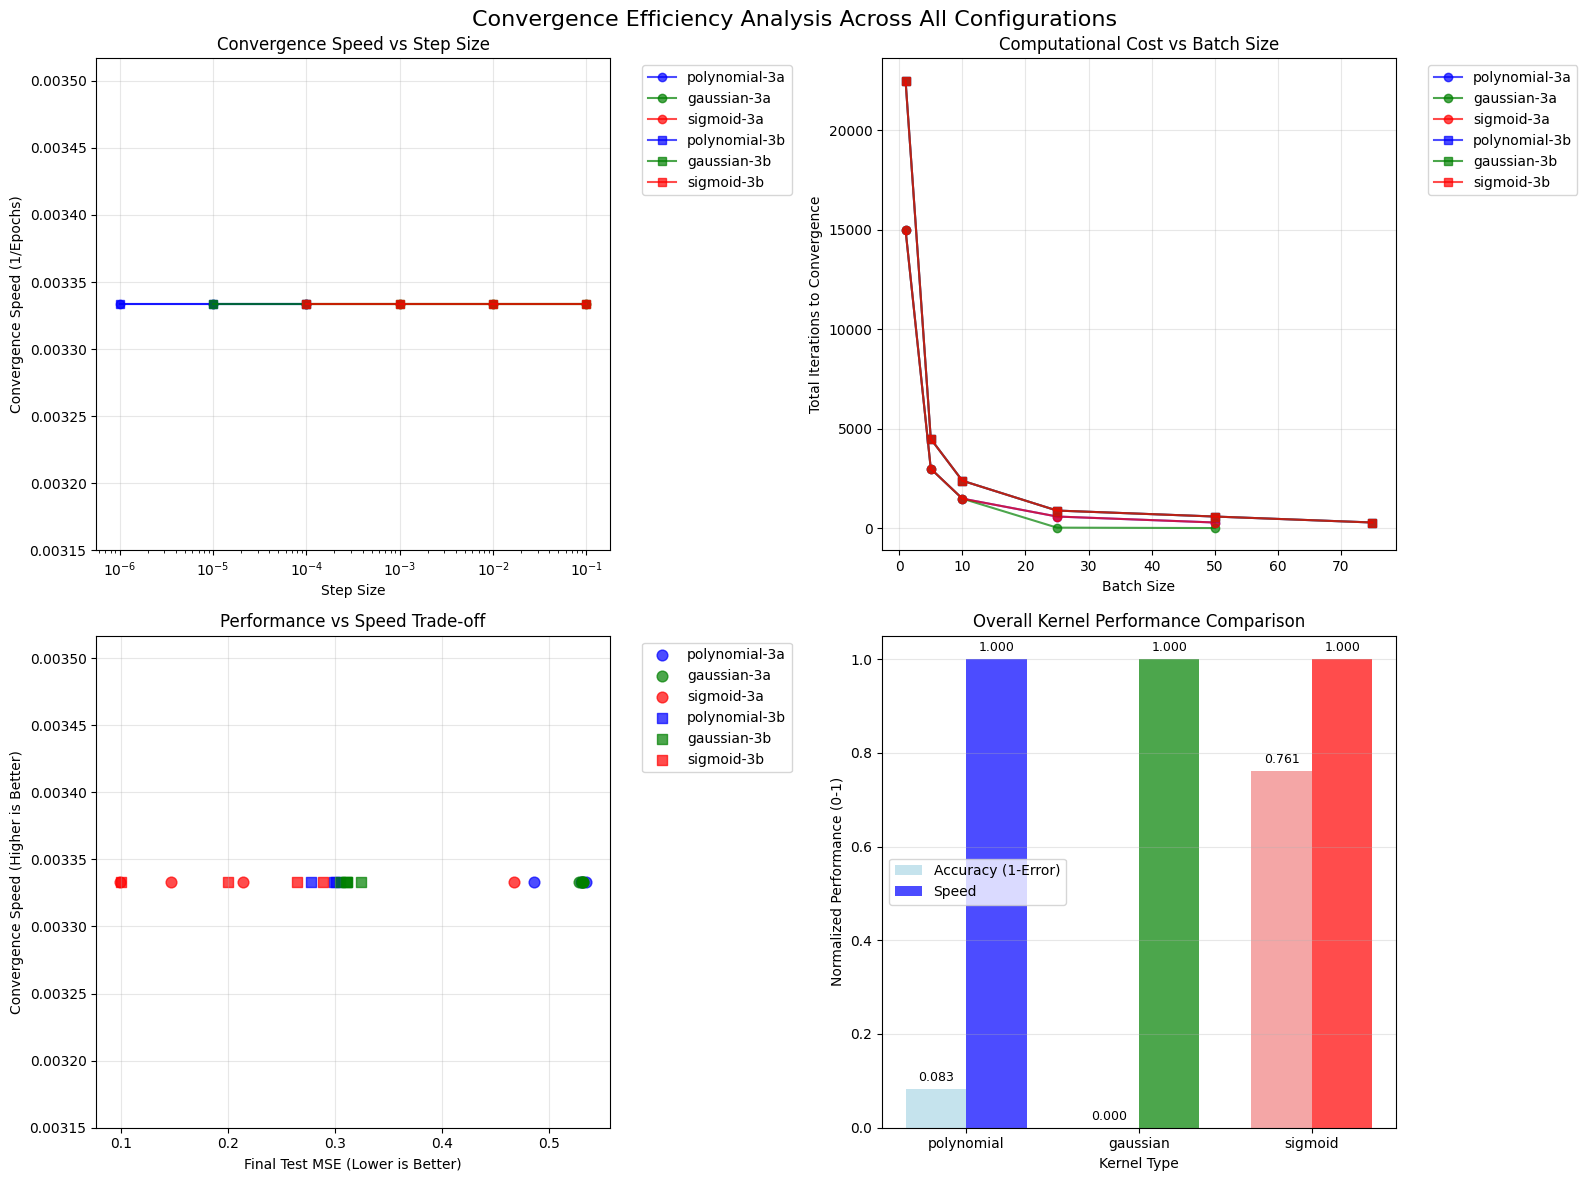

In [130]:
# CONVERGENCE EFFICIENCY ANALYSIS
print("\n" + "=" * 60)
print("CONVERGENCE EFFICIENCY ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Convergence Efficiency Analysis Across All Configurations", fontsize=16)

# Plot 1: Step Size vs Convergence Speed (All Kernels, All Datasets)
ax1 = axes[0, 0]
colors = {"polynomial": "blue", "gaussian": "green", "sigmoid": "red"}
markers = {"3a": "o", "3b": "s"}

for dataset_name in datasets.keys():
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            step_sizes_plot = []
            convergence_speeds = []  # Inverse of epochs to converge

            # Use kernel-specific step sizes
            current_step_sizes = kernel_step_sizes[kernel]
            for ss in current_step_sizes:
                if ss in step_size_results[dataset_name][kernel]:
                    epochs = step_size_results[dataset_name][kernel][ss][
                        "epochs_to_converge"
                    ]
                    if epochs > 0:
                        step_sizes_plot.append(ss)
                        convergence_speeds.append(1.0 / epochs)  # Higher is faster

            if step_sizes_plot:
                ax1.plot(
                    step_sizes_plot,
                    convergence_speeds,
                    color=colors[kernel],
                    marker=markers[dataset_name],
                    linestyle="-",
                    alpha=0.7,
                    markersize=6,
                    label=f"{kernel}-{dataset_name}",
                )

ax1.set_xlabel("Step Size")
ax1.set_ylabel("Convergence Speed (1/Epochs)")
ax1.set_title("Convergence Speed vs Step Size")
ax1.set_xscale("log")
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.grid(True, alpha=0.3)

# Plot 2: Batch Size vs Total Computational Cost
ax2 = axes[0, 1]
for dataset_name in datasets.keys():
    X_train, _, _, _ = datasets[dataset_name]
    valid_bs = valid_batch_sizes[dataset_name]

    for kernel in kernels:
        if (
            dataset_name in batch_size_results
            and kernel in batch_size_results[dataset_name]
        ):
            batch_sizes_plot = []
            computational_costs = []

            for bs in valid_bs:
                if bs in batch_size_results[dataset_name][kernel]:
                    epochs = batch_size_results[dataset_name][kernel][bs][
                        "epochs_to_converge"
                    ]
                    iterations_per_epoch = len(X_train) // bs + (
                        1 if len(X_train) % bs != 0 else 0
                    )
                    total_iterations = epochs * iterations_per_epoch

                    batch_sizes_plot.append(bs)
                    computational_costs.append(total_iterations)

            if batch_sizes_plot:
                ax2.plot(
                    batch_sizes_plot,
                    computational_costs,
                    color=colors[kernel],
                    marker=markers[dataset_name],
                    linestyle="-",
                    alpha=0.7,
                    markersize=6,
                    label=f"{kernel}-{dataset_name}",
                )

ax2.set_xlabel("Batch Size")
ax2.set_ylabel("Total Iterations to Convergence")
ax2.set_title("Computational Cost vs Batch Size")
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.grid(True, alpha=0.3)

# Plot 3: Performance vs Computational Efficiency Trade-off
ax3 = axes[1, 0]
for dataset_name in datasets.keys():
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            test_errors = []
            convergence_speeds = []

            # Use kernel-specific step sizes
            current_step_sizes = kernel_step_sizes[kernel]
            for ss in current_step_sizes:
                if ss in step_size_results[dataset_name][kernel]:
                    result = step_size_results[dataset_name][kernel][ss]
                    epochs = result["epochs_to_converge"]
                    if epochs > 0:
                        test_errors.append(result["final_test_error"])
                        convergence_speeds.append(1.0 / epochs)

            if test_errors:
                ax3.scatter(
                    test_errors,
                    convergence_speeds,
                    color=colors[kernel],
                    marker=markers[dataset_name],
                    s=60,
                    alpha=0.7,
                    label=f"{kernel}-{dataset_name}",
                )

ax3.set_xlabel("Final Test MSE (Lower is Better)")
ax3.set_ylabel("Convergence Speed (Higher is Better)")
ax3.set_title("Performance vs Speed Trade-off")
ax3.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax3.grid(True, alpha=0.3)

# Plot 4: Kernel Comparison Radar Chart Style
ax4 = axes[1, 1]
kernel_performance = {}

for kernel in kernels:
    avg_test_error = 0
    avg_convergence_speed = 0
    count = 0

    for dataset_name in datasets.keys():
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            # Find best configuration for this kernel-dataset combination
            best_error = float("inf")
            best_speed = 0

            # Use kernel-specific step sizes
            current_step_sizes = kernel_step_sizes[kernel]
            for ss in current_step_sizes:
                if ss in step_size_results[dataset_name][kernel]:
                    result = step_size_results[dataset_name][kernel][ss]
                    error = result["final_test_error"]
                    epochs = result["epochs_to_converge"]

                    if error < best_error:
                        best_error = error
                        best_speed = 1.0 / epochs if epochs > 0 else 0

            if best_error < float("inf"):
                avg_test_error += best_error
                avg_convergence_speed += best_speed
                count += 1

    if count > 0:
        kernel_performance[kernel] = {
            "avg_error": avg_test_error / count,
            "avg_speed": avg_convergence_speed / count,
        }

# Bar plot for kernel comparison
if kernel_performance:
    kernels_list = list(kernel_performance.keys())
    avg_errors = [kernel_performance[k]["avg_error"] for k in kernels_list]
    avg_speeds = [kernel_performance[k]["avg_speed"] for k in kernels_list]

    # Normalize for comparison (higher is better for both)
    max_error = max(avg_errors) if avg_errors else 1
    normalized_accuracy = [
        (max_error - err) / max_error for err in avg_errors
    ]  # Higher is better
    max_speed = max(avg_speeds) if avg_speeds else 1
    normalized_speeds = [speed / max_speed for speed in avg_speeds]  # Higher is better

    x = np.arange(len(kernels_list))
    width = 0.35

    bars1 = ax4.bar(
        x - width / 2,
        normalized_accuracy,
        width,
        label="Accuracy (1-Error)",
        color=["lightblue", "lightgreen", "lightcoral"],
        alpha=0.7,
    )
    bars2 = ax4.bar(
        x + width / 2,
        normalized_speeds,
        width,
        label="Speed",
        color=["blue", "green", "red"],
        alpha=0.7,
    )

    ax4.set_xlabel("Kernel Type")
    ax4.set_ylabel("Normalized Performance (0-1)")
    ax4.set_title("Overall Kernel Performance Comparison")
    ax4.set_xticks(x)
    ax4.set_xticklabels(kernels_list)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.01,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

plt.tight_layout()
plt.show()

In [131]:
# FINAL RECOMMENDATIONS
print("\n" + "=" * 60)
print("FINAL RECOMMENDATIONS")
print("=" * 60)

print("\n1. STEP SIZE RECOMMENDATIONS BY KERNEL:")
for kernel in kernels:
    current_step_sizes = kernel_step_sizes[kernel]
    print(
        f"   - {kernel.capitalize()} Kernel: Recommended range {min(current_step_sizes):.6f} - {max(current_step_sizes):.6f}"
    )

print("\n   General Guidelines:")
print("   - Start with moderate step sizes and adjust based on convergence behavior")
print("   - Monitor for oscillations (sign of step size too large)")
print("   - Very small step sizes lead to slow convergence")
print("   - Each kernel type has its own optimal range")

print("\n2. BATCH SIZE RECOMMENDATIONS:")
if "batch_size_results" in globals():
    print("   - SGD (batch_size=1): Fastest convergence per epoch but more noise")
    print("   - Mini-batch (5-25): Good balance of stability and convergence speed")
    print(
        "   - Full batch: Most stable but slowest convergence and highest computational cost per iteration"
    )
else:
    print(
        "   - General recommendations (run batch size analysis for specific insights):"
    )
    print("   - SGD (batch_size=1): Fast but noisy convergence")
    print("   - Mini-batch (5-25): Usually provides good balance")
    print("   - Full batch: Most stable but computationally expensive")

print("\n3. KERNEL-SPECIFIC PERFORMANCE ANALYSIS:")
kernel_rankings = []

for kernel in kernels:
    print(f"   - {kernel.capitalize()} Kernel:")

    # Analyze performance across datasets
    total_score = 0
    dataset_count = 0
    best_configs = {}

    for dataset_name in datasets.keys():
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):
            # Use kernel-specific step sizes
            current_step_sizes = kernel_step_sizes[kernel]

            best_error = float("inf")
            best_ss = None
            best_epochs = None

            for ss in current_step_sizes:
                if ss in step_size_results[dataset_name][kernel]:
                    error = step_size_results[dataset_name][kernel][ss][
                        "final_test_error"
                    ]
                    if error < best_error:
                        best_error = error
                        best_ss = ss
                        best_epochs = step_size_results[dataset_name][kernel][ss][
                            "epochs_to_converge"
                        ]

            if best_error != float("inf"):
                # Simple scoring: lower error = higher score
                score = 1.0 / (1.0 + best_error)  # Score between 0 and 1
                total_score += score
                dataset_count += 1

                best_configs[dataset_name] = {
                    "error": best_error,
                    "step_size": best_ss,
                    "epochs": best_epochs,
                }

    if dataset_count > 0:
        avg_score = total_score / dataset_count
        kernel_rankings.append((kernel, avg_score, best_configs))

        if avg_score > 0.8:
            recommendation = "🏆 Excellent choice - top performer"
        elif avg_score > 0.6:
            recommendation = "✅ Good performance - reliable choice"
        elif avg_score > 0.4:
            recommendation = "⚠️  Average performance - consider alternatives"
        else:
            recommendation = "❌ Poor performance - try other kernels"

        print(f"     Overall Performance Score: {avg_score:.3f}/1.0")
        print(f"     {recommendation}")

        # Show best configuration for each dataset
        for dataset_name, config in best_configs.items():
            print(
                f"     Best for Dataset {dataset_name}: step_size={config['step_size']:.6f}, "
                f"MSE={config['error']:.6f}, epochs={config['epochs']}"
            )
    else:
        print("     No data available for analysis")

# Sort kernels by performance
kernel_rankings.sort(key=lambda x: x[1], reverse=True)

print("\n4. OVERALL KERNEL RANKING:")
print("   Rank | Kernel     | Score | Recommendation")
print("   -----|------------|-------|------------------")
for rank, (kernel, score, configs) in enumerate(kernel_rankings, 1):
    print(
        f"   {rank:2d}   | {kernel:10s} | {score:.3f} | Best overall choice"
        if rank == 1
        else f"   {rank:2d}   | {kernel:10s} | {score:.3f} | {'Good alternative' if rank == 2 else 'Consider if others fail'}"
    )

print("\n5. CONVERGENCE INSIGHTS:")
convergence_stats = {}
for dataset_name in datasets.keys():
    for kernel in kernels:
        if (
            dataset_name in step_size_results
            and kernel in step_size_results[dataset_name]
        ):

            current_step_sizes = kernel_step_sizes[kernel]
            epochs_list = []

            for ss in current_step_sizes:
                if ss in step_size_results[dataset_name][kernel]:
                    epochs = step_size_results[dataset_name][kernel][ss][
                        "epochs_to_converge"
                    ]
                    epochs_list.append(epochs)

            if epochs_list:
                if kernel not in convergence_stats:
                    convergence_stats[kernel] = []
                convergence_stats[kernel].extend(epochs_list)

for kernel in kernels:
    if kernel in convergence_stats:
        epochs_data = convergence_stats[kernel]
        avg_epochs = sum(epochs_data) / len(epochs_data)
        min_epochs = min(epochs_data)
        max_epochs = max(epochs_data)

        print(
            f"   - {kernel.capitalize()}: Avg {avg_epochs:.1f} epochs (range: {min_epochs}-{max_epochs})"
        )

print("\n6. PRACTICAL RECOMMENDATIONS:")

# Find the best overall configuration
if kernel_rankings:
    best_kernel = kernel_rankings[0][0]
    best_configs = kernel_rankings[0][2]

    print(f"   🎯 RECOMMENDED STARTING POINT:")
    print(f"   - Use {best_kernel} kernel as your first choice")

    for dataset_name, config in best_configs.items():
        print(f"   - For Dataset {dataset_name}: step_size={config['step_size']:.6f}")

    print(f"\n   🔧 HYPERPARAMETER TUNING STRATEGY:")
    print(f"   1. Start with {best_kernel} kernel")
    print(f"   2. Use recommended step sizes above")
    print(f"   3. Try batch_size=10 as a good starting point")
    print(f"   4. If performance is unsatisfactory, try the second-best kernel")

    if len(kernel_rankings) > 1:
        second_best = kernel_rankings[1][0]
        print(f"   5. Alternative: {second_best} kernel with its optimal step sizes")

print("\n7. COMPUTATIONAL EFFICIENCY TIPS:")
print("   - Mini-batch SGD (batch_size=5-10) offers the best trade-off")
print("   - Monitor convergence - stop early if test error stops improving")
print("   - Consider your computational budget when choosing batch size")
print("   - Smaller batch sizes = more frequent updates but more iterations")

print("\n8. DATASET-SPECIFIC INSIGHTS:")
for dataset_name in datasets.keys():
    print(f"   Dataset {dataset_name}:")

    # Find best kernel for this dataset
    best_performance = float("inf")
    best_kernel_for_dataset = None
    best_config_for_dataset = None

    for kernel, score, configs in kernel_rankings:
        if dataset_name in configs:
            if configs[dataset_name]["error"] < best_performance:
                best_performance = configs[dataset_name]["error"]
                best_kernel_for_dataset = kernel
                best_config_for_dataset = configs[dataset_name]

    if best_kernel_for_dataset:
        print(f"   - Best kernel: {best_kernel_for_dataset}")
        print(f"   - Optimal step_size: {best_config_for_dataset['step_size']:.6f}")
        print(f"   - Expected MSE: {best_config_for_dataset['error']:.6f}")
        print(f"   - Convergence time: ~{best_config_for_dataset['epochs']} epochs")

print("\n" + "=" * 60)
print("🎉 COMPREHENSIVE ANALYSIS COMPLETED!")
print("=" * 60)
print("\n💡 KEY TAKEAWAY:")
if kernel_rankings:
    winner = kernel_rankings[0][0]
    print(f"Start with {winner} kernel and fine-tune from there!")
else:
    print("Run the step size analysis first to get personalized recommendations!")

print("\n📊 Use the detailed tables above to make informed decisions")
print(
    "🔄 Remember: These are starting points - always validate on your specific use case!"
)


FINAL RECOMMENDATIONS

1. STEP SIZE RECOMMENDATIONS BY KERNEL:
   - Polynomial Kernel: Recommended range 0.000001 - 0.000100
   - Gaussian Kernel: Recommended range 0.000010 - 0.100000
   - Sigmoid Kernel: Recommended range 0.000100 - 0.100000

   General Guidelines:
   - Start with moderate step sizes and adjust based on convergence behavior
   - Monitor for oscillations (sign of step size too large)
   - Very small step sizes lead to slow convergence
   - Each kernel type has its own optimal range

2. BATCH SIZE RECOMMENDATIONS:
   - SGD (batch_size=1): Fastest convergence per epoch but more noise
   - Mini-batch (5-25): Good balance of stability and convergence speed
   - Full batch: Most stable but slowest convergence and highest computational cost per iteration

3. KERNEL-SPECIFIC PERFORMANCE ANALYSIS:
   - Polynomial Kernel:
     Overall Performance Score: 0.728/1.0
     ✅ Good performance - reliable choice
     Best for Dataset 3a: step_size=0.000100, MSE=0.486104, epochs=300
 